In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import itertools
from collections import OrderedDict
from functools import cmp_to_key
%matplotlib inline

In [2]:
working_dir = './data/tinysleepnet'
result_dirs = [
    'batch_run_1',
    'batch_run_2',
    'batch_run_3',
    'batch_run_4',
    'batch_run_5',
    'batch_run_6',
]

In [3]:
dfs = []
for result_dir in result_dirs:
    data_dir = os.path.join(working_dir, result_dir)
    for f in glob.glob(os.path.join(data_dir, '*.csv')):
        print(f'Read from {f}')
        df = pd.read_csv(f)
        dfs.append(df)
df = pd.concat(dfs, axis=0)
df = df.reset_index()

# Only consider type 3, 6, 9
df = df.loc[df['Type of transfer'].isin(['TYPE03','TYPE06','TYPE09'])]

def get_transfer_info(row):
    tf_info = row['Name'].split('/')[0]
    datasets = tf_info.split('_with_randomseed')[0].split('_to_')
    src_ds, src_ch = datasets[0].split('_with_channel_')
    tgt_ds, tgt_ch = datasets[1].split('_with_channel_')
    return pd.Series({
        'transfer_info': tf_info,
        'source_dataset':src_ds, 'source_channel':src_ch,
        'target_dataset':tgt_ds, 'target_channel':tgt_ch})

def rename_type(row):
    return f"type{row['Type of transfer'][-1]}"

df = pd.merge(df, df.apply(get_transfer_info, axis=1), left_index=True, right_index=True)
df['type_trans'] = df.apply(rename_type, axis=1)
df = df.rename(columns={'Accuracy':'acc', 'F1':'mf1'})
display(df)

data_dfs = []
types = [3,6,9]
for tf_info in df['transfer_info'].unique():
    _df = df[df['transfer_info'] == tf_info]
    _df = _df[['transfer_info', 'source_dataset', 'source_channel', 'target_dataset', 'target_channel', 'type_trans', 'acc', 'mf1']]
    if len(_df) % len(types) != 0:
        # Quick fix for incomplete runs (some types are missing, e.g., type9)
        # TODO: This should be changed in the future to make it more robust
        print('Drop duplicates')
        display(_df)
        _df = _df.drop_duplicates()
        display(_df)
    n_runs = int(len(_df)/len(types))
    perf_run = []
    for r in range(n_runs):
        offset_idx = len(types) * r
        perf_types = []
        for i, t in enumerate(types):
            perf_types.extend([
                _df.iloc[offset_idx+i]['acc'],
                _df.iloc[offset_idx+i]['mf1'],
            ])
        perf_run.append(perf_types)
    col_names = []
    for i, t in enumerate(types):
        col_names.extend([f'acc_type{t}', f'mf1_type{t}'])
    data_df = pd.DataFrame.from_records(perf_run, columns=col_names)
    for c in ['source_dataset', 'source_channel', 'target_dataset', 'target_channel']:
        data_df[c] = _df[c].values[0]
    data_df = data_df[['source_dataset', 'source_channel', 'target_dataset', 'target_channel']+col_names]
    data_dfs.append(data_df)
data_df = pd.concat(data_dfs, axis=0)
df = data_df.reset_index().drop(columns=['index'])
display(df)

Read from ./data/tinysleepnet/batch_run_1/conclusion_2.csv
Read from ./data/tinysleepnet/batch_run_1/conclusion_3.csv
Read from ./data/tinysleepnet/batch_run_1/conclusion_1.csv
Read from ./data/tinysleepnet/batch_run_1/conclusion_0.csv
Read from ./data/tinysleepnet/batch_run_1/conclusion_4.csv
Read from ./data/tinysleepnet/batch_run_2/conclusion_2.csv
Read from ./data/tinysleepnet/batch_run_2/conclusion_3.csv
Read from ./data/tinysleepnet/batch_run_2/conclusion_1.csv
Read from ./data/tinysleepnet/batch_run_2/conclusion_0.csv
Read from ./data/tinysleepnet/batch_run_3/conclusion_2.csv
Read from ./data/tinysleepnet/batch_run_3/conclusion_3.csv
Read from ./data/tinysleepnet/batch_run_3/conclusion_1.csv
Read from ./data/tinysleepnet/batch_run_3/conclusion_0.csv
Read from ./data/tinysleepnet/batch_run_3/conclusion_4.csv
Read from ./data/tinysleepnet/batch_run_3/conclusion_5.csv
Read from ./data/tinysleepnet/batch_run_4/conclusion_0_1.csv
Read from ./data/tinysleepnet/batch_run_4/conclusion_0

index                                               Name  \
2         2  mass_ss1_with_channel_eeg_o2_to_mass_ss3_with_...   
5         5  mass_ss1_with_channel_eeg_o2_to_mass_ss3_with_...   
8         8  mass_ss1_with_channel_eeg_o2_to_mass_ss3_with_...   
11       11  mass_ss1_with_channel_eeg_pz_to_isruc_with_cha...   
14       14  mass_ss1_with_channel_eeg_pz_to_isruc_with_cha...   
...     ...                                                ...   
5020    103  isruc_with_channel_eeg_o2_a1_to_shhs1_osa_with...   
5021    104  isruc_with_channel_eeg_o2_a1_to_shhs1_osa_with...   
5022    105  mass_ss1_with_channel_eeg_c4_to_shhs1_normal_w...   
5023    106  mass_ss1_with_channel_eeg_c4_to_shhs1_normal_w...   
5024    107  mass_ss1_with_channel_eeg_c4_to_shhs1_normal_w...   

     Type of transfer  Total        acc        mf1  pcp0  pcp1  pcp2  pcp3  \
2              TYPE03  11273  75.339306  72.891523  84.5  54.1  88.2  51.0   
5              TYPE06  11273  88.725273  84.206807  90.3  63.9  92.7  91.0   
8              TYPE09  11273  88.751885  84.670867  92.1  60.2  91.7  93.6   
11             TYPE03  17176  61.492781  58.905852  54.4  50.8  57.2  95.7   
14             TYPE06  17176  79.471355  77.582962  88.7  57.4  75.2  89.6   
...               ...    ...        ...        ...   ...   ...   ...   ...   
5020           TYPE06  20576  86.474533  79.221922  97.2  44.8  81.3  94.3   
5021           TYPE09  20576  87.179238  79.185249  96.5  45.8  81.0  92.6   
5022           TYPE03  20676  70.980847  64.576418  85.3  18.0  71.3  90.7   
5023           TYPE06  20676  85.161540  76.779470  94.1  50.6  76.7  94.5   
5024           TYPE09  20676  87.381505  80.066745  96.8  51.3  83.9  87.9   

      ...  pcf2  pcf3  pcf4  \
2     ...  77.2  66.8  80.0   
5     ...  92.9  87.8  87.8   
8     ...  92.8  86.6  88.6   
11    ...  66.8  61.0  57.2   
14    ...  80.3  88.3  80.0   
...   ...   ...   ...   ...   
5020  ...  86.4  81.7  85.6   
5021  ...  86.1  83.7  86.6   
5022  ...  72.1  68.1  72.4   
5023  ...  85.0  81.1  82.8   
5024  ...  86.8  86.6  87.3   

                                           metadatapath  \
2     ../metadata/mass_ss1_with_channel_eeg_o2_to_ma...   
5     ../metadata/mass_ss1_with_channel_eeg_o2_to_ma...   
8     ../metadata/mass_ss1_with_channel_eeg_o2_to_ma...   
11    ../metadata/mass_ss1_with_channel_eeg_pz_to_is...   
14    ../metadata/mass_ss1_with_channel_eeg_pz_to_is...   
...                                                 ...   
5020  ../metadata/isruc_with_channel_eeg_o2_a1_to_sh...   
5021  ../metadata/isruc_with_channel_eeg_o2_a1_to_sh...   
5022  ../metadata/mass_ss1_with_channel_eeg_c4_to_sh...   
5023  ../metadata/mass_ss1_with_channel_eeg_c4_to_sh...   
5024  ../metadata/mass_ss1_with_channel_eeg_c4_to_sh...   

                                          transfer_info  source_dataset  \
2     mass_ss1_with_channel_eeg_o2_to_mass_ss3_with_...        mass_ss1   
5     mass_ss1_with_channel_eeg_o2_to_mass_ss3_with_...        mass_ss1   
8     mass_ss1_with_channel_eeg_o2_to_mass_ss3_with_...        mass_ss1   
11    mass_ss1_with_channel_eeg_pz_to_isruc_with_cha...        mass_ss1   
14    mass_ss1_with_channel_eeg_pz_to_isruc_with_cha...        mass_ss1   
...                                                 ...             ...   
5020  isruc_with_channel_eeg_o2_a1_to_shhs1_osa_with...           isruc   
5021  isruc_with_channel_eeg_o2_a1_to_shhs1_osa_with...           isruc   
5022  mass_ss1_with_channel_eeg_c4_to_shhs1_normal_w...        mass_ss1   
5023  mass_ss1_with_channel_eeg_c4_to_shhs1_normal_w...        mass_ss1   
5024  mass_ss1_with_channel_eeg_c4_to_shhs1_normal_w...        mass_ss1   

      source_channel  target_dataset  target_channel  type_trans  
2             eeg_o2        mass_ss3          eeg_c4       type3  
5             eeg_o2        mass_ss3          eeg_c4       type6  
8             eeg_o2        mass_ss3          eeg_c4       type9  
11            eeg_pz     

Drop duplicates


transfer_info source_dataset  \
749   sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
752   sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
755   sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
2189  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
2192  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
2429  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
2432  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
2435  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
3874  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
3877  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
3880  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   

     source_channel target_dataset target_channel type_trans        acc  \
749       eeg_pz_oz       mass_ss3         eeg_c4      type3  77.539253   
752       eeg_pz_oz       mass_ss3         eeg_c4      type6  88.175286   
755       eeg_pz_oz       mass_ss3         eeg_c4      type9  85.993081   
2189      eeg_pz_oz       mass_ss3         eeg_c4      type3  77.264260   
2192      eeg_pz_oz       mass_ss3         eeg_c4      type6  88.609953   
2429      eeg_pz_oz       mass_ss3         eeg_c4      type3  77.264260   
2432      eeg_pz_oz       mass_ss3         eeg_c4      type6  88.609953   
2435      eeg_pz_oz       mass_ss3         eeg_c4      type9  86.392265   
3874      eeg_pz_oz       mass_ss3         eeg_c4      type3  75.436885   
3877      eeg_pz_oz       mass_ss3         eeg_c4      type6  88.485762   
3880      eeg_pz_oz       mass_ss3         eeg_c4      type9  87.030959   

            mf1  
749   72.324501  
752   83.785108  
755   82.371089  
2189  71.482454  
2192  84.190822  
2429  71.482454  
2432  84.190822  
2435  82.088664  
3874  69.559127  
3877  84.012623  
3880  82.437891

transfer_info source_dataset  \
749   sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
752   sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
755   sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
2189  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
2192  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
2435  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
3874  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
3877  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   
3880  sleepedf_with_channel_eeg_pz_oz_to_mass_ss3_wi...       sleepedf   

     source_channel target_dataset target_channel type_trans        acc  \
749       eeg_pz_oz       mass_ss3         eeg_c4      type3  77.539253   
752       eeg_pz_oz       mass_ss3         eeg_c4      type6  88.175286   
755       eeg_pz_oz       mass_ss3         eeg_c4      type9  85.993081   
2189      eeg_pz_oz       mass_ss3         eeg_c4      type3  77.264260   
2192      eeg_pz_oz       mass_ss3         eeg_c4      type6  88.609953   
2435      eeg_pz_oz       mass_ss3         eeg_c4      type9  86.392265   
3874      eeg_pz_oz       mass_ss3         eeg_c4      type3  75.436885   
3877      eeg_pz_oz       mass_ss3         eeg_c4      type6  88.485762   
3880      eeg_pz_oz       mass_ss3         eeg_c4      type9  87.030959   

            mf1  
749   72.324501  
752   83.785108  
755   82.371089  
2189  71.482454  
2192  84.190822  
2435  82.088664  
3874  69.559127  
3877  84.012623  
3880  82.437891

Drop duplicates


transfer_info source_dataset  \
1109  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
1112  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
1115  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
2798  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
2801  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
3022  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
3025  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
3028  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
4243  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
4246  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
4249  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   

     source_channel target_dataset target_channel type_trans        acc  \
1109         eeg_f4       sleepedf     eeg_fpz_cz      type3  67.471555   
1112         eeg_f4       sleepedf     eeg_fpz_cz      type6  87.041719   
1115         eeg_f4       sleepedf     eeg_fpz_cz      type9  88.078382   
2798         eeg_f4       sleepedf     eeg_fpz_cz      type3  69.974716   
2801         eeg_f4       sleepedf     eeg_fpz_cz      type6  88.381795   
3022         eeg_f4       sleepedf     eeg_fpz_cz      type3  69.974716   
3025         eeg_f4       sleepedf     eeg_fpz_cz      type6  88.381795   
3028         eeg_f4       sleepedf     eeg_fpz_cz      type9  88.230088   
4243         eeg_f4       sleepedf     eeg_fpz_cz      type3  72.174463   
4246         eeg_f4       sleepedf     eeg_fpz_cz      type6  85.828066   
4249         eeg_f4       sleepedf     eeg_fpz_cz      type9  87.294564   

            mf1  
1109  64.312553  
1112  82.794471  
1115  82.979176  
2798  65.654558  
2801  84.128497  
3022  65.654558  
3025  84.128497  
3028  83.079434  
4243  66.883672  
4246  81.601614  
4249  82.838809

transfer_info source_dataset  \
1109  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
1112  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
1115  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
2798  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
2801  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
3028  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
4243  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
4246  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   
4249  mass_ss1_with_channel_eeg_f4_to_sleepedf_with_...       mass_ss1   

     source_channel target_dataset target_channel type_trans        acc  \
1109         eeg_f4       sleepedf     eeg_fpz_cz      type3  67.471555   
1112         eeg_f4       sleepedf     eeg_fpz_cz      type6  87.041719   
1115         eeg_f4       sleepedf     eeg_fpz_cz      type9  88.078382   
2798         eeg_f4       sleepedf     eeg_fpz_cz      type3  69.974716   
2801         eeg_f4       sleepedf     eeg_fpz_cz      type6  88.381795   
3028         eeg_f4       sleepedf     eeg_fpz_cz      type9  88.230088   
4243         eeg_f4       sleepedf     eeg_fpz_cz      type3  72.174463   
4246         eeg_f4       sleepedf     eeg_fpz_cz      type6  85.828066   
4249         eeg_f4       sleepedf     eeg_fpz_cz      type9  87.294564   

            mf1  
1109  64.312553  
1112  82.794471  
1115  82.979176  
2798  65.654558  
2801  84.128497  
3028  83.079434  
4243  66.883672  
4246  81.601614  
4249  82.838809

source_dataset source_channel target_dataset target_channel  acc_type3  \
0         mass_ss1         eeg_o2       mass_ss3         eeg_c4  75.339306   
1         mass_ss1         eeg_o2       mass_ss3         eeg_c4  68.766078   
2         mass_ss1         eeg_o2       mass_ss3         eeg_c4  68.766078   
3         mass_ss1         eeg_o2       mass_ss3         eeg_c4  74.008693   
4         mass_ss1         eeg_pz          isruc      eeg_c4_a1  61.492781   
..             ...            ...            ...            ...        ...   
660      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
661      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
662      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
663      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
664      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  87.154188   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
0    72.891523  88.725273  84.206807  88.751885  84.670867  
1    65.654282  87.873680  83.474902  88.716402  84.490310  
2    65.654282  87.873680  83.474902  88.388184  84.224301  
3    70.847973  88.219640  83.987310  88.343830  84.022085  
4    58.905852  79.471355  77.582962  79.884723  78.407611  
..         ...        ...        ...        ...        ...  
660  79.053765  86.718901  79.451464  86.994583  79.360597  
661  79.053765  86.718901  79.451464  87.299284  80.335190  
662  79.053765  86.718901  79.451464  87.284775  80.093725  
663  79.053765  86.718901  79.451464  87.691043  80.992865  
664  79.580589  86.414200  78.809730  87.415361  80.578683  

[665 rows x 10 columns]

In [4]:
print(df['source_dataset'].unique())
print(df['source_channel'].unique())
print(df['target_dataset'].unique())
print(df['target_channel'].unique())

['mass_ss1' 'mass_ss2' 'mass_ss3' 'mass_ss4' 'mass_ss5' 'sleepedf' 'isruc'
 'shhs1_normal' 'shhs1_osa']
['eeg_o2' 'eeg_pz' 'eeg_c3' 'eeg_c4' 'eeg_f4' 'eeg_f3' 'eeg_fpz_cz'
 'eeg_pz_oz' 'eeg_c3_a2' 'eeg_c4_a1' 'eeg_f4_a1' 'eeg_o2_a1' 'eeg_f3_a2']
['mass_ss3' 'isruc' 'mass_ss1' 'mass_ss2' 'mass_ss4' 'mass_ss5' 'sleepedf'
 'shhs1_normal' 'shhs1_osa']
['eeg_c4' 'eeg_c4_a1' 'eeg_f4' 'eeg_fpz_cz' 'eeg_f4_a1']


In [5]:
def compare(txt1, txt2):
    order_chs = ['eeg_f','eeg_c','eeg_o','eeg_p']
    if order_chs.index(txt1[:5]) < order_chs.index(txt2[:5]):
        return -1
    elif order_chs.index(txt1[:5]) > order_chs.index(txt2[:5]):
        return 1
    else:
        return 0

In [6]:
list_chs = [
    'eeg_fpz_cz','eeg_pz_oz','eeg_c4_a1',
    'eeg_f3_a2','eeg_f4_a1','eeg_o2_a1',
    'eeg_c4','eeg_f4','eeg_o2','eeg_pz',
    'eeg_c3','eeg_f3','eeg_c3_a2']
sorted(list_chs, key=cmp_to_key(compare))

['eeg_fpz_cz',
 'eeg_f3_a2',
 'eeg_f4_a1',
 'eeg_f4',
 'eeg_f3',
 'eeg_c4_a1',
 'eeg_c4',
 'eeg_c3',
 'eeg_c3_a2',
 'eeg_o2_a1',
 'eeg_o2',
 'eeg_pz_oz',
 'eeg_pz']

In [7]:
db_30s = ['mass_ss1','mass_ss3','sleepedf','isruc','shhs1_normal','shhs1_osa']
db_20s = ['mass_ss2','mass_ss4','mass_ss5']

In [8]:
# src=sleepedf: no eeg_c, eeg_o
# src=isruc: no eeg_p
# src=mass_ss4: no eeg_f, eeg_p

expect_chs = ['eeg_f','eeg_c','eeg_o','eeg_p']
for tds in df['target_dataset'].unique():
    tds_df = df[df['target_dataset'] == tds]
    for tch in tds_df['target_channel'].unique():
        tch_df = tds_df[tds_df['target_channel'] == tch]
        for sds in tch_df['source_dataset'].unique():
            sds_df = tch_df[tch_df['source_dataset'] == sds]
            schs = sds_df['source_channel'].unique()
            for c in expect_chs:
                if not any(c in _ for _ in schs):
                    if not (sds == 'sleepedf' and c in ['eeg_c','eeg_o']) and \
                       not (sds == 'mass_ss4' and c in ['eeg_f','eeg_p']) and \
                       not (sds == 'isruc' and c in ['eeg_p']) and \
                       not (sds == 'shhs1_normal' and c in ['eeg_f', 'eeg_p', 'eeg_o']) and \
                       not (sds == 'shhs1_osa' and c in ['eeg_f', 'eeg_p', 'eeg_o']):
                        print(f'tgt={tds}-{tch}, src={sds}: no {c}')
                    # print(f'tgt={tds}-{tch}, src={sds}: no {c}')

# should print only
# tgt=sleepedf-eeg_fpz_cz, src=sleepedf: no eeg_f

tgt=sleepedf-eeg_fpz_cz, src=sleepedf: no eeg_f


# Different Settings

In [9]:
# Mapping
type_map = {
    # train on source
    'type1': 'FS_src80_pred_src20',  # from scratch
    'type2': 'DT_src80_pred_tgt80',  # direct transfer
    'type3': 'DT_src80_pred_tgt20',  # direct transfer
    # train on target
    'type4': 'FS_tgt20_pred_tgt80',  # from scratch
    'type5': 'FS_tgt20_pred_tgt20',  # from scratch
    'type6': 'FS_tgt80_pred_tgt20',  # from scratch
    # transfer
    'type7': 'TF_src80-to-tgt20_pred_tgt80',  # transfer
    'type8': 'TF_src80-to-tgt20_pred_tgt20',  # transfer
    'type9': 'TF_src80-to-tgt80_pred_tgt20',  # transfer
}

# Quantify Differenting Factors

In [10]:
apnea_ds = ['isruc', 'shhs1_osa']

def same_d_same_c(row):
    same_d = row['source_dataset'] == row['target_dataset']
    same_c = row['source_channel'][4] == row['target_channel'][4]
    if same_d and same_c: return True
    else: return False

def same_d_same_c_healthy(row):
    if same_d_same_c(row) and row['source_dataset'] not in apnea_ds:
        return True
    else: return False

def same_d_same_c_apnea(row):
    if same_d_same_c(row) and row['source_dataset'] in apnea_ds:
        return True
    else: return False

# ('Same Env & Same Ch (Same Cond)', ...),  # new
def same_d_same_c_same_cond(row):
    if same_d_same_c_healthy(row) or same_d_same_c_apnea(row):
        return True
    else: return False

# ('Same Env & Same Ch (Diff Cond)', ...),  # new
def same_d_same_c_diff_cond(row):
    diff_cond1 = (row['source_dataset'] not in apnea_ds) & (row['target_dataset'] in apnea_ds)
    diff_cond2 = (row['source_dataset'] in apnea_ds) & (row['target_dataset'] not in apnea_ds)
    same_env = ('shhs1' in row['source_dataset']) & ('shhs1' in row['target_dataset'])
    same_c = row['source_channel'][4] == row['target_channel'][4]
    if same_c and same_env and (diff_cond1 or diff_cond2):
        return True
    else: return False

def same_d_diff_c(row):
    same_d = row['source_dataset'] == row['target_dataset']
    same_c = row['source_channel'][4] == row['target_channel'][4]
    if same_d and not same_c: return True
    else: return False

def same_d_diff_c_healthy(row):
    if same_d_diff_c(row) and row['source_dataset'] not in apnea_ds:
        return True
    else: return False

def same_d_diff_c_apnea(row):
    if same_d_diff_c(row) and row['source_dataset'] in apnea_ds:
        return True
    else: return False

# ('Same Env & Diff Ch (Same Cond)', ...),  # new
def same_d_diff_c_same_cond(row):
    if same_d_diff_c_healthy(row) or same_d_diff_c_apnea(row):
        return True
    else: return False

# ('Same Env & Diff Ch (Diff Cond)', ...),  # new
def same_d_diff_c_diff_cond(row):
    diff_cond1 = (row['source_dataset'] not in apnea_ds) & (row['target_dataset'] in apnea_ds)
    diff_cond2 = (row['source_dataset'] in apnea_ds) & (row['target_dataset'] not in apnea_ds)
    same_env = ('shhs1' in row['source_dataset']) & ('shhs1' in row['target_dataset'])
    same_c = row['source_channel'][4] == row['target_channel'][4]
    if not same_c and same_env and (diff_cond1 or diff_cond2):
        return True
    else: return False

def diff_d_same_c(row):
    same_d = row['source_dataset'] == row['target_dataset']
    same_c = row['source_channel'][4] == row['target_channel'][4]
    if not same_d and same_c: return True
    else: return False

def diff_d_same_c_same_cond(row):
    same_healthy = (row['source_dataset'] not in apnea_ds) & (row['target_dataset'] not in apnea_ds)
    same_apnea = (row['source_dataset'] in apnea_ds) & (row['target_dataset'] in apnea_ds)
    if diff_d_same_c(row) and (same_healthy or same_apnea):
        return True
    else: return False

def diff_d_same_c_diff_cond(row):
    same_healthy = (row['source_dataset'] not in apnea_ds) & (row['target_dataset'] not in apnea_ds)
    same_apnea = (row['source_dataset'] in apnea_ds) & (row['target_dataset'] in apnea_ds)
    if diff_d_same_c(row) and (not same_healthy and not same_apnea):
        return True
    else: return False

def diff_d_diff_c(row):
    same_d = row['source_dataset'] == row['target_dataset']
    same_c = row['source_channel'][4] == row['target_channel'][4]
    if not same_d and not same_c: return True
    else: return False

def diff_d_diff_c_same_cond(row):
    same_healthy = (row['source_dataset'] not in apnea_ds) & (row['target_dataset'] not in apnea_ds)
    same_apnea = (row['source_dataset'] in apnea_ds) & (row['target_dataset'] in apnea_ds)
    if diff_d_diff_c(row) and (same_healthy or same_apnea):
        return True
    else: return False

def diff_d_diff_c_diff_cond(row):
    same_healthy = (row['source_dataset'] not in apnea_ds) & (row['target_dataset'] not in apnea_ds)
    same_apnea = (row['source_dataset'] in apnea_ds) & (row['target_dataset'] in apnea_ds)
    if diff_d_diff_c(row) and (not same_healthy and not same_apnea):
        return True
    else: return False

********************
Same Env & Same Ch (Same Cond) (size=32)
FS_tgt80_pred_tgt20           : acc=83.3179, mf1=78.5563
DT_src80_pred_tgt20           : acc=83.0175, mf1=78.2399
TF_src80-to-tgt80_pred_tgt20  : acc=83.4956, mf1=78.7638
DT-FS_80: acc=0.0109 mf1=0.0123
DT-FS_80: acc=0.0034 mf1=0.0038


source_dataset source_channel target_dataset target_channel  acc_type3  \
146       mass_ss1         eeg_c3       mass_ss1         eeg_c4  78.841892   
147       mass_ss1         eeg_c3       mass_ss1         eeg_c4  78.841892   
148       mass_ss1         eeg_c3       mass_ss1         eeg_c4  79.121303   
149       mass_ss1         eeg_c3       mass_ss1         eeg_c4  78.475768   
154       mass_ss3         eeg_f3       mass_ss3         eeg_f4  87.554333   
155       mass_ss3         eeg_f3       mass_ss3         eeg_f4  86.454360   
156       mass_ss3         eeg_f3       mass_ss3         eeg_f4  87.332565   
161       mass_ss1         eeg_f3       mass_ss1         eeg_f4  78.475768   
162       mass_ss1         eeg_f3       mass_ss1         eeg_f4  77.965122   
163       mass_ss1         eeg_f3       mass_ss1         eeg_f4  80.306388   
304          isruc      eeg_c3_a2          isruc      eeg_c4_a1  77.486027   
305          isruc      eeg_c3_a2          isruc      eeg_c4_a1  78.598044   
306          isruc      eeg_c3_a2          isruc      eeg_c4_a1  78.877503   
393          isruc      eeg_f3_a2          isruc      eeg_f4_a1  77.748020   
394          isruc      eeg_f3_a2          isruc      eeg_f4_a1  78.860037   
395          isruc      eeg_f3_a2          isruc      eeg_f4_a1  78.860037   
396          isruc      eeg_f3_a2          isruc      eeg_f4_a1  77.101770   
498       mass_ss3         eeg_c3       mass_ss3         eeg_c4  86.551938   
499       mass_ss3         eeg_c3       mass_ss3         eeg_c4  86.356782   
500       mass_ss3         eeg_c3       mass_ss3         eeg_c4  86.401135   
617   shhs1_normal      eeg_c3_a2   shhs1_normal      eeg_c4_a1  85.683885   
618   shhs1_normal      eeg_c3_a2   shhs1_normal      eeg_c4_a1  86.070807   
619   shhs1_normal      eeg_c3_a2   shhs1_normal      eeg_c4_a1  86.240085   
638      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.911936   
639      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.391913   
640      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.425933   
641      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.425933   
642      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.425933   
643      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.382193   
644      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.425933   
645      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.425933   
646      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.537714   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  acc_r_ij  mf1_r_ij  
146  73.988551  78.042201  73.702510  76.818576  72.558038 -0.010143 -0.003866  
147  73.988551  78.042201  73.702510  77.444841  72.897247 -0.010143 -0.003866  
148  73.882315  77.714616  72.864728  76.943829  72.945980 -0.017779 -0.013773  
149  73.804063  77.810964  73.109142  77.560459  72.983435 -0.008471 -0.009416  
154  83.129620  86.915639  82.810271  87.093054  82.604507 -0.007295 -0.003842  
155  82.211896  86.906768  82.778798  86.312428  81.901834  0.005233  0.006896  
156  82.727411  88.423667  84.017056  86.906768  82.803166  0.012494  0.015589  
161  74.669669  77.695346  73.535681  79.208016  76.213952 -0.009945 -0.015187  
162  73.806186  77.049812  73.242419  78.369785  74.388711 -0.011740 -0.007638  
163  76.812826  77.309953  72.799255  78.100010  73.660950 -0.037313 -0.052251  
304  76.732316  79.151141  77.701097  79.401490  78.202287  0.021489  0.012625  
305  77.269768  79.215184  77.810729  80.105962  78.685165  0.007852  0.007001  
306  77.218230  78.277830  76.570921  79.465533  78.170667 -0.007603 -0.008383  
393  76.701128  79.581975  78.142019  79.506288  77.987878  0.023588  0.018786  
394  77.347138  78.871681  77.508601  79.838146  78.650935  0.000148  0.002088  
395  77.347138  78.871681  77.508601  78.737774  77.208755  0.000148  0.002088  
396  76.361401  77.724732  76.511778  80.170005  78.

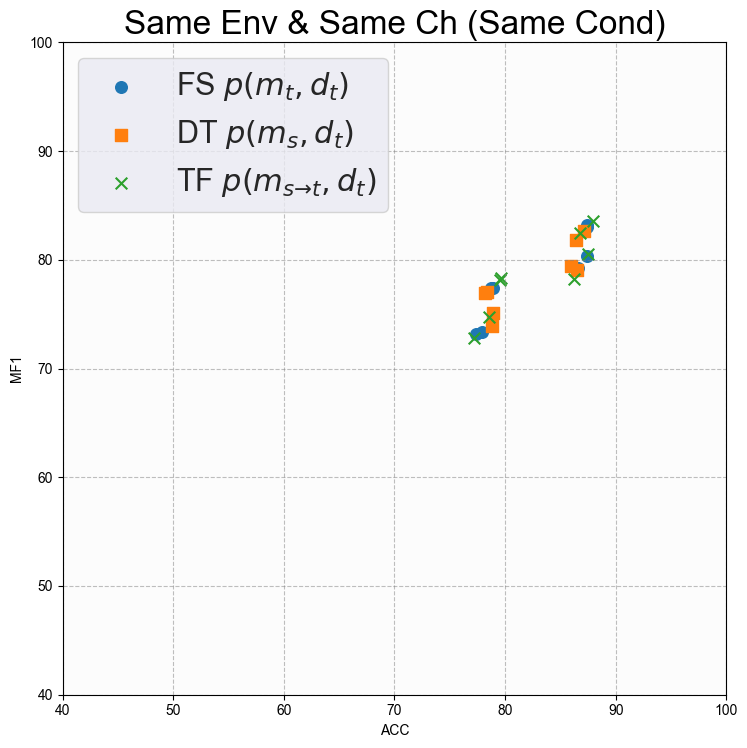

********************
Same Env & Same Ch (Diff Cond) (size=18)
FS_tgt80_pred_tgt20           : acc=86.9064, mf1=79.8314
DT_src80_pred_tgt20           : acc=86.7760, mf1=79.1541
TF_src80-to-tgt80_pred_tgt20  : acc=87.6769, mf1=80.4818
DT-FS_80: acc=0.0050 mf1=0.0133
DT-FS_80: acc=0.0015 mf1=0.0086


source_dataset source_channel target_dataset target_channel  acc_type3  \
629   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  87.218118   
630   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  85.803849   
631   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
632   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
633   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
634   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
635   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
636   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
637   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.746695   
656      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.070807   
657      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  87.449216   
658      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
659      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
660      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
661      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
662      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
663      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
664      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  87.154188   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  acc_r_ij  mf1_r_ij  
629  79.839398  87.431960  80.422640  88.608087  80.934385  0.002452  0.007305  
630  77.668711  87.295879  80.075945  88.374806  81.700415  0.017389  0.030994  
631  79.061587  87.193818  80.419004  88.029743  81.083771  0.002627  0.017169  
632  79.061587  87.193818  80.419004  88.486586  81.255893  0.002627  0.017169  
633  79.061587  87.193818  80.419004  88.423406  81.146214  0.002627  0.017169  
634  79.061587  87.193818  80.419004  88.666407  81.793364  0.002627  0.017169  
635  79.061587  87.193818  80.419004  87.543740  79.990055  0.002627  0.017169  
636  79.061587  87.193818  80.419004  88.301905  81.323471  0.002627  0.017169  
637  79.166176  87.976283  81.183347  87.908243  80.525126  0.014174  0.025480  
656  79.550299  86.264268  78.469273  87.429870  80.038304  0.002248 -0.013589  
657  80.276658  85.456568  78.780962  87.062294  80.367359 -0.022786 -0.018632  
658  79.053765  86.718901  79.451464  86.573805  79.379511  0.001117  0.005031  
659  79.053765  86.718901  79.451464  86.090153  77.774164  0.001117  0.005031  
660  79.053765  86.718901  79.451464  86.994583  79.360597  0.001117  0.005031  
661  79.053765  86.718901  79.451464  87.299284  80.335190  0.001117  0.005031  
662  79.053765  86.718901  79.451464  87.284775  80.093725  0.001117  0.005031  
663  79.053765  86.718901  79.451464  87.691043  80.992865  0.001117  0.005031  
664  79.580589  86.414200  78.809730  87.415361  80.578683 -0.008491 -0.009687

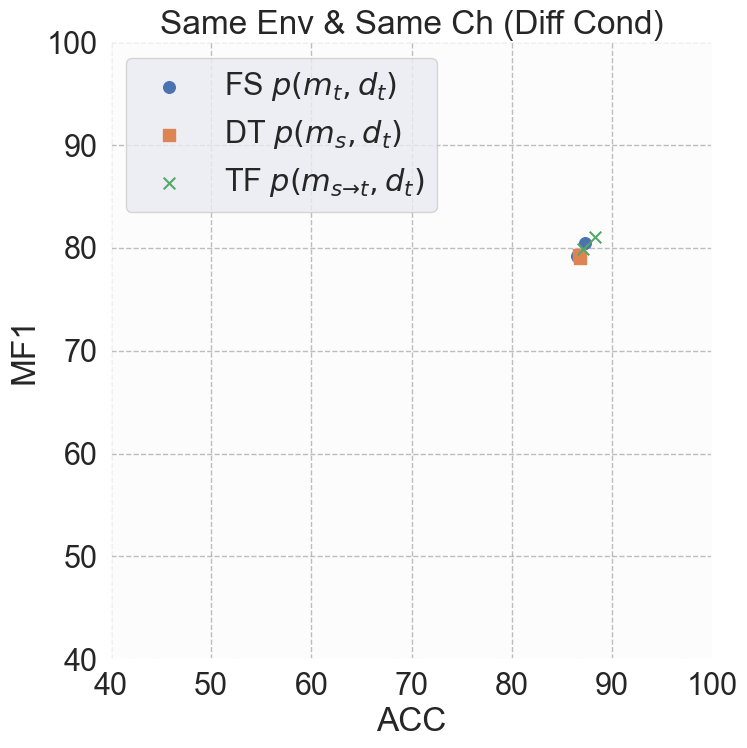

********************
Same Env & Diff Ch (Same Cond) (size=63)
FS_tgt80_pred_tgt20           : acc=82.4591, mf1=78.7202
DT_src80_pred_tgt20           : acc=77.9289, mf1=73.7268
TF_src80-to-tgt80_pred_tgt20  : acc=82.2775, mf1=78.5242
DT-FS_80: acc=0.0633 mf1=0.0735
DT-FS_80: acc=0.0622 mf1=0.0728


source_dataset source_channel target_dataset target_channel  acc_type3  \
8         mass_ss1         eeg_pz       mass_ss1         eeg_c4  77.348492   
9         mass_ss1         eeg_pz       mass_ss1         eeg_c4  77.184700   
10        mass_ss1         eeg_pz       mass_ss1         eeg_c4  77.184700   
11        mass_ss1         eeg_pz       mass_ss1         eeg_c4  78.071105   
68        mass_ss3         eeg_f4       mass_ss3         eeg_c4  82.072208   
..             ...            ...            ...            ...        ...   
457       mass_ss1         eeg_o2       mass_ss1         eeg_f4  60.208113   
458       mass_ss1         eeg_o2       mass_ss1         eeg_f4  61.768957   
468       mass_ss1         eeg_pz       mass_ss1         eeg_f4  72.694865   
469       mass_ss1         eeg_pz       mass_ss1         eeg_f4  70.633009   
470       mass_ss1         eeg_pz       mass_ss1         eeg_f4  70.363233   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  acc_r_ij  mf1_r_ij  
8    71.842793  77.762790  73.142747  77.396666  72.621494  0.005356  0.018094  
9    72.160834  77.704981  72.974233  78.572117  73.592951  0.006741  0.011272  
10   72.160834  77.704981  72.974233  78.128914  73.012390  0.006741  0.011272  
11   72.589521  78.051835  73.575257  78.013296  73.883454 -0.000247  0.013580  
68   77.092332  88.583341  84.158643  88.281735  83.863446  0.079334  0.091660  
..         ...        ...        ...        ...        ...       ...       ...  
457  55.928951  77.656807  73.112950  77.107621  72.725173  0.289806  0.307247  
458  58.751472  78.803353  74.723741  76.500626  72.819082  0.275776  0.271862  
468  67.992953  77.358127  72.713418  77.531554  73.353895  0.064148  0.069426  
469  65.440792  76.664419  72.658891  77.387032  73.032424  0.085391  0.110300  
470  65.756988  77.676077  73.801432  77.868773  73.482416  0.103930  0.122336  

[63 rows x 12 columns]

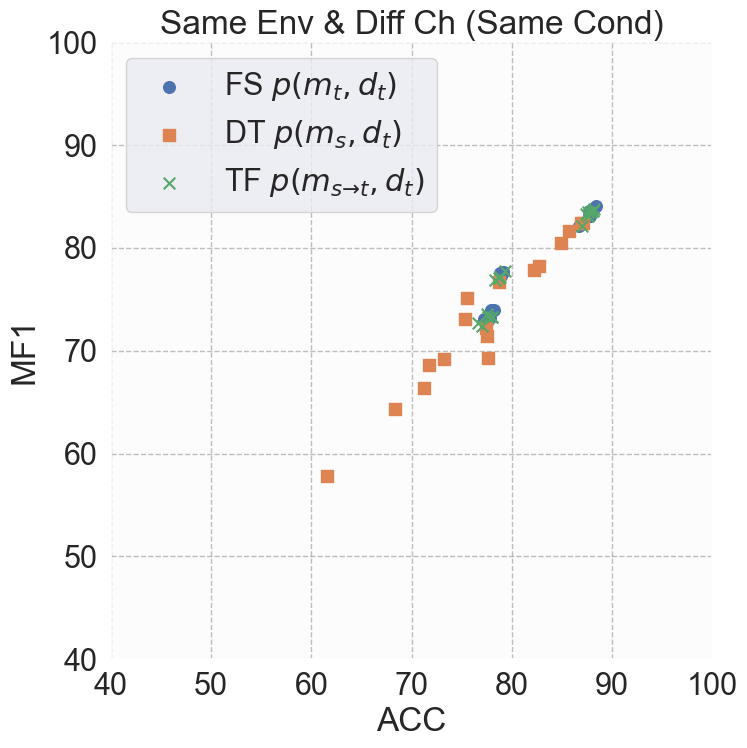

********************
Diff Env & Same Ch (Same Cond) (size=49)
FS_tgt80_pred_tgt20           : acc=84.0219, mf1=79.2044
DT_src80_pred_tgt20           : acc=73.9009, mf1=67.9518
TF_src80-to-tgt80_pred_tgt20  : acc=84.5169, mf1=79.8792
DT-FS_80: acc=0.1460 mf1=0.1787
DT-FS_80: acc=0.1453 mf1=0.1781


source_dataset source_channel target_dataset target_channel  acc_type3  \
56        mass_ss3         eeg_c4       mass_ss1         eeg_c4  73.802871   
57        mass_ss3         eeg_c4       mass_ss1         eeg_c4  73.147702   
58        mass_ss3         eeg_c4       mass_ss1         eeg_c4  73.147702   
59        mass_ss3         eeg_c4       mass_ss1         eeg_c4  73.186241   
200       mass_ss3         eeg_f4       sleepedf     eeg_fpz_cz  80.227560   
201       mass_ss3         eeg_f4       sleepedf     eeg_fpz_cz  77.673831   
202       mass_ss3         eeg_f4       sleepedf     eeg_fpz_cz  77.673831   
203       mass_ss3         eeg_f4       sleepedf     eeg_fpz_cz  71.327434   
208       mass_ss3         eeg_f4       mass_ss1         eeg_f4  74.332787   
209       mass_ss3         eeg_f4       mass_ss1         eeg_f4  73.234416   
210       mass_ss3         eeg_f4       mass_ss1         eeg_f4  73.234416   
211       mass_ss3         eeg_f4       mass_ss1         eeg_f4  73.851045   
334       mass_ss1         eeg_c4       mass_ss3         eeg_c4  87.119666   
335       mass_ss1         eeg_c4       mass_ss3         eeg_c4  85.487448   
336       mass_ss1         eeg_c4       mass_ss3         eeg_c4  86.427748   
353       sleepedf     eeg_fpz_cz       mass_ss1         eeg_f4  59.832354   
354       sleepedf     eeg_fpz_cz       mass_ss1         eeg_f4  61.200501   
355       sleepedf     eeg_fpz_cz       mass_ss1         eeg_f4  61.200501   
356       sleepedf     eeg_fpz_cz       mass_ss1         eeg_f4  69.149244   
357       sleepedf     eeg_fpz_cz       mass_ss3         eeg_f4  70.052337   
358       sleepedf     eeg_fpz_cz       mass_ss3         eeg_f4  75.995742   
359       sleepedf     eeg_fpz_cz       mass_ss3         eeg_f4  75.995742   
360       sleepedf     eeg_fpz_cz       mass_ss3         eeg_f4  80.732724   
441       mass_ss1         eeg_f4       sleepedf     eeg_fpz_cz  67.471555   
442       mass_ss1         eeg_f4       sleepedf     eeg_fpz_cz  69.974716   
443       mass_ss1         eeg_f4       sleepedf     eeg_fpz_cz  72.174463   
447       mass_ss1         eeg_f4       mass_ss3         eeg_f4  88.556728   
448       mass_ss1         eeg_f4       mass_ss3         eeg_f4  87.492238   
449       mass_ss1         eeg_f4       mass_ss3         eeg_f4  87.847068   
534          isruc      eeg_c4_a1      shhs1_osa      eeg_c4_a1  75.568624   
535          isruc      eeg_c4_a1      shhs1_osa      eeg_c4_a1  78.086120   
536          isruc      eeg_c4_a1      shhs1_osa      eeg_c4_a1  73.770412   
547       mass_ss1         eeg_c4   shhs1_normal      eeg_c4_a1  72.518862   
548       mass_ss1         eeg_c4   shhs1_normal      eeg_c4_a1  72.644612   
549       mass_ss1         eeg_c4   shhs1_normal      eeg_c4_a1  70.980847   
550       mass_ss1         eeg_c4   shhs1_normal      eeg_c4_a1  70.980847   
551       mass_ss1         eeg_c4   shhs1_normal      eeg_c4_a1  70.980847   
593       mass_ss3         eeg_c4   shhs1_normal      eeg_c4_a1  67.498549   
594       mass_ss3         eeg_c4   shhs1_normal      eeg_c4_a1  66.782743   
595       mass_ss3         eeg_c4   shhs1_normal      eeg_c4_a1  66.661830   
623   shhs1_normal      eeg_c4_a1       mass_ss1         eeg_c4  69.563542   
624   shhs1_normal      eeg_c4_a1       mass_ss1         eeg_c4  69.669525   
625   shhs1_normal      eeg_c4_a1       mass_ss1         eeg_c4  68.388091   
626   shhs1_normal      eeg_c4_a1       mass_ss3         eeg_c4  84.343121   
627   shhs1_normal      eeg_c4_a1       mass_ss3         eeg_c4  79.987581   
628   shhs1_normal      eeg_c4_a1       mass_ss3         eeg_c4  82.134303   
647      shhs1_osa      eeg_c4_a1          isruc      eeg_c4_a1  66.447368   
648      shhs1_osa      eeg_c4_a1          isruc      eeg_c4_a1  67.693293   
649      shhs1_osa      eeg_c4_a1          isruc      eeg_c4_a1  64.892874   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  acc_r_ij  mf1_r_ij  
56   66.411656  77.348

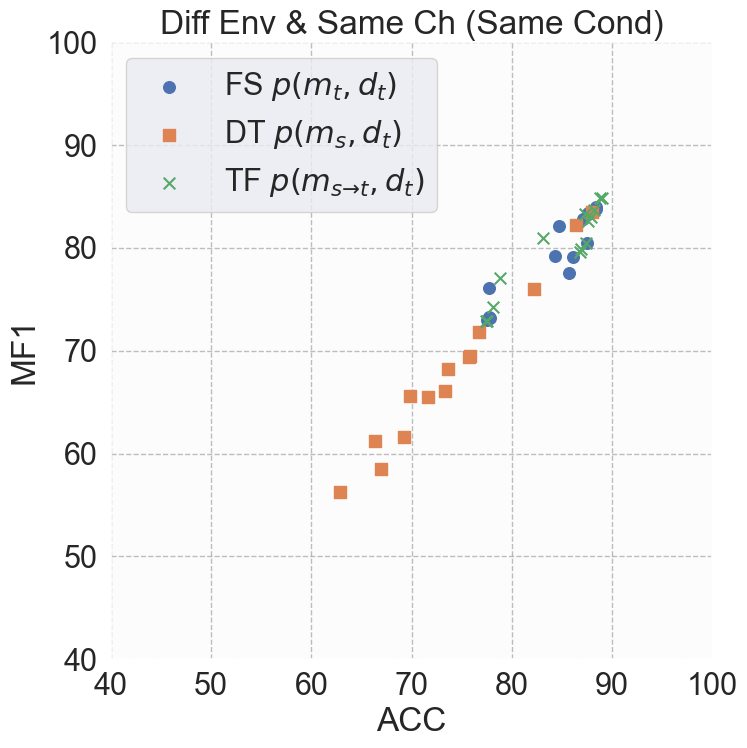

********************
Diff Env & Same Ch (Diff Cond) (size=73)
FS_tgt80_pred_tgt20           : acc=83.5456, mf1=78.9321
DT_src80_pred_tgt20           : acc=73.2672, mf1=68.1126
TF_src80-to-tgt80_pred_tgt20  : acc=83.9134, mf1=79.2435
DT-FS_80: acc=0.1583 mf1=0.1802
DT-FS_80: acc=0.1574 mf1=0.1791


source_dataset source_channel target_dataset target_channel  acc_type3  \
52        mass_ss3         eeg_c4          isruc      eeg_c4_a1  63.623661   
53        mass_ss3         eeg_c4          isruc      eeg_c4_a1  62.593153   
54        mass_ss3         eeg_c4          isruc      eeg_c4_a1  62.593153   
55        mass_ss3         eeg_c4          isruc      eeg_c4_a1  63.163717   
204       mass_ss3         eeg_f4          isruc      eeg_f4_a1  61.382161   
..             ...            ...            ...            ...        ...   
660      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
661      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
662      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
663      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
664      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  87.154188   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  acc_r_ij  mf1_r_ij  
52   60.248834  79.308337  77.657874  80.006986  78.713039  0.246523  0.288952  
53   59.552264  78.807639  76.599765  79.261761  77.236773  0.259046  0.286261  
54   59.552264  78.807639  76.599765  79.954588  78.474143  0.259046  0.286261  
55   60.144169  79.418957  77.567198  78.103167  76.705763  0.257351  0.289688  
204  57.872386  78.749418  77.431913  79.494644  77.981213  0.282937  0.337977  
..         ...        ...        ...        ...        ...       ...       ...  
660  79.053765  86.718901  79.451464  86.994583  79.360597  0.001117  0.005031  
661  79.053765  86.718901  79.451464  87.299284  80.335190  0.001117  0.005031  
662  79.053765  86.718901  79.451464  87.284775  80.093725  0.001117  0.005031  
663  79.053765  86.718901  79.451464  87.691043  80.992865  0.001117  0.005031  
664  79.580589  86.414200  78.809730  87.415361  80.578683 -0.008491 -0.009687  

[73 rows x 12 columns]

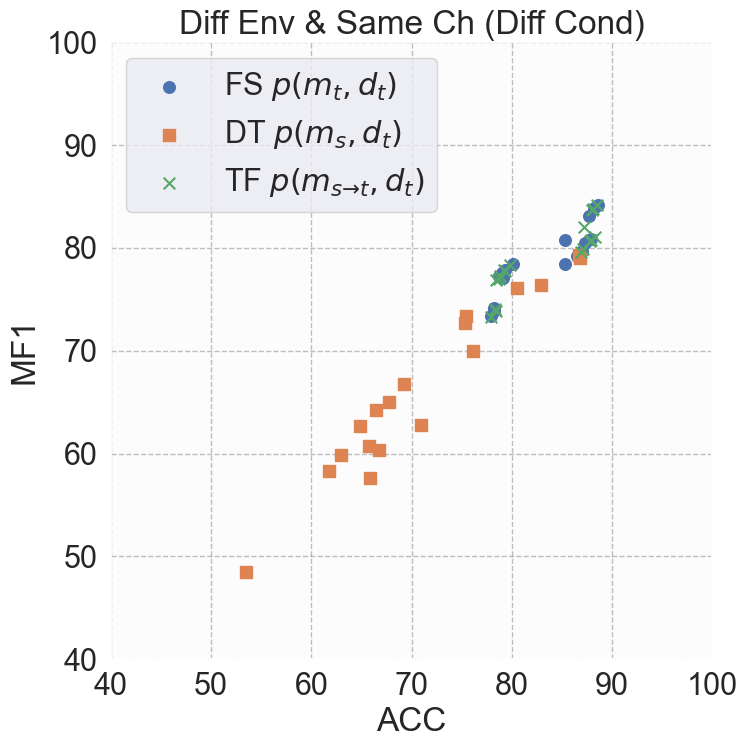

********************
Diff Env & Diff Ch (Same Cond) (size=135)
FS_tgt80_pred_tgt20           : acc=84.8977, mf1=79.9764
DT_src80_pred_tgt20           : acc=72.5474, mf1=66.0794
TF_src80-to-tgt80_pred_tgt20  : acc=85.0313, mf1=80.0610
DT-FS_80: acc=0.1785 mf1=0.2244
DT-FS_80: acc=0.1785 mf1=0.2242


source_dataset source_channel target_dataset target_channel  acc_type3  \
0         mass_ss1         eeg_o2       mass_ss3         eeg_c4  75.339306   
1         mass_ss1         eeg_o2       mass_ss3         eeg_c4  68.766078   
2         mass_ss1         eeg_o2       mass_ss3         eeg_c4  68.766078   
3         mass_ss1         eeg_o2       mass_ss3         eeg_c4  74.008693   
12        mass_ss1         eeg_pz       mass_ss3         eeg_c4  85.132618   
..             ...            ...            ...            ...        ...   
606       mass_ss3         eeg_o2   shhs1_normal      eeg_c4_a1  69.408977   
607       mass_ss3         eeg_o2   shhs1_normal      eeg_c4_a1  71.493519   
611       mass_ss3         eeg_pz   shhs1_normal      eeg_c4_a1  66.840782   
612       mass_ss3         eeg_pz   shhs1_normal      eeg_c4_a1  67.043916   
613       mass_ss3         eeg_pz   shhs1_normal      eeg_c4_a1  68.344941   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  acc_r_ij  mf1_r_ij  
0    72.891523  88.725273  84.206807  88.751885  84.670867  0.177676  0.155235  
1    65.654282  87.873680  83.474902  88.716402  84.490310  0.277864  0.271431  
2    65.654282  87.873680  83.474902  88.388184  84.224301  0.277864  0.271431  
3    70.847973  88.219640  83.987310  88.343830  84.022085  0.192017  0.185458  
12   80.917686  87.687395  83.069677  87.030959  82.881187  0.030009  0.026595  
..         ...        ...        ...        ...        ...       ...       ...  
606  61.531036  86.370671  79.053831  86.385181  78.893067  0.244373  0.284780  
607  65.271729  85.959567  79.378911  86.554459  79.408194  0.202341  0.216130  
611  56.634893  85.988586  79.091483  87.284775  80.139482  0.286469  0.396515  
612  56.737869  86.399690  78.248011  86.801122  79.994939  0.288703  0.379114  
613  58.939393  85.964403  77.774980  86.283614  79.584033  0.257802  0.319576  

[135 rows x 12 columns]

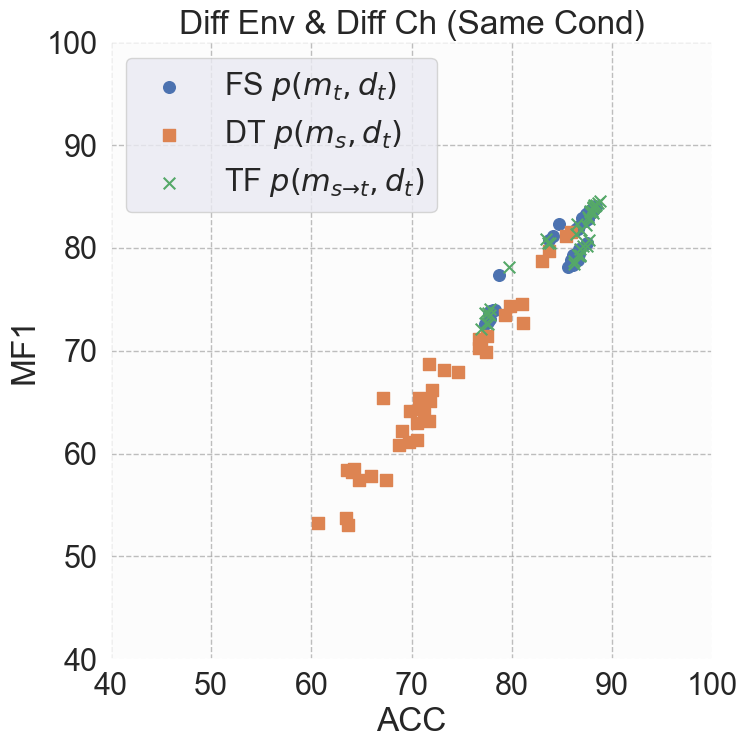

********************
Diff Env & Diff Ch (Diff Cond) (size=139)
FS_tgt80_pred_tgt20           : acc=82.6839, mf1=78.7622
DT_src80_pred_tgt20           : acc=66.3513, mf1=61.6561
TF_src80-to-tgt80_pred_tgt20  : acc=82.9463, mf1=78.9832
DT-FS_80: acc=0.2564 mf1=0.2922
DT-FS_80: acc=0.2562 mf1=0.2922


source_dataset source_channel target_dataset target_channel  acc_type3  \
4         mass_ss1         eeg_pz          isruc      eeg_c4_a1  61.492781   
5         mass_ss1         eeg_pz          isruc      eeg_c4_a1  63.809967   
6         mass_ss1         eeg_pz          isruc      eeg_c4_a1  63.809967   
7         mass_ss1         eeg_pz          isruc      eeg_c4_a1  63.181183   
60        mass_ss3         eeg_f4          isruc      eeg_c4_a1  60.171169   
..             ...            ...            ...            ...        ...   
609       mass_ss3         eeg_o2      shhs1_osa      eeg_c4_a1  66.922628   
610       mass_ss3         eeg_o2      shhs1_osa      eeg_c4_a1  68.934681   
614       mass_ss3         eeg_pz      shhs1_osa      eeg_c4_a1  63.656687   
615       mass_ss3         eeg_pz      shhs1_osa      eeg_c4_a1  66.261664   
616       mass_ss3         eeg_pz      shhs1_osa      eeg_c4_a1  64.750194   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  acc_r_ij  mf1_r_ij  
4    58.905852  79.471355  77.582962  79.884723  78.407611  0.292369  0.317067  
5    61.434389  79.215184  77.410723  79.925477  78.526756  0.241423  0.260055  
6    61.434389  79.215184  77.410723  80.798789  79.055923  0.241423  0.260055  
7    60.457664  78.010014  76.616870  80.333023  78.961381  0.234703  0.267281  
60   56.128179  79.873079  78.407841  79.389846  77.900585  0.327431  0.396943  
..         ...        ...        ...        ...        ...       ...       ...  
609  61.720249  88.472006  81.710051  87.461120  79.956707  0.322004  0.323878  
610  62.365683  87.315319  80.374693  87.825622  80.993840  0.266638  0.288765  
614  54.552523  87.529160  79.149008  87.713841  80.006374  0.375019  0.450877  
615  58.744382  88.491446  81.467001  87.947123  80.690417  0.335485  0.386805  
616  56.770145  87.509720  80.194010  87.670101  80.766959  0.351497  0.412609  

[139 rows x 12 columns]

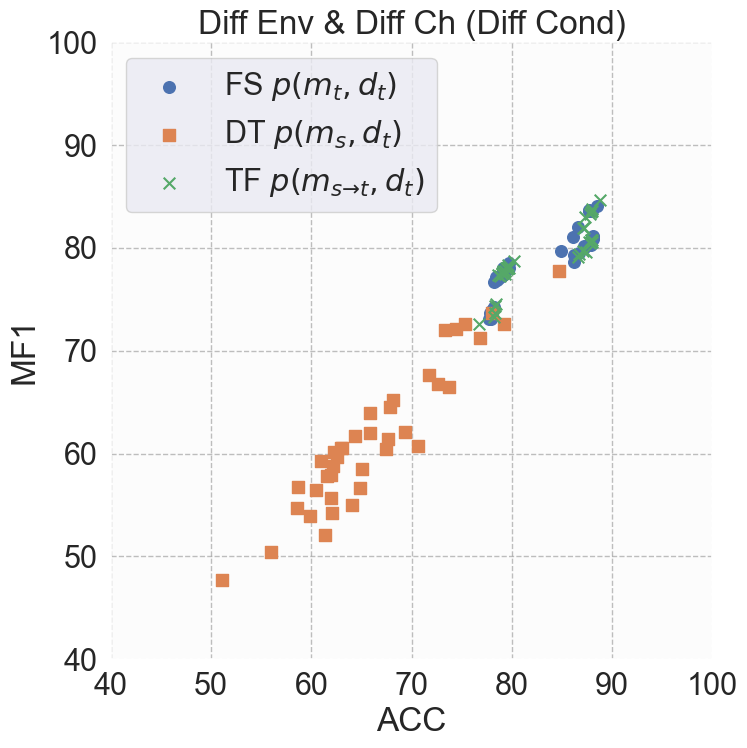

In [11]:
# For publication

# Mapping
type_map_pub = {
    # train on source
    'type3': r'DT $p(m_s,d_t)$',  # direct transfer
    # train on target
    'type6': r'FS $p(m_t,d_t)$',  # from scratch
    # transfer
    'type9': r'TF $p(m_{s \to t},d_t)$',  # transfer
}

marker_map = {
    # train on source
    'type3': "s",  # direct transfer
    # train on target
    'type6': "o",  # from scratch
    # transfer
    'type9': "x",  # transfer
}

def plot_acc_mf1(raw_df, types, title):
    df = raw_df.groupby(by=['source_dataset','source_channel','target_dataset','target_channel']).mean().reset_index()
    # df = raw_df
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    sns.set(font_scale=2)
    for t in types:
        acc = df[f'acc_type{t}'].values
        mf1 = df[f'mf1_type{t}'].values
        ax.scatter(
            acc, mf1, s=70,
            label=f'{type_map_pub[f"type{t}"]}',
            marker=marker_map[f"type{t}"])
    ax.set(facecolor='#FCFCFC')
    ax.set_xlabel('ACC')
    ax.set_ylabel('MF1')
    ax.grid(color='grey', linestyle='--', alpha=0.5)
    plt.xlim([40,100])
    plt.ylim([40,100])
    plt.title(f'{title}')
    plt.tight_layout()
    plt.legend(loc='upper left')
    plt.savefig(f'{title}.jpg', format='jpg', dpi=500, bbox_inches='tight')
    plt.show()
    plt.close('all')

# type6 / type3 : from scratch (80%) / direct transfer (80%)
t1 = 6
t2 = 3
types = [6,3,9]
exps = [
    # ('Same Env & Same Ch (Healthy)', same_d_same_c_healthy),
    # ('Same Env & Same Ch (Apnea)', same_d_same_c_apnea),
    # ('Same Env & Diff Ch (Healthy)', same_d_diff_c_healthy),
    # ('Same Env & Diff Ch (Apnea)', same_d_diff_c_apnea),
    ('Same Env & Same Ch (Same Cond)', same_d_same_c_same_cond),  # merge 1&2
    ('Same Env & Same Ch (Diff Cond)', same_d_same_c_diff_cond),  # new
    ('Same Env & Diff Ch (Same Cond)', same_d_diff_c_same_cond),  # merge 3&4
    # ('Same Env & Diff Ch (Diff Cond)', same_d_diff_c_diff_cond),  # dataset is not available
    ('Diff Env & Same Ch (Same Cond)', diff_d_same_c_same_cond),
    ('Diff Env & Same Ch (Diff Cond)', diff_d_same_c_diff_cond),
    ('Diff Env & Diff Ch (Same Cond)', diff_d_diff_c_same_cond),
    ('Diff Env & Diff Ch (Diff Cond)', diff_d_diff_c_diff_cond),
]

r_ijs = {}
for title, filter_fn in exps:
    print('*'*20)
    _df = df[df.apply(filter_fn, axis=1)]
    _df = _df[_df['source_dataset'].isin(db_30s)]  ## ** NEW Only use 30s epoch **
    print(f'{title} (size={len(_df)})')
    for t in types:
        accs = _df[f'acc_type{t}'].values
        mf1s = _df[f'mf1_type{t}'].values
        print(f'{type_map[f"type{t}"]:30s}: acc={np.mean(accs):.4f}, mf1={np.mean(mf1s):.4f}')
    # gain_pc_acc = (_df[f'acc_type6'].values - _df[f'acc_type3'].values) / _df[f'acc_type3'].values
    # gain_pc_mf1 = (_df[f'mf1_type6'].values - _df[f'mf1_type3'].values) / _df[f'mf1_type3'].values
    gain_pc_acc = (_df[f'acc_type{t1}'].values / _df[f'acc_type{t2}'].values) - 1
    gain_pc_mf1 = (_df[f'mf1_type{t1}'].values / _df[f'mf1_type{t2}'].values) - 1
    # print(np.abs(gain_pc))
    print(f'DT-FS_80: acc={np.mean(np.abs(gain_pc_acc)):.4f} mf1={np.mean(np.abs(gain_pc_mf1)):.4f}')
    print(f'DT-FS_80: acc={np.mean(gain_pc_acc):.4f} mf1={np.mean(gain_pc_mf1):.4f}')
    _df['acc_r_ij'] = gain_pc_acc
    _df['mf1_r_ij'] = gain_pc_mf1
    display(_df)
    plot_acc_mf1(_df, types, title)
    r_ijs[title] = _df

In [12]:
df_30s = df[df['source_dataset'].isin(db_30s)].groupby(by=['source_dataset','source_channel','target_dataset','target_channel']).mean().reset_index()
df_20s = df[df['source_dataset'].isin(db_20s)].groupby(by=['source_dataset','source_channel','target_dataset','target_channel']).mean().reset_index()
display(df.shape)
display(df.groupby(by=['source_dataset','source_channel','target_dataset','target_channel']).mean().reset_index().shape)
display(df_30s.shape)
display(df_20s.shape)

(665, 10)

(184, 10)

(134, 10)

(50, 10)

In [13]:
pretrain_comb_30s_df = df[df['source_dataset'].isin(db_30s)][['source_dataset','source_channel']].drop_duplicates()
pretrain_comb_20s_df = df[df['source_dataset'].isin(db_20s)][['source_dataset','source_channel']].drop_duplicates()
display(df[['source_dataset','source_channel']].drop_duplicates().shape)
display(pretrain_comb_30s_df.shape)
display(pretrain_comb_20s_df.shape)

(38, 2)

(23, 2)

(15, 2)

In [14]:
tf_settings = list(r_ijs.keys())
for _ in tf_settings:
    print(_)

Same Env & Same Ch (Same Cond)
Same Env & Same Ch (Diff Cond)
Same Env & Diff Ch (Same Cond)
Diff Env & Same Ch (Same Cond)
Diff Env & Same Ch (Diff Cond)
Diff Env & Diff Ch (Same Cond)
Diff Env & Diff Ch (Diff Cond)


In [15]:
sum_r_ijs = {}
for k in tf_settings:
    sum_acc = np.mean(np.abs(r_ijs[k]['acc_r_ij']))*100
    sum_mf1 = np.mean(np.abs(r_ijs[k]['mf1_r_ij']))*100
    sum_r_ijs[k] = {
        'acc': sum_acc,
        'mf1': sum_mf1
    }
    print(f"{k}:\tacc_r_ij={sum_acc:.2f}\tmf1_r_ij={sum_mf1:.2f}")
print(sum_r_ijs)

Same Env & Same Ch (Same Cond):	acc_r_ij=1.09	mf1_r_ij=1.23
Same Env & Same Ch (Diff Cond):	acc_r_ij=0.50	mf1_r_ij=1.33
Same Env & Diff Ch (Same Cond):	acc_r_ij=6.33	mf1_r_ij=7.35
Diff Env & Same Ch (Same Cond):	acc_r_ij=14.60	mf1_r_ij=17.87
Diff Env & Same Ch (Diff Cond):	acc_r_ij=15.83	mf1_r_ij=18.02
Diff Env & Diff Ch (Same Cond):	acc_r_ij=17.85	mf1_r_ij=22.44
Diff Env & Diff Ch (Diff Cond):	acc_r_ij=25.64	mf1_r_ij=29.22
{'Same Env & Same Ch (Same Cond)': {'acc': 1.0915799125409422, 'mf1': 1.2314672424323148}, 'Same Env & Same Ch (Diff Cond)': {'acc': 0.4999964305667897, 'mf1': 1.3271423240440152}, 'Same Env & Diff Ch (Same Cond)': {'acc': 6.329605262389522, 'mf1': 7.3538358182927395}, 'Diff Env & Same Ch (Same Cond)': {'acc': 14.599470710612358, 'mf1': 17.87370535429557}, 'Diff Env & Same Ch (Diff Cond)': {'acc': 15.830308534240235, 'mf1': 18.02448229622567}, 'Diff Env & Diff Ch (Same Cond)': {'acc': 17.850873228355052, 'mf1': 22.44110220250681}, 'Diff Env & Diff Ch (Diff Cond)': {

In [16]:
for k in tf_settings:
    sum_acc = np.mean(r_ijs[k]['acc_r_ij'])*100
    sum_mf1 = np.mean(r_ijs[k]['mf1_r_ij'])*100
    print(f"{k}:\tacc_r_ij={sum_acc:.2f}\tmf1_r_ij={sum_mf1:.2f}")

Same Env & Same Ch (Same Cond):	acc_r_ij=0.34	mf1_r_ij=0.38
Same Env & Same Ch (Diff Cond):	acc_r_ij=0.15	mf1_r_ij=0.86
Same Env & Diff Ch (Same Cond):	acc_r_ij=6.22	mf1_r_ij=7.28
Diff Env & Same Ch (Same Cond):	acc_r_ij=14.53	mf1_r_ij=17.81
Diff Env & Same Ch (Diff Cond):	acc_r_ij=15.74	mf1_r_ij=17.91
Diff Env & Diff Ch (Same Cond):	acc_r_ij=17.85	mf1_r_ij=22.42
Diff Env & Diff Ch (Diff Cond):	acc_r_ij=25.62	mf1_r_ij=29.22


In [17]:
for k in tf_settings:
    print(f"{k}:", end='\t')
    for t in [6,3,9]:
        accs = r_ijs[k][f'acc_type{t}'].values
        mf1s = r_ijs[k][f'mf1_type{t}'].values
        print(f'{np.mean(accs):.4f}\t{np.mean(mf1s):.4f}', end='\t')
    print()

Same Env & Same Ch (Same Cond):	83.3179	78.5563	83.0175	78.2399	83.4956	78.7638	
Same Env & Same Ch (Diff Cond):	86.9064	79.8314	86.7760	79.1541	87.6769	80.4818	
Same Env & Diff Ch (Same Cond):	82.4591	78.7202	77.9289	73.7268	82.2775	78.5242	
Diff Env & Same Ch (Same Cond):	84.0219	79.2044	73.9009	67.9518	84.5169	79.8792	
Diff Env & Same Ch (Diff Cond):	83.5456	78.9321	73.2672	68.1126	83.9134	79.2435	
Diff Env & Diff Ch (Same Cond):	84.8977	79.9764	72.5474	66.0794	85.0313	80.0610	
Diff Env & Diff Ch (Diff Cond):	82.6839	78.7622	66.3513	61.6561	82.9463	78.9832	


In [18]:
# Statistical Test
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro

compare_k = 'mf1_r_ij'
for k in tf_settings:
    vals = r_ijs[k][compare_k]
    stat, p = shapiro(vals)
    print(f"{k}: n={len(r_ijs[k][compare_k])} stat={stat:.4f}, p={p:.4f} ({'Not ' if p<=0.05 else ''}Gaussian)")
    if len(r_ijs[k][compare_k]) < 30:
        display(r_ijs[k])

p_mat = []
for k1 in tf_settings:
    row = []
    for k2 in tf_settings:
        stat, p = mannwhitneyu(np.abs(r_ijs[k1][compare_k]), np.abs(r_ijs[k2][compare_k]))
        print(f"{k1}-{k2}: stat={stat:.4f} p={p:.4f} ({'Same' if p>0.05 else 'Diff'} Distribution)")
        row.append(p)
    p_mat.append(row)
p_mat = np.array(p_mat)

Same Env & Same Ch (Same Cond): n=32 stat=0.8314, p=0.0002 (Not Gaussian)
Same Env & Same Ch (Diff Cond): n=18 stat=0.9162, p=0.1106 (Gaussian)


source_dataset source_channel target_dataset target_channel  acc_type3  \
629   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  87.218118   
630   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  85.803849   
631   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
632   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
633   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
634   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
635   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
636   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.965397   
637   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.746695   
656      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.070807   
657      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  87.449216   
658      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
659      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
660      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
661      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
662      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
663      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
664      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  87.154188   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  acc_r_ij  mf1_r_ij  
629  79.839398  87.431960  80.422640  88.608087  80.934385  0.002452  0.007305  
630  77.668711  87.295879  80.075945  88.374806  81.700415  0.017389  0.030994  
631  79.061587  87.193818  80.419004  88.029743  81.083771  0.002627  0.017169  
632  79.061587  87.193818  80.419004  88.486586  81.255893  0.002627  0.017169  
633  79.061587  87.193818  80.419004  88.423406  81.146214  0.002627  0.017169  
634  79.061587  87.193818  80.419004  88.666407  81.793364  0.002627  0.017169  
635  79.061587  87.193818  80.419004  87.543740  79.990055  0.002627  0.017169  
636  79.061587  87.193818  80.419004  88.301905  81.323471  0.002627  0.017169  
637  79.166176  87.976283  81.183347  87.908243  80.525126  0.014174  0.025480  
656  79.550299  86.264268  78.469273  87.429870  80.038304  0.002248 -0.013589  
657  80.276658  85.456568  78.780962  87.062294  80.367359 -0.022786 -0.018632  
658  79.053765  86.718901  79.451464  86.573805  79.379511  0.001117  0.005031  
659  79.053765  86.718901  79.451464  86.090153  77.774164  0.001117  0.005031  
660  79.053765  86.718901  79.451464  86.994583  79.360597  0.001117  0.005031  
661  79.053765  86.718901  79.451464  87.299284  80.335190  0.001117  0.005031  
662  79.053765  86.718901  79.451464  87.284775  80.093725  0.001117  0.005031  
663  79.053765  86.718901  79.451464  87.691043  80.992865  0.001117  0.005031  
664  79.580589  86.414200  78.809730  87.415361  80.578683 -0.008491 -0.009687

Same Env & Diff Ch (Same Cond): n=63 stat=0.8445, p=0.0000 (Not Gaussian)
Diff Env & Same Ch (Same Cond): n=49 stat=0.9222, p=0.0032 (Not Gaussian)
Diff Env & Same Ch (Diff Cond): n=73 stat=0.8998, p=0.0000 (Not Gaussian)
Diff Env & Diff Ch (Same Cond): n=135 stat=0.9560, p=0.0003 (Not Gaussian)
Diff Env & Diff Ch (Diff Cond): n=139 stat=0.9719, p=0.0058 (Not Gaussian)
Same Env & Same Ch (Same Cond)-Same Env & Same Ch (Same Cond): stat=512.0000 p=1.0000 (Same Distribution)
Same Env & Same Ch (Same Cond)-Same Env & Same Ch (Diff Cond): stat=243.0000 p=0.3674 (Same Distribution)
Same Env & Same Ch (Same Cond)-Same Env & Diff Ch (Same Cond): stat=191.0000 p=0.0000 (Diff Distribution)
Same Env & Same Ch (Same Cond)-Diff Env & Same Ch (Same Cond): stat=77.0000 p=0.0000 (Diff Distribution)
Same Env & Same Ch (Same Cond)-Diff Env & Same Ch (Diff Cond): stat=245.0000 p=0.0000 (Diff Distribution)
Same Env & Same Ch (Same Cond)-Diff Env & Diff Ch (Same Cond): stat=26.0000 p=0.0000 (Diff Distribu

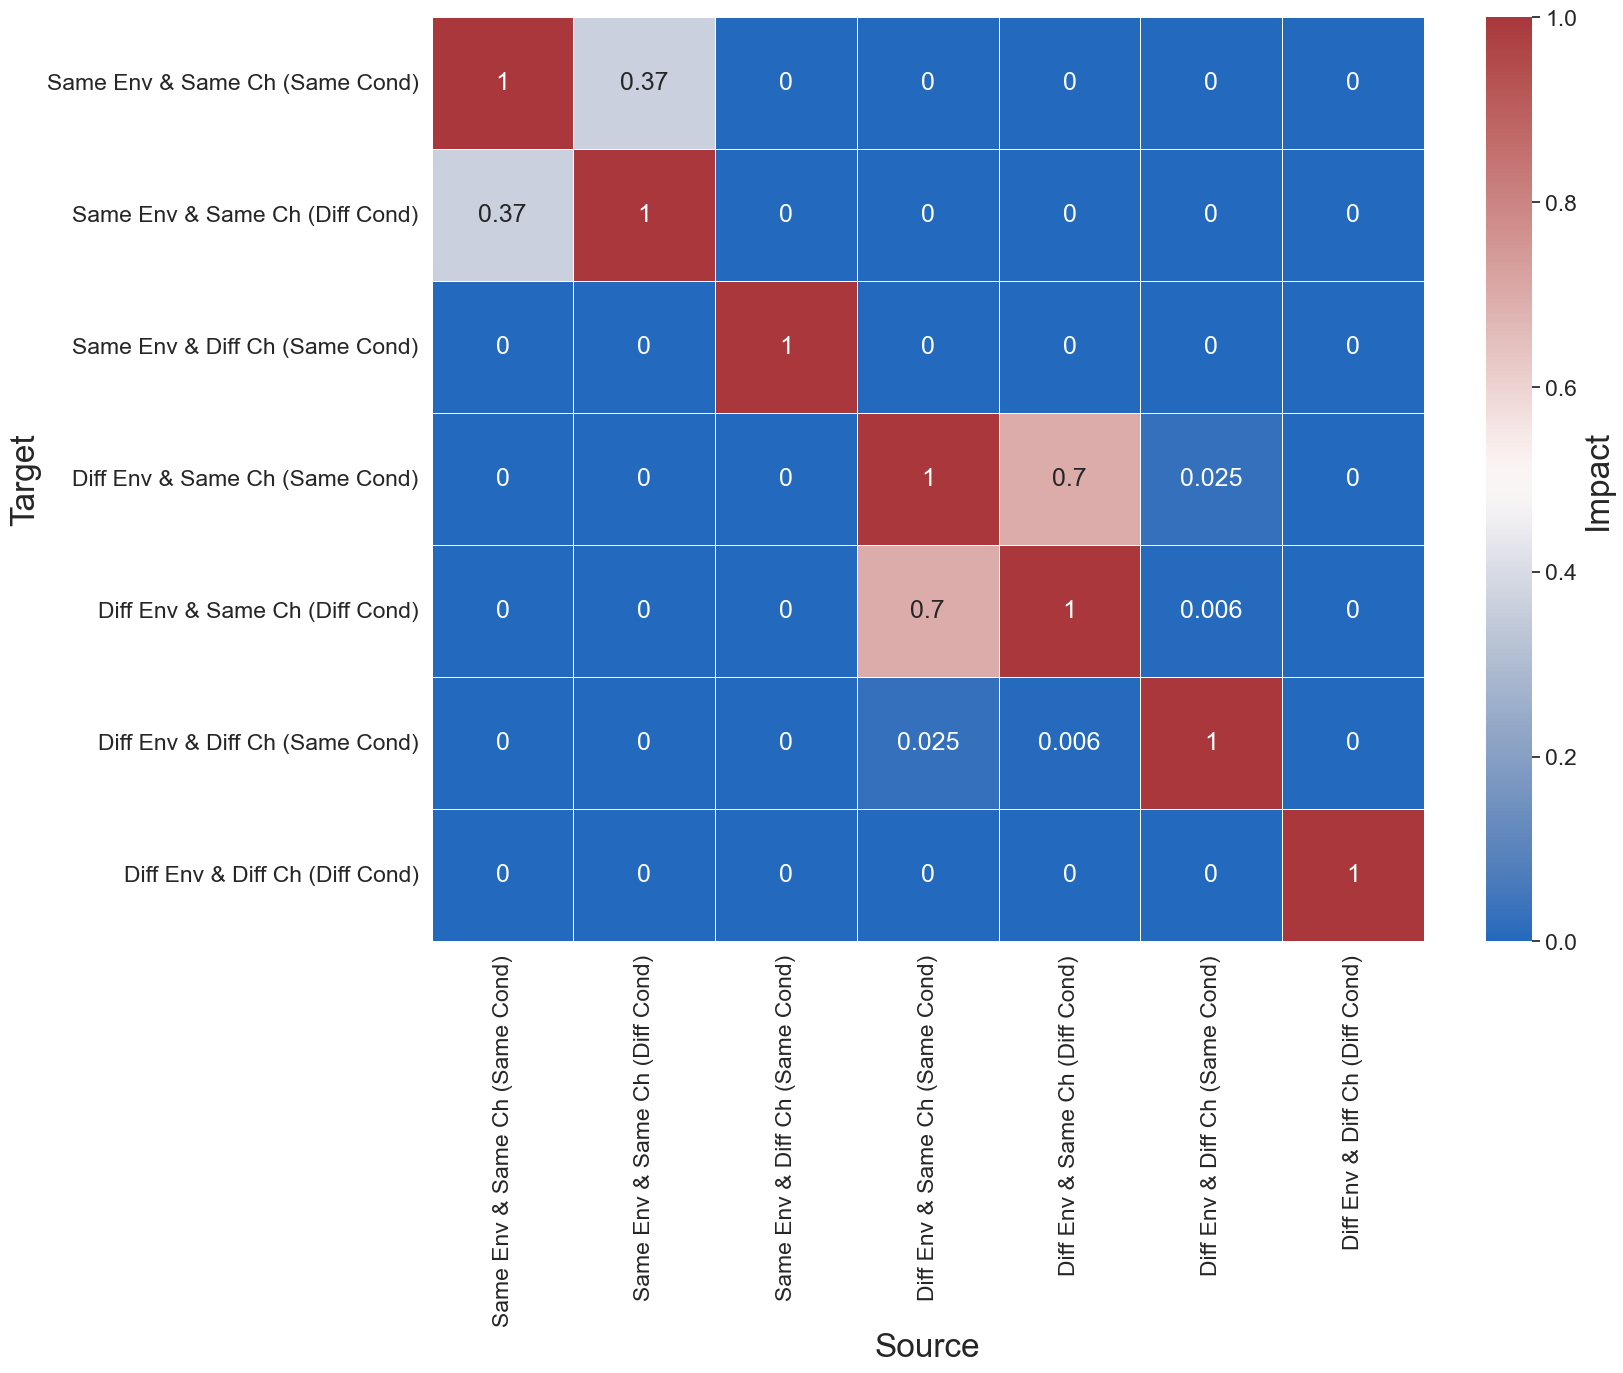

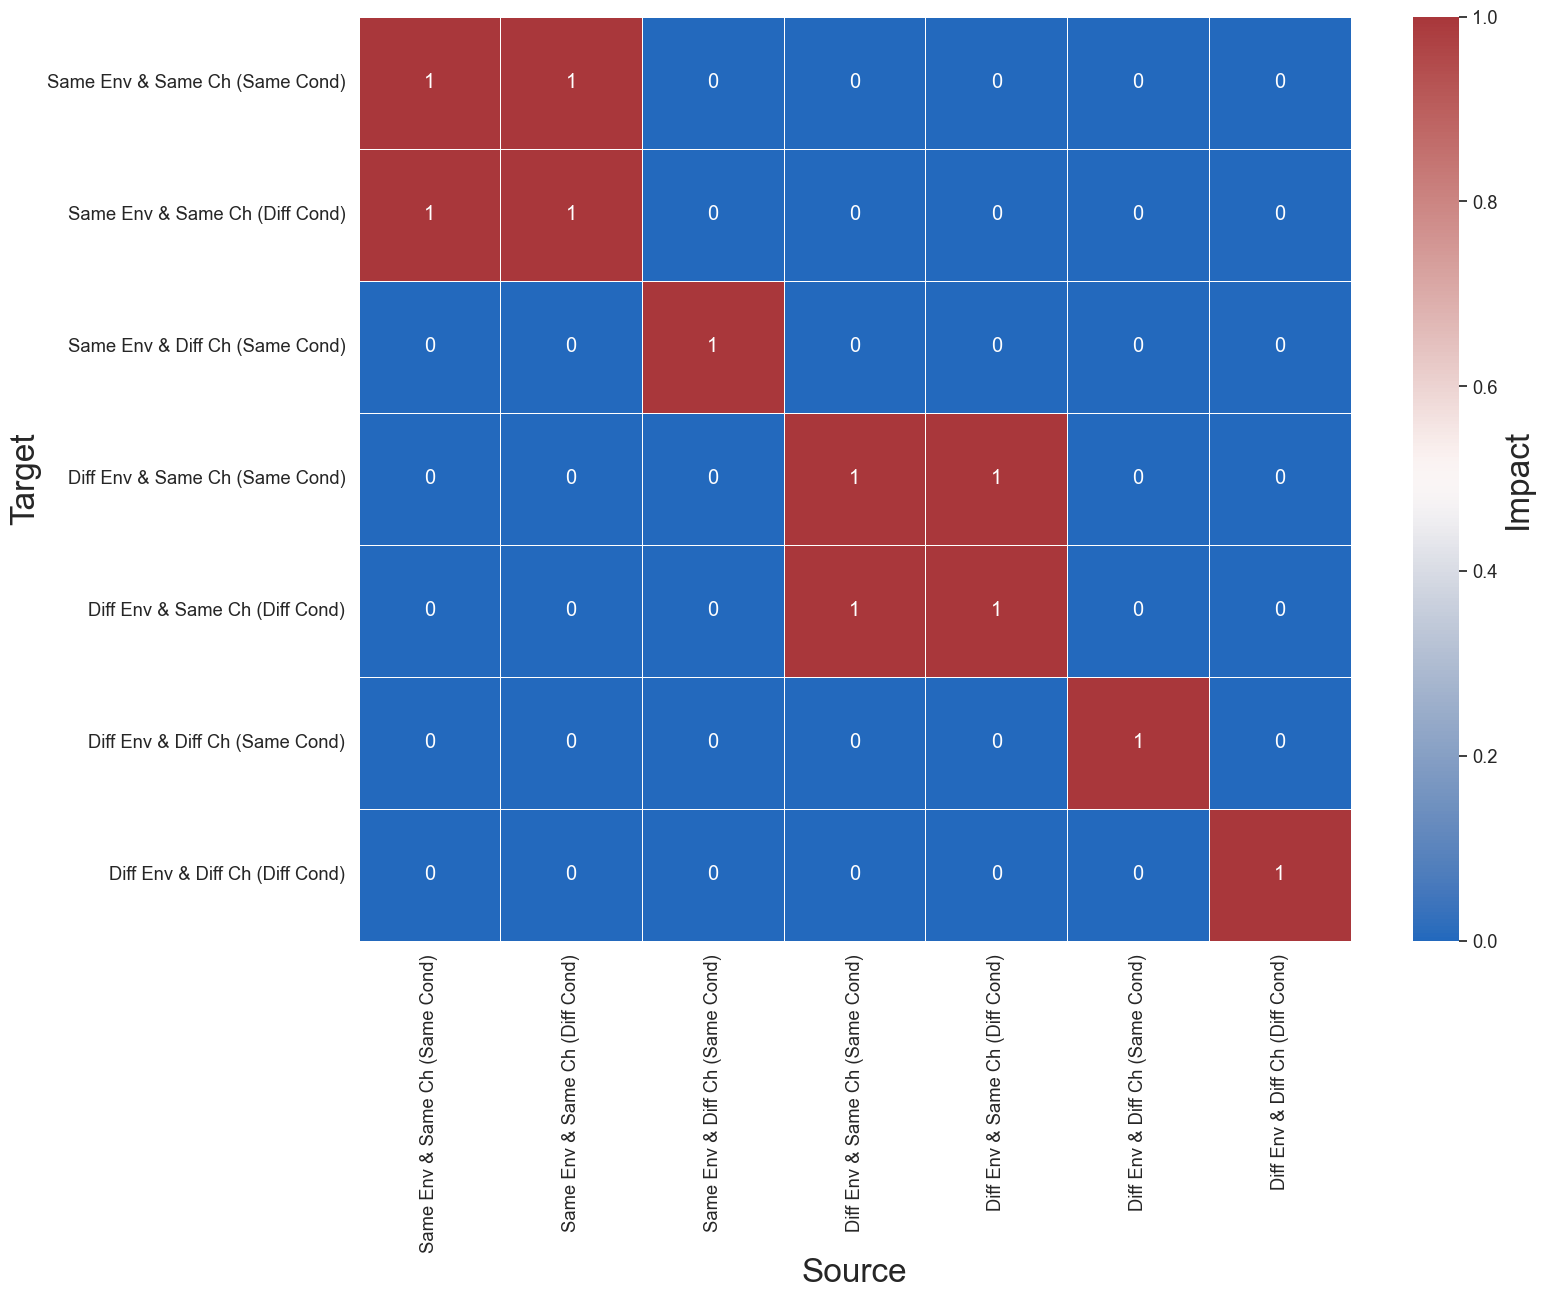

In [19]:
plt.figure(figsize=(16,12))
sns.set(font_scale=1.5)
ax = sns.heatmap(
    np.round(p_mat, 3),
    cmap='vlag',
    linewidths=.5,
    annot=True,
    xticklabels=r_ijs.keys(),
    yticklabels=r_ijs.keys(),
    cbar_kws={'label':'Impact'})
ax.figure.axes[-1].yaxis.label.set_size(24)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.ylabel('Target', fontsize=24)
plt.xlabel('Source', fontsize=24)
plt.show()

plt.figure(figsize=(16,12))
sns.set(font_scale=1.2)
ax = sns.heatmap(
    p_mat > 0.05,
    cmap='vlag',
    linewidths=.5,
    annot=True,
    xticklabels=r_ijs.keys(),
    yticklabels=r_ijs.keys(),
    cbar_kws={'label':'Impact'})
ax.figure.axes[-1].yaxis.label.set_size(24)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.ylabel('Target', fontsize=24)
plt.xlabel('Source', fontsize=24)
plt.show()

In [20]:
vals = []
for k in tf_settings:
    vals.append(sum_r_ijs[k]['mf1'])
    print(f"{k}: {sum_r_ijs[k]['mf1']}")
vals = np.array(vals)[:, np.newaxis]

sum_r_mat = np.concatenate((vals, p_mat), axis=1)
for r in range(sum_r_mat.shape[0]):
    for c in range(sum_r_mat.shape[1]):
        print(sum_r_mat[r,c], end='\t')
    print()

Same Env & Same Ch (Same Cond): 1.2314672424323148
Same Env & Same Ch (Diff Cond): 1.3271423240440152
Same Env & Diff Ch (Same Cond): 7.3538358182927395
Diff Env & Same Ch (Same Cond): 17.87370535429557
Diff Env & Same Ch (Diff Cond): 18.02448229622567
Diff Env & Diff Ch (Same Cond): 22.44110220250681
Diff Env & Diff Ch (Diff Cond): 29.223622037825535
1.2314672424323148	1.0	0.3673776872748279	1.27559240595764e-10	8.700401591607151e-12	1.3308065143029578e-10	4.113479545562117e-18	2.5225410460679283e-18	
1.3271423240440152	0.3673776872748279	1.0	4.123767745637053e-07	3.511449433337377e-08	8.727802188592474e-07	1.2846916504606385e-11	9.549902201616206e-12	
7.3538358182927395	1.27559240595764e-10	4.123767745637053e-07	1.0	1.3440713944785245e-06	0.00013163304495953426	3.1002386394662417e-16	1.450109716756096e-22	
17.87370535429557	8.700401591607151e-12	3.511449433337377e-08	1.3440713944785245e-06	1.0	0.699111550872396	0.024953245609071237	1.0332534207065211e-06	
18.02448229622567	1.33080651

# Transferability of DL model & Affinity Matrix

In [21]:
all_df = df.copy()
df = df.groupby(['source_dataset', 'source_channel', 'target_dataset', 'target_channel']).mean().reset_index()

display(all_df)
display(df)

source_dataset source_channel target_dataset target_channel  acc_type3  \
0         mass_ss1         eeg_o2       mass_ss3         eeg_c4  75.339306   
1         mass_ss1         eeg_o2       mass_ss3         eeg_c4  68.766078   
2         mass_ss1         eeg_o2       mass_ss3         eeg_c4  68.766078   
3         mass_ss1         eeg_o2       mass_ss3         eeg_c4  74.008693   
4         mass_ss1         eeg_pz          isruc      eeg_c4_a1  61.492781   
..             ...            ...            ...            ...        ...   
660      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
661      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
662      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
663      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.622171   
664      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  87.154188   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
0    72.891523  88.725273  84.206807  88.751885  84.670867  
1    65.654282  87.873680  83.474902  88.716402  84.490310  
2    65.654282  87.873680  83.474902  88.388184  84.224301  
3    70.847973  88.219640  83.987310  88.343830  84.022085  
4    58.905852  79.471355  77.582962  79.884723  78.407611  
..         ...        ...        ...        ...        ...  
660  79.053765  86.718901  79.451464  86.994583  79.360597  
661  79.053765  86.718901  79.451464  87.299284  80.335190  
662  79.053765  86.718901  79.451464  87.284775  80.093725  
663  79.053765  86.718901  79.451464  87.691043  80.992865  
664  79.580589  86.414200  78.809730  87.415361  80.578683  

[665 rows x 10 columns]

source_dataset source_channel target_dataset target_channel  acc_type3  \
0            isruc      eeg_c3_a2          isruc      eeg_c4_a1  78.320525   
1            isruc      eeg_c4_a1          isruc      eeg_f4_a1  78.662087   
2            isruc      eeg_c4_a1       mass_ss1         eeg_c4  69.261650   
3            isruc      eeg_c4_a1       mass_ss1         eeg_f4  65.868581   
4            isruc      eeg_c4_a1       mass_ss3         eeg_c4  75.454626   
..             ...            ...            ...            ...        ...   
179       sleepedf      eeg_pz_oz       mass_ss3         eeg_c4  76.746799   
180       sleepedf      eeg_pz_oz       mass_ss3         eeg_f4  69.788433   
181       sleepedf      eeg_pz_oz   shhs1_normal      eeg_c4_a1  70.529438   
182       sleepedf      eeg_pz_oz      shhs1_osa      eeg_c4_a1  70.627592   
183       sleepedf      eeg_pz_oz       sleepedf     eeg_fpz_cz  77.645386   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
0    77.073438  78.881385  77.360915  79.657662  78.352706  
1    76.676414  79.091465  77.706417  78.697019  77.117066  
2    66.762515  77.939429  73.342413  78.392266  73.882248  
3    63.913184  77.835052  73.637435  78.350515  74.340688  
4    73.420109  87.640084  83.140996  88.130932  83.746123  
..         ...        ...        ...        ...        ...  
179  71.122028  88.423667  83.996184  86.472101  82.299215  
180  64.118706  88.303912  84.111364  87.811585  83.490021  
181  61.332524  86.572193  78.841473  86.240085  78.431792  
182  60.708231  88.118844  81.129868  87.096617  79.738839  
183  69.309273  86.738306  82.168206  86.975348  82.115964  

[184 rows x 10 columns]

In [22]:
# type9 / type6 : transfer (80%) / from scratch (80%)
t1 = 9
t2 = 6
db_30s = ['mass_ss1','mass_ss3','sleepedf','isruc','shhs1_normal','shhs1_osa']
db_20s = ['mass_ss2','mass_ss4','mass_ss5']
chs = ['eeg_f','eeg_c','eeg_p','eeg_o']
print(f"{type_map[f'type{t1}']} / {type_map[f'type{t2}']}")
for tgt_ds in df['target_dataset'].unique():
    tgt_df = df[df['target_dataset'] == tgt_ds]
    # for tgt_ch in tgt_df['target_channel'].unique():
    for tgt_ch in sorted(tgt_df['target_channel'].unique(), key=cmp_to_key(compare)):
        tgt_ch_df = tgt_df[tgt_df['target_channel'] == tgt_ch].sort_values(by=['source_dataset','source_channel'])
        print(f"Target: {tgt_ds}-{tgt_ch}", end='\t')
        if tgt_ds in db_30s:
            list_ds = db_30s
        else:
            list_ds = db_20s
        for src_ds in list_ds:
            for src_ch in chs:
                perf = tgt_ch_df[(tgt_ch_df['source_dataset']==src_ds) & (tgt_ch_df['source_channel'].str.contains(src_ch))]
                if len(perf) == 0:
                    # print(f"  Source: {src_ds:10s}{src_ch:10s} -> NaN")
                    print('NaN', end='\t')
                elif len(perf) == 1:
                    perf = perf.iloc[0].to_dict()
                    acc = perf[f'acc_type{t1}'] / perf[f'acc_type{t2}']
                    mf1 = perf[f'mf1_type{t1}'] / perf[f'mf1_type{t2}']
                    # print(f"  Source: {perf['source_dataset']:10s}{perf['source_channel']:10s} -> acc={acc:.4f}, mf1={mf1:.4f}")
                    print(f'{mf1:.6f}', end='\t')
                else:
                    raise Exception(perf)
        print()
for src_ds in db_30s:
    for src_ch in chs:
        print(f'{src_ds}-{src_ch}', end='\t')
print()
for src_ds in db_20s:
    for src_ch in chs:
        print(f'{src_ds}-{src_ch}', end='\t')
print()

TF_src80-to-tgt80_pred_tgt20 / FS_tgt80_pred_tgt20
Target: isruc-eeg_f4_a1	1.006280	1.014309	0.999966	1.007534	0.995847	1.007326	0.995019	0.995916	0.980697	NaN	0.994229	NaN	1.009199	0.992416	NaN	0.992037	NaN	0.994169	NaN	NaN	NaN	1.010355	NaN	NaN	
Target: isruc-eeg_c4_a1	1.000514	1.000213	1.019191	1.006982	0.999814	1.008771	1.018040	0.999992	1.000562	NaN	1.002596	NaN	1.001792	1.012820	NaN	0.999290	NaN	1.004185	NaN	NaN	NaN	1.011709	NaN	NaN	
Target: mass_ss1-eeg_f4	1.021342	0.995900	1.003171	0.982998	1.012852	1.001327	0.996072	0.995621	0.984716	NaN	0.983214	NaN	0.998826	1.009550	NaN	0.977120	NaN	1.001870	NaN	NaN	NaN	1.008663	NaN	NaN	
Target: mass_ss1-eeg_c4	1.002841	0.993203	1.001516	0.994172	0.996780	0.995636	0.993312	0.995439	0.991386	NaN	0.996427	NaN	1.007465	1.007360	NaN	1.001738	NaN	0.999428	NaN	NaN	NaN	0.992052	NaN	NaN	
Target: mass_ss3-eeg_f4	1.018204	1.008837	1.004776	1.005188	0.990799	0.995557	0.994541	0.993747	0.998284	NaN	0.992613	NaN	1.003819	1.000399	NaN	0.993285	NaN	1.008068

TF_src80-to-tgt80_pred_tgt20 / FS_tgt80_pred_tgt20


source_dataset source_channel target_dataset target_channel  acc_type3  \
3            isruc      eeg_c4_a1       mass_ss1         eeg_f4  65.868581   
12           isruc      eeg_f4_a1       mass_ss1         eeg_f4  67.752192   
21           isruc      eeg_o2_a1       mass_ss1         eeg_f4  65.820407   
30        mass_ss1         eeg_c4       mass_ss1         eeg_f4  73.200694   
36        mass_ss1         eeg_f3       mass_ss1         eeg_f4  78.915759   
48        mass_ss1         eeg_o2       mass_ss1         eeg_f4  61.528086   
57        mass_ss1         eeg_pz       mass_ss1         eeg_f4  71.230369   
87        mass_ss3         eeg_c4       mass_ss1         eeg_f4  73.237627   
96        mass_ss3         eeg_f4       mass_ss1         eeg_f4  73.663166   
104       mass_ss3         eeg_o2       mass_ss1         eeg_f4  63.577898   
113       mass_ss3         eeg_pz       mass_ss1         eeg_f4  72.034878   
153   shhs1_normal      eeg_c4_a1       mass_ss1         eeg_f4  64.762180   
162      shhs1_osa      eeg_c4_a1       mass_ss1         eeg_f4  69.377268   
170       sleepedf     eeg_fpz_cz       mass_ss1         eeg_f4  62.845650   
178       sleepedf      eeg_pz_oz       mass_ss1         eeg_f4  60.660950   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
3    63.913184  77.835052  73.637435  78.350515  74.340688  
12   65.040891  78.251758  74.180950  78.290298  74.093828  
21   61.996013  78.203584  74.271932  76.671645  72.572577  
30   69.169301  77.885634  73.919366  77.490606  73.616299  
36   75.096227  77.351704  73.192452  78.559270  74.754538  
48   57.836605  78.167454  73.918942  76.600186  72.662136  
57   66.396911  77.232874  73.057914  77.595786  73.289578  
87   68.132638  77.753155  73.587684  77.293895  73.685326  
96   68.209045  77.726660  73.278117  78.136140  74.219868  
104  58.431625  77.820599  73.841134  77.806147  73.517791  
113  66.197341  78.290298  73.960146  77.574911  73.669630  
153  57.454275  78.144972  73.922177  77.855927  74.060392  
162  62.142116  77.974757  73.947410  78.437229  74.587981  
170  56.302091  84.683014  82.180323  83.071587  80.924238  
178  53.276912  84.685422  82.292027  83.428076  80.910696

Target: mass_ss1-eeg_f4
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

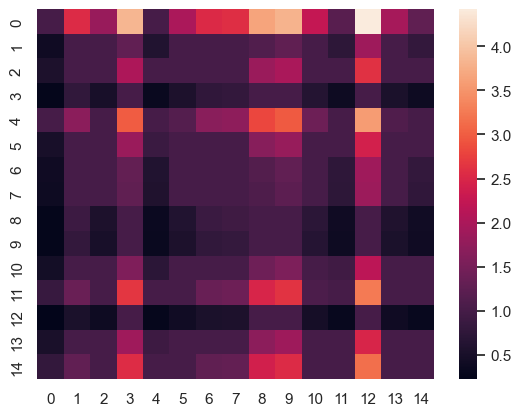

[0.13309372 0.05896044 0.07251831 0.03757419 0.09678365 0.06949503
 0.05929696 0.05842293 0.04060359 0.03792009 0.06528037 0.08580892
 0.03075157 0.0704014  0.08308886]


source_dataset source_channel target_dataset target_channel  acc_type3  \
2            isruc      eeg_c4_a1       mass_ss1         eeg_c4  69.261650   
11           isruc      eeg_f4_a1       mass_ss1         eeg_c4  68.163278   
20           isruc      eeg_o2_a1       mass_ss1         eeg_c4  67.864598   
27        mass_ss1         eeg_c3       mass_ss1         eeg_c4  78.820214   
39        mass_ss1         eeg_f4       mass_ss1         eeg_c4  77.467322   
47        mass_ss1         eeg_o2       mass_ss1         eeg_c4  68.339917   
56        mass_ss1         eeg_pz       mass_ss1         eeg_c4  77.447249   
86        mass_ss3         eeg_c4       mass_ss1         eeg_c4  73.321129   
95        mass_ss3         eeg_f4       mass_ss1         eeg_c4  69.720108   
103       mass_ss3         eeg_o2       mass_ss1         eeg_c4  70.738992   
112       mass_ss3         eeg_pz       mass_ss1         eeg_c4  71.743424   
152   shhs1_normal      eeg_c4_a1       mass_ss1         eeg_c4  69.207053   
161      shhs1_osa      eeg_c4_a1       mass_ss1         eeg_c4  70.922054   
169       sleepedf     eeg_fpz_cz       mass_ss1         eeg_c4  64.047596   
177       sleepedf      eeg_pz_oz       mass_ss1         eeg_c4  65.931207   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
2    66.762515  77.939429  73.342413  78.392266  73.882248  
11   65.245647  77.888043  73.126602  78.337669  73.672511  
20   64.516420  77.762790  73.124408  78.183512  73.251483  
27   73.915870  77.902495  73.344723  77.191926  72.846175  
39   71.464128  77.409513  73.048061  77.977968  73.255590  
47   64.333945  77.497832  72.790738  76.977551  72.366508  
56   72.188496  77.806147  73.166617  78.027748  73.277572  
86   66.101748  77.784469  73.174248  77.493015  72.854891  
95   61.166807  77.572502  72.847278  77.632720  72.612726  
103  65.388255  77.774834  73.073254  77.461702  72.739944  
112  63.145473  77.348492  72.615671  76.939011  72.130044  
152  61.627715  77.467322  72.982098  77.428782  72.940317  
161  62.811647  78.225263  73.893345  77.894466  73.306074  
169  58.245244  84.078428  81.140457  83.565372  80.441490  
177  57.787811  83.741208  80.806634  83.755660  80.517890

Target: mass_ss1-eeg_c4
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

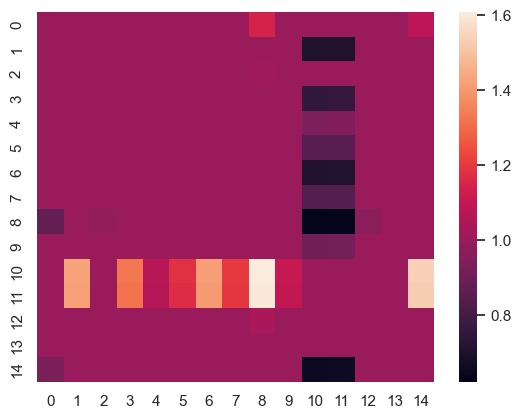

[0.0673842  0.06342327 0.06652026 0.0639525  0.06585596 0.06491688
 0.06347951 0.06477337 0.06182245 0.06554504 0.07854914 0.07814745
 0.06661024 0.06646711 0.06255263]


source_dataset source_channel target_dataset target_channel  acc_type3  \
5            isruc      eeg_c4_a1       mass_ss3         eeg_f4  73.361128   
14           isruc      eeg_f4_a1       mass_ss3         eeg_f4  75.319347   
23           isruc      eeg_o2_a1       mass_ss3         eeg_f4  71.737781   
32        mass_ss1         eeg_c4       mass_ss3         eeg_f4  83.737692   
41        mass_ss1         eeg_f4       mass_ss3         eeg_f4  87.965345   
50        mass_ss1         eeg_o2       mass_ss3         eeg_f4  67.178213   
59        mass_ss1         eeg_pz       mass_ss3         eeg_f4  83.033206   
88        mass_ss3         eeg_c4       mass_ss3         eeg_f4  86.864632   
92        mass_ss3         eeg_f3       mass_ss3         eeg_f4  87.113753   
106       mass_ss3         eeg_o2       mass_ss3         eeg_f4  82.710902   
115       mass_ss3         eeg_pz       mass_ss3         eeg_f4  87.119666   
155   shhs1_normal      eeg_c4_a1       mass_ss3         eeg_f4  77.409149   
164      shhs1_osa      eeg_c4_a1       mass_ss3         eeg_f4  79.257222   
172       sleepedf     eeg_fpz_cz       mass_ss3         eeg_f4  75.694136   
180       sleepedf      eeg_pz_oz       mass_ss3         eeg_f4  69.788433   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
5    72.015909  87.689612  83.712069  88.015613  83.745463  
14   72.732780  88.164198  83.844152  88.465803  84.164349  
23   67.631524  87.658565  83.578465  87.290428  83.017232  
32   79.739366  87.585381  83.196495  88.124279  83.931707  
41   83.537840  87.539549  83.336104  88.793282  84.853146  
50   65.367721  88.027440  83.754361  88.408883  84.188907  
59   78.732082  87.663739  83.560238  88.062923  83.959337  
88   82.432428  87.986783  83.645442  87.383571  83.273808  
92   82.689642  87.415358  83.202042  86.770750  82.436502  
106  78.239165  87.729531  83.611284  87.611993  83.088441  
115  82.401803  88.199681  83.921830  87.596469  83.463727  
155  69.919622  87.731748  83.498993  88.219640  84.172633  
164  72.606332  87.932819  83.621491  88.799196  84.620076  
172  69.380618  87.558769  83.399311  87.248292  83.256204  
180  64.118706  88.303912  84.111364  87.811585  83.490021

Target: mass_ss3-eeg_f4
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

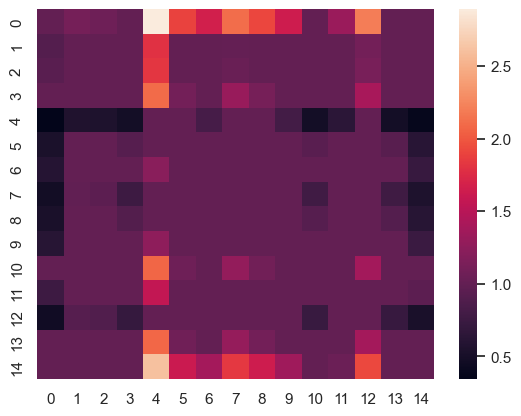

[0.09447679 0.06800754 0.06850794 0.07249321 0.04384201 0.06008683
 0.06275298 0.05682036 0.05974615 0.063001   0.07196429 0.06587208
 0.055204   0.0721427  0.08508211]


source_dataset source_channel target_dataset target_channel  acc_type3  \
4            isruc      eeg_c4_a1       mass_ss3         eeg_c4  75.454626   
13           isruc      eeg_f4_a1       mass_ss3         eeg_c4  74.413791   
22           isruc      eeg_o2_a1       mass_ss3         eeg_c4  75.368875   
31        mass_ss1         eeg_c4       mass_ss3         eeg_c4  86.344954   
40        mass_ss1         eeg_f4       mass_ss3         eeg_c4  85.845235   
49        mass_ss1         eeg_o2       mass_ss3         eeg_c4  71.720039   
58        mass_ss1         eeg_pz       mass_ss3         eeg_c4  85.378781   
83        mass_ss3         eeg_c3       mass_ss3         eeg_c4  86.436618   
97        mass_ss3         eeg_f4       mass_ss3         eeg_c4  82.229664   
105       mass_ss3         eeg_o2       mass_ss3         eeg_c4  85.653775   
114       mass_ss3         eeg_pz       mass_ss3         eeg_c4  84.926373   
154   shhs1_normal      eeg_c4_a1       mass_ss3         eeg_c4  82.155002   
163      shhs1_osa      eeg_c4_a1       mass_ss3         eeg_c4  82.870576   
171       sleepedf     eeg_fpz_cz       mass_ss3         eeg_c4  76.714273   
179       sleepedf      eeg_pz_oz       mass_ss3         eeg_c4  76.746799   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
4    73.420109  87.640084  83.140996  88.130932  83.746123  
13   72.096399  88.036311  83.585644  87.962388  83.587056  
22   72.573943  88.459150  84.097995  87.932819  83.514229  
31   82.214748  88.388184  83.970943  89.009137  84.877531  
40   81.580996  87.601644  82.822186  88.808066  84.600563  
49   68.762015  88.173068  83.785980  88.550075  84.351891  
58   81.207967  87.929123  83.432576  87.833762  83.594927  
83   81.865263  87.433100  83.035487  87.906207  83.538160  
97   77.849717  87.782755  83.063791  88.142021  83.768270  
105  81.641589  88.383749  84.040360  87.893640  83.469033  
114  80.457836  87.640823  83.080065  88.082143  83.637272  
154  75.979551  88.346787  83.836379  88.163458  83.709658  
163  76.370648  88.618824  84.159892  87.950560  83.672434  
171  70.254522  88.031136  83.474896  87.937993  83.603110  
179  71.122028  88.423667  83.996184  86.472101  82.299215

Target: mass_ss3-eeg_c4
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

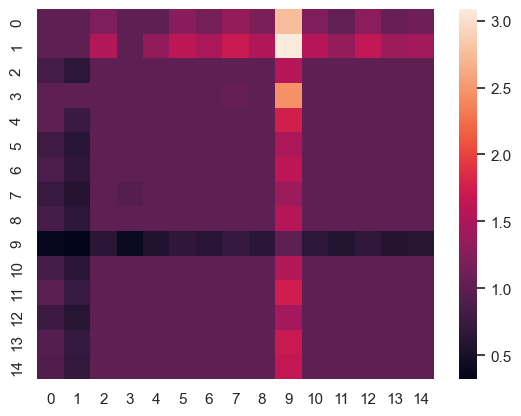

[0.07897909 0.09566383 0.06479832 0.07035981 0.06682929 0.06422579
 0.06525336 0.0633304  0.06488428 0.03866915 0.06471649 0.06655709
 0.06398499 0.06609631 0.06565179]


source_dataset source_channel target_dataset target_channel  acc_type3  \
8            isruc      eeg_c4_a1       sleepedf     eeg_fpz_cz  78.034134   
17           isruc      eeg_f4_a1       sleepedf     eeg_fpz_cz  80.458281   
26           isruc      eeg_o2_a1       sleepedf     eeg_fpz_cz  76.814159   
35        mass_ss1         eeg_c4       sleepedf     eeg_fpz_cz  77.550569   
44        mass_ss1         eeg_f4       sleepedf     eeg_fpz_cz  69.873578   
53        mass_ss1         eeg_o2       sleepedf     eeg_fpz_cz  70.581542   
62        mass_ss1         eeg_pz       sleepedf     eeg_fpz_cz  76.936367   
91        mass_ss3         eeg_c4       sleepedf     eeg_fpz_cz  79.759798   
100       mass_ss3         eeg_f4       sleepedf     eeg_fpz_cz  76.725664   
109       mass_ss3         eeg_o2       sleepedf     eeg_fpz_cz  79.304678   
118       mass_ss3         eeg_pz       sleepedf     eeg_fpz_cz  80.960809   
157   shhs1_normal      eeg_c4_a1       sleepedf     eeg_fpz_cz  81.129372   
166      shhs1_osa      eeg_c4_a1       sleepedf     eeg_fpz_cz  84.715550   
183       sleepedf      eeg_pz_oz       sleepedf     eeg_fpz_cz  77.645386   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
8    73.644386  86.052465  81.082653  87.101770  81.944060  
17   76.069508  85.331858  80.769823  87.152339  82.082955  
26   71.284205  86.618205  82.045768  87.199747  81.980108  
35   71.405684  87.275601  82.611578  87.585335  83.001893  
44   65.616928  87.083860  82.841527  87.867678  82.965807  
53   63.010094  86.970080  82.921687  86.906869  81.742408  
62   70.900783  86.354825  81.832943  87.404130  82.200533  
91   74.309059  87.560051  83.361141  88.301728  84.092643  
100  71.863443  84.317320  79.209509  87.566372  82.636822  
109  73.484041  86.567636  81.805893  86.422250  81.335487  
118  74.561265  86.725664  82.125038  87.708597  82.856080  
157  72.697500  87.366203  83.276739  88.112094  83.426881  
166  77.735710  84.909397  79.717432  87.812895  83.271564  
183  69.309273  86.738306  82.168206  86.975348  82.115964

Target: sleepedf-eeg_fpz_cz
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: 

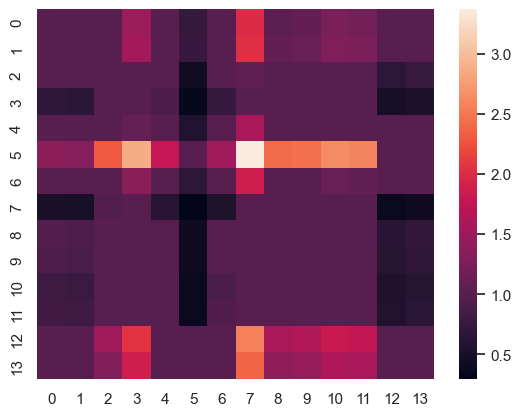

[0.07555309 0.07679619 0.06228306 0.05318826 0.06906461 0.12662589
 0.07249564 0.04693111 0.0606878  0.06002461 0.05709679 0.05785591
 0.09336789 0.08802915]


source_dataset source_channel target_dataset target_channel  acc_type3  \
1            isruc      eeg_c4_a1          isruc      eeg_f4_a1  78.662087   
9            isruc      eeg_f3_a2          isruc      eeg_f4_a1  78.142466   
19           isruc      eeg_o2_a1          isruc      eeg_f4_a1  71.749825   
29        mass_ss1         eeg_c4          isruc      eeg_f4_a1  62.115743   
38        mass_ss1         eeg_f4          isruc      eeg_f4_a1  64.867645   
46        mass_ss1         eeg_o2          isruc      eeg_f4_a1  59.833489   
55        mass_ss1         eeg_pz          isruc      eeg_f4_a1  61.601459   
85        mass_ss3         eeg_c4          isruc      eeg_f4_a1  62.529110   
94        mass_ss3         eeg_f4          isruc      eeg_f4_a1  61.730030   
102       mass_ss3         eeg_o2          isruc      eeg_f4_a1  58.638507   
111       mass_ss3         eeg_pz          isruc      eeg_f4_a1  60.990626   
151   shhs1_normal      eeg_c4_a1          isruc      eeg_f4_a1  62.005123   
160      shhs1_osa      eeg_c4_a1          isruc      eeg_f4_a1  64.266030   
168       sleepedf     eeg_fpz_cz          isruc      eeg_f4_a1  53.436481   
176       sleepedf      eeg_pz_oz          isruc      eeg_f4_a1  55.990918   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
1    76.676414  79.091465  77.706417  78.697019  77.117066  
9    76.939201  78.762517  77.417750  79.563053  78.129922  
19   68.570562  78.833838  77.541206  78.280741  76.923780  
29   58.756669  78.215242  76.676991  79.075454  77.774163  
38   62.645886  79.316100  77.841284  79.781866  78.330135  
46   53.897255  79.242354  77.467740  79.591678  78.051370  
55   57.801977  79.108446  78.015706  79.387906  78.013088  
85   59.669834  78.409797  77.183826  79.277286  77.749252  
94   58.325353  78.681008  77.311374  78.740685  76.990291  
102  56.719469  79.712972  78.511368  79.590708  78.190696  
111  59.251660  79.522299  78.108191  79.343270  77.719116  
151  55.665478  79.593619  77.968881  79.032759  77.514277  
160  58.546418  78.735833  77.356635  79.710061  78.157642  
168  48.484042  80.072485  78.441005  78.363705  76.926824  
176  50.461817  79.076910  77.787297  78.654809  77.338381

Target: isruc-eeg_f4_a1
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

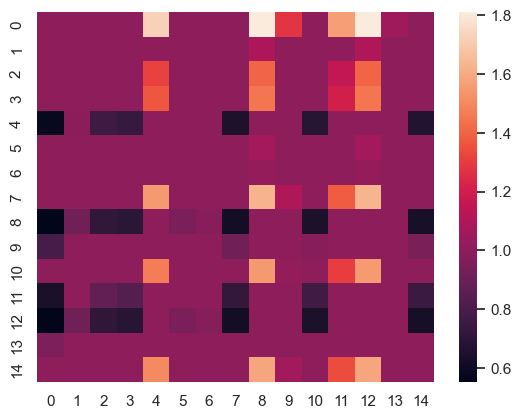

[0.07843106 0.06701485 0.07096645 0.07169681 0.05678718 0.06675156
 0.06647347 0.07477395 0.05507367 0.06443183 0.07327686 0.05930983
 0.05497924 0.06607354 0.07395971]


source_dataset source_channel target_dataset target_channel  acc_type3  \
0            isruc      eeg_c3_a2          isruc      eeg_c4_a1  78.320525   
10           isruc      eeg_f4_a1          isruc      eeg_c4_a1  75.512343   
18           isruc      eeg_o2_a1          isruc      eeg_c4_a1  75.368732   
28        mass_ss1         eeg_c4          isruc      eeg_c4_a1  66.400792   
37        mass_ss1         eeg_f4          isruc      eeg_c4_a1  62.286524   
45        mass_ss1         eeg_o2          isruc      eeg_c4_a1  61.989598   
54        mass_ss1         eeg_pz          isruc      eeg_c4_a1  63.073475   
84        mass_ss3         eeg_c4          isruc      eeg_c4_a1  62.993421   
93        mass_ss3         eeg_f4          isruc      eeg_c4_a1  60.409874   
101       mass_ss3         eeg_o2          isruc      eeg_c4_a1  64.376164   
110       mass_ss3         eeg_pz          isruc      eeg_c4_a1  62.916279   
150   shhs1_normal      eeg_c4_a1          isruc      eeg_c4_a1  65.715727   
159      shhs1_osa      eeg_c4_a1          isruc      eeg_c4_a1  66.344512   
167       sleepedf     eeg_fpz_cz          isruc      eeg_c4_a1  51.066896   
175       sleepedf      eeg_pz_oz          isruc      eeg_c4_a1  58.517699   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
0    77.073438  78.881385  77.360915  79.657662  78.352706  
10   75.109786  79.137556  77.665485  79.275345  77.804691  
18   73.094913  78.924080  77.227588  78.832868  77.172724  
28   64.260782  78.827045  77.242212  78.828986  77.258652  
37   60.197421  79.226828  77.494498  79.044403  77.534328  
45   57.875025  79.203540  77.514107  79.684832  78.055345  
54   60.558073  78.977934  77.255319  80.235503  78.737918  
84   59.874383  79.085643  77.106150  79.331626  77.782429  
93   56.480803  79.631463  77.989459  79.496099  77.974977  
101  61.720924  79.718794  78.033081  79.595075  78.032482  
110  60.556105  78.534001  76.931245  79.646018  78.319123  
150  60.730014  79.019174  77.525999  79.217125  77.850422  
159  61.253038  77.761605  76.140278  78.801816  77.031802  
167  47.729302  78.861493  77.393581  79.305426  77.437104  
175  54.684995  78.746507  77.103382  78.779984  77.303551

Target: isruc-eeg_c4_a1
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

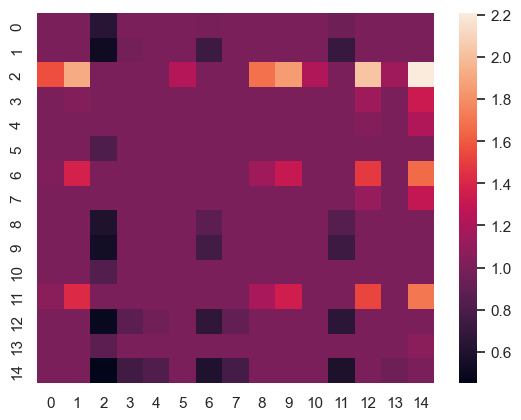

[0.06384182 0.06059472 0.08939647 0.06804502 0.06714961 0.06513186
 0.07386032 0.06770675 0.06254169 0.06113181 0.06524134 0.07489853
 0.05886201 0.06569486 0.0559032 ]


source_dataset source_channel target_dataset target_channel  acc_type3  \
6            isruc      eeg_c4_a1   shhs1_normal      eeg_c4_a1  76.155930   
15           isruc      eeg_f4_a1   shhs1_normal      eeg_c4_a1  72.667989   
24           isruc      eeg_o2_a1   shhs1_normal      eeg_c4_a1  73.744438   
33        mass_ss1         eeg_c4   shhs1_normal      eeg_c4_a1  71.621203   
42        mass_ss1         eeg_f4   shhs1_normal      eeg_c4_a1  68.748791   
51        mass_ss1         eeg_o2   shhs1_normal      eeg_c4_a1  71.256529   
60        mass_ss1         eeg_pz   shhs1_normal      eeg_c4_a1  69.073644   
89        mass_ss3         eeg_c4   shhs1_normal      eeg_c4_a1  66.981041   
98        mass_ss3         eeg_f4   shhs1_normal      eeg_c4_a1  63.432643   
107       mass_ss3         eeg_o2   shhs1_normal      eeg_c4_a1  71.158187   
116       mass_ss3         eeg_pz   shhs1_normal      eeg_c4_a1  67.409879   
149   shhs1_normal      eeg_c3_a2   shhs1_normal      eeg_c4_a1  85.998259   
165      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.711915   
173       sleepedf     eeg_fpz_cz   shhs1_normal      eeg_c4_a1  63.614819   
181       sleepedf      eeg_pz_oz   shhs1_normal      eeg_c4_a1  70.529438   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
6    69.958225  85.258270  78.481254  86.860773  79.595325  
15   66.784334  86.737441  79.528490  86.666505  79.457532  
24   66.465658  86.224608  78.594562  86.557361  79.116029  
33   65.469217  85.653898  77.580039  86.879474  79.861472  
42   60.819188  86.734620  79.889541  86.789031  79.194772  
51   63.892635  86.190108  78.934804  86.791449  79.363087  
60   62.241776  85.880570  78.808928  86.614110  79.311335  
89   58.545893  86.062746  79.135500  86.836590  79.559807  
98   53.746862  85.595215  78.140767  87.051009  80.144559  
107  64.317701  86.104662  79.358961  86.198169  78.767688  
116  57.437385  86.117560  78.371491  86.789837  79.906152  
149  79.413478  86.614110  79.205560  86.185271  78.230652  
165  79.303349  86.494271  79.196527  87.093463  79.880044  
173  53.081383  86.427097  79.410426  86.548011  79.338518  
181  61.332524  86.572193  78.841473  86.240085  78.431792

Target: shhs1_normal-eeg_c4_a1
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With sourc

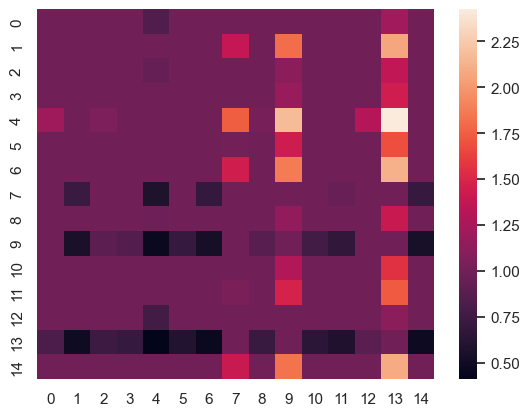

[0.066033   0.07350213 0.06743062 0.0681068  0.07970174 0.06965528
 0.0740782  0.05957814 0.06780658 0.05110881 0.06884276 0.07010821
 0.06541267 0.04489609 0.07373896]


source_dataset source_channel target_dataset target_channel  acc_type3  \
7            isruc      eeg_c4_a1      shhs1_osa      eeg_c4_a1  75.808385   
16           isruc      eeg_f4_a1      shhs1_osa      eeg_c4_a1  71.873056   
25           isruc      eeg_o2_a1      shhs1_osa      eeg_c4_a1  74.603421   
34        mass_ss1         eeg_c4      shhs1_osa      eeg_c4_a1  66.792622   
43        mass_ss1         eeg_f4      shhs1_osa      eeg_c4_a1  62.043157   
52        mass_ss1         eeg_o2      shhs1_osa      eeg_c4_a1  67.402151   
61        mass_ss1         eeg_pz      shhs1_osa      eeg_c4_a1  65.001296   
90        mass_ss3         eeg_c4      shhs1_osa      eeg_c4_a1  65.887442   
99        mass_ss3         eeg_f4      shhs1_osa      eeg_c4_a1  61.330353   
108       mass_ss3         eeg_o2      shhs1_osa      eeg_c4_a1  67.617613   
117       mass_ss3         eeg_pz      shhs1_osa      eeg_c4_a1  64.889515   
156   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.840116   
158      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.483713   
174       sleepedf     eeg_fpz_cz      shhs1_osa      eeg_c4_a1  64.058450   
182       sleepedf      eeg_pz_oz      shhs1_osa      eeg_c4_a1  70.627592   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
7    69.513147  87.524300  80.473380  87.388219  80.463921  
16   65.130677  87.500000  80.522238  87.728421  80.785382  
25   67.924698  86.695179  79.378936  87.502916  80.232160  
34   60.375449  86.972687  79.733616  87.888802  80.759387  
43   54.214466  86.202372  79.320216  87.983573  80.540028  
52   60.414382  87.213258  79.996570  87.734902  80.552018  
61   58.535547  87.854782  80.901626  87.883942  80.764509  
90   57.652570  87.913103  80.883803  87.796462  80.659248  
99   52.127811  88.060524  80.917776  87.963323  80.773254  
108  61.436588  88.094544  81.112716  87.851542  80.771278  
117  56.689017  87.843442  80.270006  87.777022  80.487917  
156  79.004867  87.318559  80.466217  88.260325  81.083633  
158  79.093426  87.380659  80.307080  87.511340  80.511155  
174  54.961326  87.226218  80.154758  87.342859  79.646265  
182  60.708231  88.118844  81.129868  87.096617  79.738839

Target: shhs1_osa-eeg_c4_a1
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: 

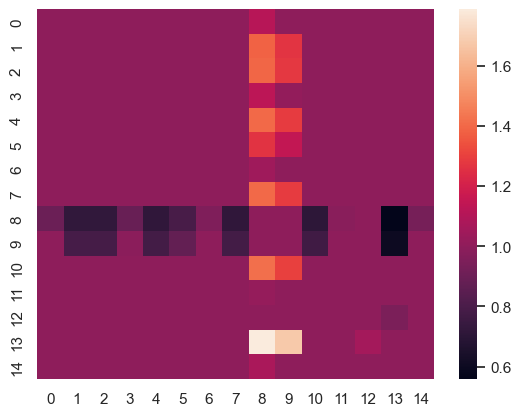

[0.06691636 0.06894663 0.06899432 0.06701586 0.06907574 0.06801426
 0.06668174 0.06905735 0.05537936 0.05889519 0.06918867 0.06657371
 0.06624575 0.07222868 0.06678637]


source_dataset source_channel target_dataset target_channel  acc_type3  \
64        mass_ss2         eeg_c4       mass_ss2         eeg_f4  85.032403   
68        mass_ss2         eeg_f3       mass_ss2         eeg_f4  83.262891   
74        mass_ss2         eeg_o2       mass_ss2         eeg_f4  81.679346   
79        mass_ss2         eeg_pz       mass_ss2         eeg_f4  84.677374   
121       mass_ss4         eeg_c4       mass_ss2         eeg_f4  81.377853   
125       mass_ss4         eeg_o2       mass_ss2         eeg_f4  80.638208   
131       mass_ss5         eeg_c4       mass_ss2         eeg_f4  82.696534   
136       mass_ss5         eeg_f4       mass_ss2         eeg_f4  84.185968   
140       mass_ss5         eeg_o2       mass_ss2         eeg_f4  80.822767   
145       mass_ss5         eeg_pz       mass_ss2         eeg_f4  79.404057   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
64   76.560041  82.564103  70.990237  86.835728  78.582987  
68   71.846545  85.021133  76.327809  84.175824  73.329760  
74   74.927272  80.479008  67.331382  86.903353  79.134646  
79   77.843005  84.626655  74.305009  86.869541  79.978080  
121  71.070469  84.171598  74.200287  87.214708  80.162761  
125  72.134220  82.899408  74.153467  87.104818  80.427292  
131  74.000964  83.503804  73.542657  86.297549  79.274987  
136  76.863558  81.186813  68.836769  86.677937  79.197633  
140  73.326057  82.609186  71.627369  87.032967  79.273697  
145  72.514903  84.256128  73.331588  86.563821  79.398349

Target: mass_ss2-eeg_f4
Comparing source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_p
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_c
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_p
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_p
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_o
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_p
With

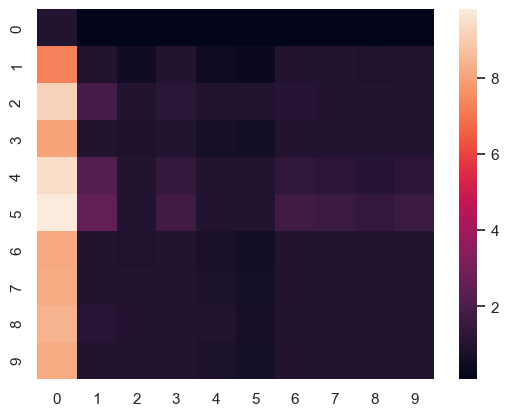

[0.01270328 0.0840509  0.11920944 0.0960196  0.13155881 0.15310005
 0.09799554 0.10044244 0.10450604 0.10041391]


source_dataset source_channel target_dataset target_channel  acc_type3  \
63        mass_ss2         eeg_c3       mass_ss2         eeg_c4  86.297549   
69        mass_ss2         eeg_f4       mass_ss2         eeg_c4  83.740490   
73        mass_ss2         eeg_o2       mass_ss2         eeg_c4  83.860242   
78        mass_ss2         eeg_pz       mass_ss2         eeg_c4  83.803888   
120       mass_ss4         eeg_c4       mass_ss2         eeg_c4  85.466329   
124       mass_ss4         eeg_o2       mass_ss2         eeg_c4  84.553395   
130       mass_ss5         eeg_c4       mass_ss2         eeg_c4  87.004790   
135       mass_ss5         eeg_f4       mass_ss2         eeg_c4  86.462384   
139       mass_ss5         eeg_o2       mass_ss2         eeg_c4  85.736827   
144       mass_ss5         eeg_pz       mass_ss2         eeg_c4  85.765004   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
63   78.926563  86.618766  79.693491  87.223161  80.565927  
69   76.818349  86.821640  79.489324  86.961116  79.693319  
73   77.539432  86.734291  79.033649  87.675402  80.917515  
78   75.943850  85.566357  78.350620  86.982249  79.699273  
120  74.850780  85.285996  77.640856  86.553959  79.861886  
124  74.171327  86.294731  80.000763  87.117498  79.886578  
130  80.249572  85.381798  78.142339  86.920259  80.143925  
135  79.821196  85.866441  78.193097  87.104818  80.358805  
139  78.186389  85.979149  79.041335  88.289659  81.679358  
144  78.593852  86.948436  79.491815  87.855734  80.766563

Target: mass_ss2-eeg_c4
Comparing source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_p
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_c
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_p
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_p
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_o
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_p
With

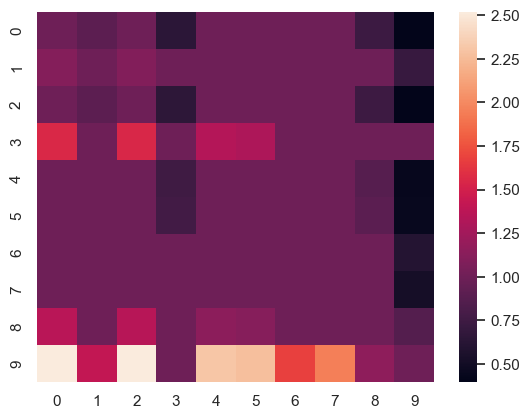

[0.08175235 0.09607248 0.0819113  0.11326165 0.08589462 0.0864524
 0.09269252 0.0913766  0.10481385 0.16577223]


source_dataset source_channel target_dataset target_channel  acc_type3  \
65        mass_ss2         eeg_c4       mass_ss4         eeg_c4  75.718886   
70        mass_ss2         eeg_f4       mass_ss4         eeg_c4  72.952195   
75        mass_ss2         eeg_o2       mass_ss4         eeg_c4  73.336962   
80        mass_ss2         eeg_pz       mass_ss4         eeg_c4  65.858581   
119       mass_ss4         eeg_c3       mass_ss4         eeg_c4  84.604046   
126       mass_ss4         eeg_o2       mass_ss4         eeg_c4  81.313498   
132       mass_ss5         eeg_c4       mass_ss4         eeg_c4  80.312651   
137       mass_ss5         eeg_f4       mass_ss4         eeg_c4  80.658110   
141       mass_ss5         eeg_o2       mass_ss4         eeg_c4  78.710087   
146       mass_ss5         eeg_pz       mass_ss4         eeg_c4  76.164127   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
65   68.999150  84.100599  77.153396  83.767235  76.685553  
70   66.091087  83.712808  76.866821  84.926070  78.550609  
75   66.806273  83.484519  77.204715  83.907837  77.053283  
80   59.330813  84.055243  77.126411  84.189042  77.693225  
119  78.703720  83.533654  76.738766  83.331821  77.046515  
126  74.869925  83.505685  76.830963  83.218433  76.222937  
132  74.323906  83.517779  76.948165  83.780842  77.402513  
137  74.410673  83.647043  77.115227  84.585903  78.085206  
141  72.136738  84.186018  77.519726  82.958394  76.526360  
146  70.734808  84.104378  77.400436  84.007620  77.644345

Target: mass_ss4-eeg_c4
Comparing source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_p
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_c
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_p
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_p
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_o
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_p
With

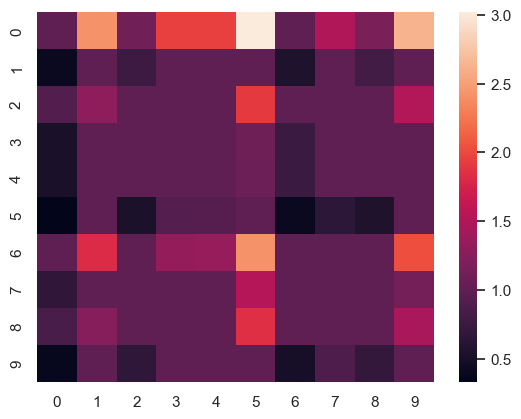

[0.15943767 0.07958654 0.10920562 0.08880629 0.08865446 0.06645385
 0.12773336 0.09821989 0.10711105 0.07479127]


source_dataset source_channel target_dataset target_channel  acc_type3  \
67        mass_ss2         eeg_c4       mass_ss5         eeg_f4  87.925642   
72        mass_ss2         eeg_f4       mass_ss5         eeg_f4  83.961059   
77        mass_ss2         eeg_o2       mass_ss5         eeg_f4  84.709925   
82        mass_ss2         eeg_pz       mass_ss5         eeg_f4  87.203207   
123       mass_ss4         eeg_c4       mass_ss5         eeg_f4  87.980706   
128       mass_ss4         eeg_o2       mass_ss5         eeg_f4  82.047046   
133       mass_ss5         eeg_c4       mass_ss5         eeg_f4  87.171270   
134       mass_ss5         eeg_f3       mass_ss5         eeg_f4  90.533457   
143       mass_ss5         eeg_o2       mass_ss5         eeg_f4  84.176909   
148       mass_ss5         eeg_pz       mass_ss5         eeg_f4  87.247258   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
67   81.708469  90.366063  83.913969  90.661204  84.790838  
72   73.393623  89.978415  83.446134  90.546672  85.564334  
77   76.263381  90.119378  84.919522  91.048852  85.380543  
82   79.113763  90.322012  85.240366  90.537862  84.818391  
123  79.912811  90.389190  83.084831  90.514735  85.188988  
128  73.178408  90.531254  84.949981  89.226246  82.714244  
133  79.921190  89.969605  83.332907  90.531254  85.001822  
134  85.858274  90.670015  84.471158  90.661204  85.267523  
143  74.111380  90.515836  85.217812  91.018017  84.525204  
148  79.387706  90.392494  84.175899  90.990485  85.287871

Target: mass_ss5-eeg_f4
Comparing source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_p
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_c
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_p
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_p
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_o
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_p
With

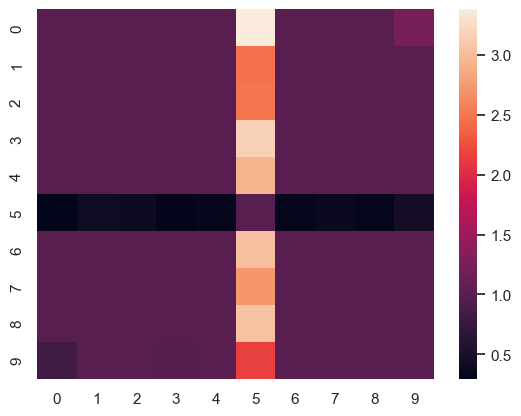

[0.11132992 0.10545302 0.10557691 0.10825833 0.10724326 0.03842738
 0.10759638 0.10640169 0.10768788 0.10202522]


source_dataset source_channel target_dataset target_channel  acc_type3  \
66        mass_ss2         eeg_c4       mass_ss5         eeg_c4  86.460949   
71        mass_ss2         eeg_f4       mass_ss5         eeg_c4  83.811286   
76        mass_ss2         eeg_o2       mass_ss5         eeg_c4  84.031540   
81        mass_ss2         eeg_pz       mass_ss5         eeg_c4  86.870622   
122       mass_ss4         eeg_c4       mass_ss5         eeg_c4  87.586450   
127       mass_ss4         eeg_o2       mass_ss5         eeg_c4  83.956654   
129       mass_ss5         eeg_c3       mass_ss5         eeg_c4  90.577508   
138       mass_ss5         eeg_f4       mass_ss5         eeg_c4  90.821990   
142       mass_ss5         eeg_o2       mass_ss5         eeg_c4  86.181225   
147       mass_ss5         eeg_pz       mass_ss5         eeg_c4  89.464121   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
66   80.905959  91.003700  85.552153  91.076384  86.034509  
71   77.429810  91.291133  86.257830  90.557685  84.979541  
76   77.004217  90.330822  84.398245  90.973966  85.142340  
81   79.847987  91.221752  85.899851  91.086296  85.762759  
122  80.739893  90.705255  85.261659  90.903484  85.558985  
127  76.272427  90.670015  84.480990  90.916700  85.248286  
129  84.930201  91.176600  85.189768  90.859434  85.307428  
138  85.511208  91.218449  85.815617  91.099511  85.450863  
142  78.664564  90.969561  85.394696  90.758116  84.709077  
147  82.565599  91.102815  85.476616  90.983877  85.435810

Target: mass_ss5-eeg_c4
Comparing source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_p
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_c
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_p
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_p
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_o
With source: mass_ss4-eeg_c
With source: mass_ss4-eeg_o
With source: mass_ss5-eeg_f
With source: mass_ss5-eeg_c
With source: mass_ss5-eeg_p
With source: mass_ss5-eeg_o
Comparing source: mass_ss2-eeg_o
With source: mass_ss2-eeg_f
With source: mass_ss2-eeg_c
With source: mass_ss2-eeg_p
With

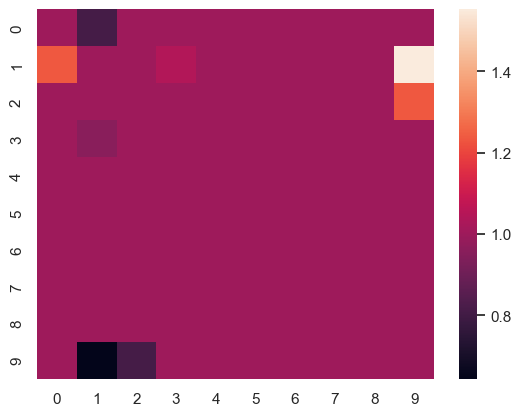

[0.09778856 0.10768907 0.10198697 0.09935778 0.09981565 0.09981565
 0.09981565 0.09981565 0.09981565 0.09409936]


OrderedDict([('mass_ss1-eeg_f4',
              {'src': ['mass_ss1-eeg_f3',
                'mass_ss1-eeg_c4',
                'mass_ss1-eeg_pz',
                'mass_ss1-eeg_o2',
                'mass_ss3-eeg_f4',
                'mass_ss3-eeg_c4',
                'mass_ss3-eeg_pz',
                'mass_ss3-eeg_o2',
                'sleepedf-eeg_fpz_cz',
                'sleepedf-eeg_pz_oz',
                'isruc-eeg_f4_a1',
                'isruc-eeg_c4_a1',
                'isruc-eeg_o2_a1',
                'shhs1_normal-eeg_c4_a1',
                'shhs1_osa-eeg_c4_a1'],
               'eigenvector': array([0.13309372, 0.05896044, 0.07251831, 0.03757419, 0.09678365,
                      0.06949503, 0.05929696, 0.05842293, 0.04060359, 0.03792009,
                      0.06528037, 0.08580892, 0.03075157, 0.0704014 , 0.08308886])}),
             ('mass_ss1-eeg_c4',
              {'src': ['mass_ss1-eeg_f4',
                'mass_ss1-eeg_c3',
                'mass_ss1-eeg_pz',
      

Target: mass_ss1-eeg_f4
Target: mass_ss1-eeg_c4
Target: mass_ss3-eeg_f4
Target: mass_ss3-eeg_c4
Target: sleepedf-eeg_fpz_cz
Target: isruc-eeg_f4_a1
Target: isruc-eeg_c4_a1
Target: shhs1_normal-eeg_c4_a1
Target: shhs1_osa-eeg_c4_a1
Target: mass_ss2-eeg_f4
Target: mass_ss2-eeg_c4
Target: mass_ss4-eeg_c4
Target: mass_ss5-eeg_f4
Target: mass_ss5-eeg_c4


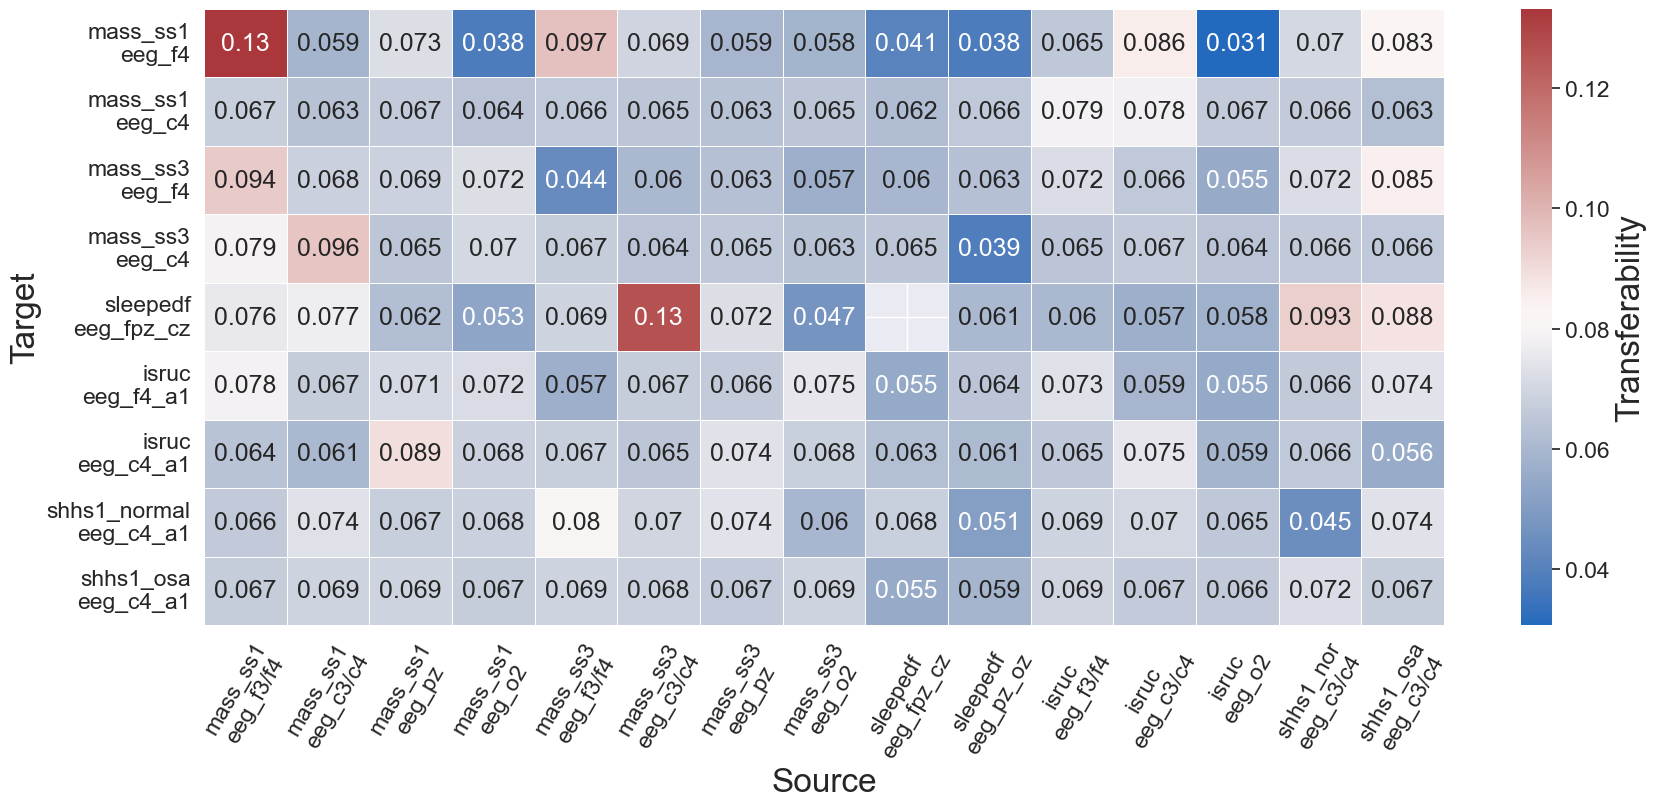

Usefulness


name     value
0    mass_ss1-eeg_f3/f4  0.080523
5    mass_ss3-eeg_c3/c4  0.072767
14  shhs1_osa-eeg_c3/c4  0.072755
1    mass_ss1-eeg_c3/c4  0.070323
2       mass_ss1-eeg_pz  0.070157
11      isruc-eeg_c3/c4  0.069375
13  shhs1_nor-eeg_c3/c4  0.068597
10      isruc-eeg_f3/f4  0.068565
4    mass_ss3-eeg_f3/f4  0.068343
6       mass_ss3-eeg_pz  0.067152
3       mass_ss1-eeg_o2  0.063604
7       mass_ss3-eeg_o2  0.062377
8   sleepedf-eeg_fpz_cz  0.058482
12         isruc-eeg_o2  0.057767
9    sleepedf-eeg_pz_oz  0.055710

/Users/akara/miniconda3/envs/sleep_tf/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


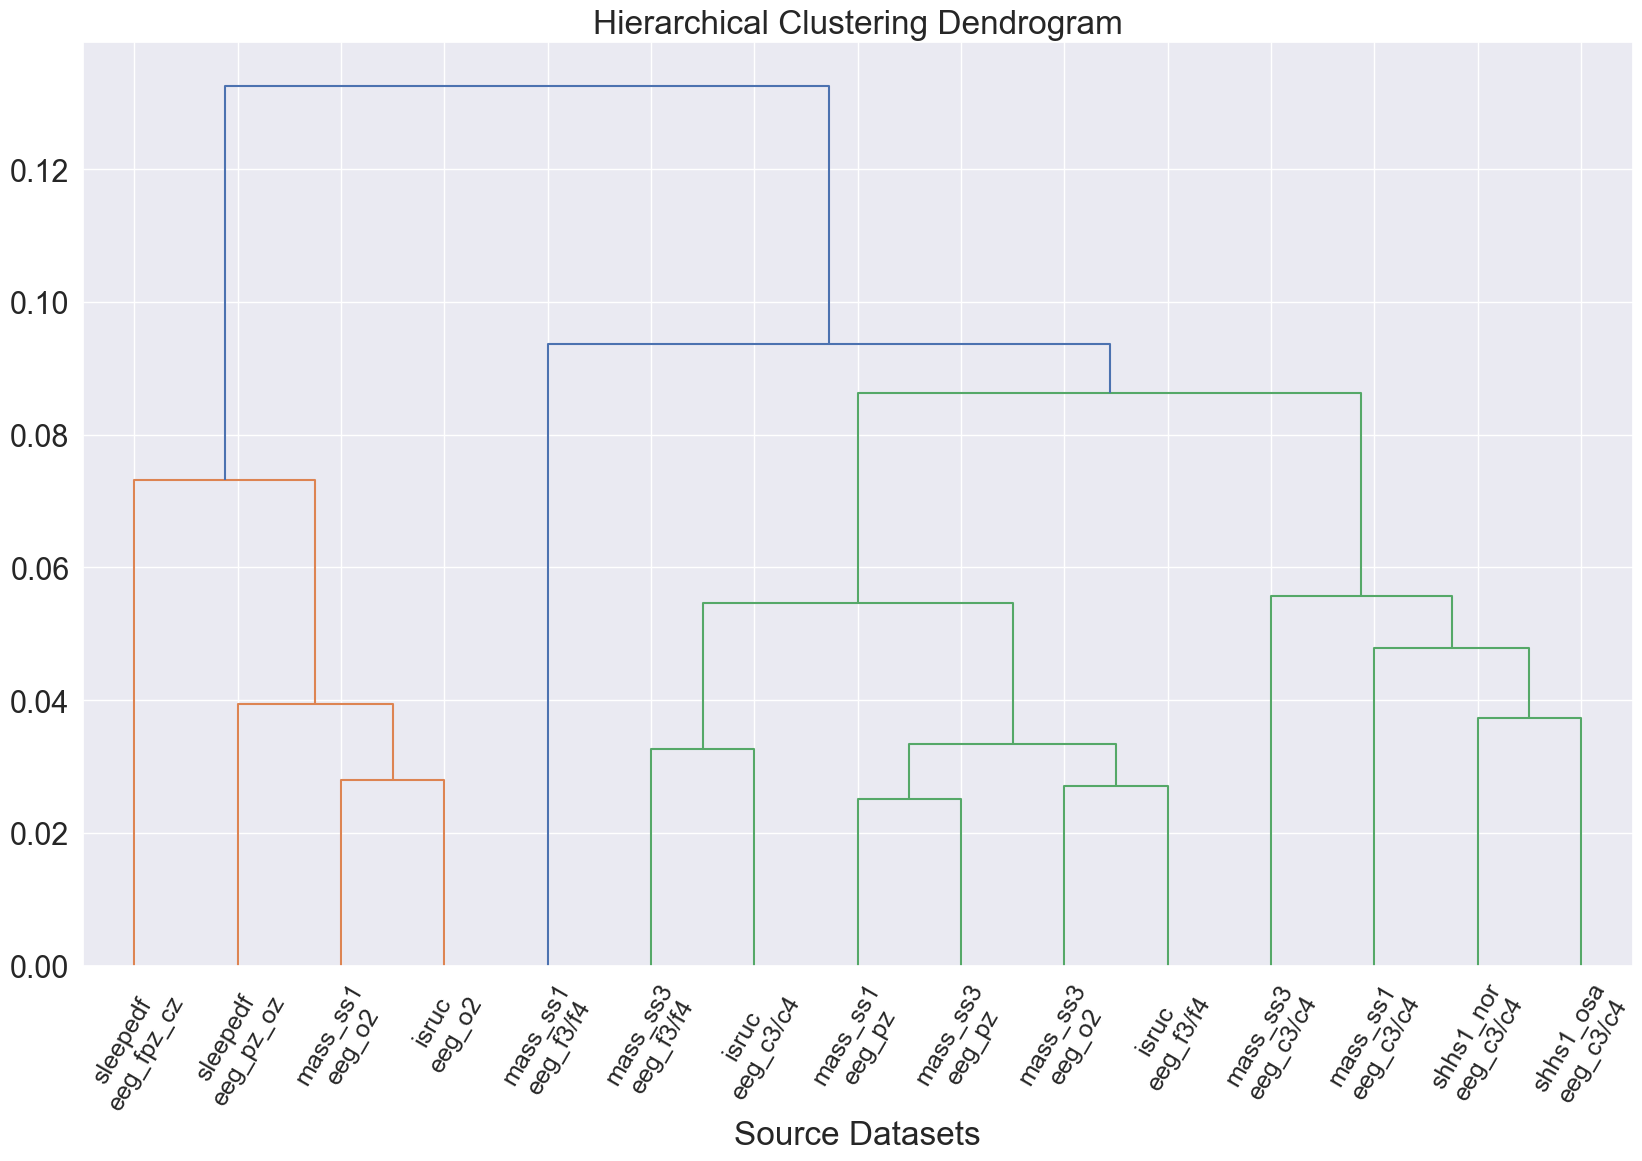

In [23]:
import seaborn as sns; sns.set_theme()
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

# type9 / type6
t1 = 9
t2 = 6
db_30s = ['mass_ss1','mass_ss3','sleepedf','isruc','shhs1_normal','shhs1_osa']
db_20s = ['mass_ss2','mass_ss4','mass_ss5']
chs = ['eeg_f','eeg_c','eeg_p','eeg_o']
print(f"{type_map[f'type{t1}']} / {type_map[f'type{t2}']}")

#### Affinity matrix ####

# target_ds = df['target_dataset'].unique()
target_ds = [
    'mass_ss1', 'mass_ss3',
    'sleepedf', 'isruc',
    'shhs1_normal','shhs1_osa',
    'mass_ss2', 'mass_ss4', 'mass_ss5']
tfability = OrderedDict()
for tgt_ds in target_ds:
    tgt_df = df[df['target_dataset'] == tgt_ds]
    # for tgt_ch in tgt_df['target_channel'].unique():
    for tgt_ch in sorted(tgt_df['target_channel'].unique(), key=cmp_to_key(compare)):
        tgt_ch_df = tgt_df[tgt_df['target_channel'] == tgt_ch].sort_values(by=['source_dataset','source_channel'])
        perf_mf1_type_t2 = tgt_ch_df[['target_dataset','target_channel',f'mf1_type{t1}',f'mf1_type{t2}']] \
                    .groupby(by=['target_dataset','target_channel']).mean() \
                    .reset_index().iloc[0].to_dict()[f'mf1_type{t2}']
        display(tgt_ch_df)
        # display(tgt_ch_df[['target_dataset','target_channel',f'mf1_type{t1}',f'mf1_type{t2}']]
        #             .groupby(by=['target_dataset','target_channel']).mean()
        #             .reset_index().iloc[0].to_dict()[f'mf1_type{t2}'])
        print(f"Target: {tgt_ds}-{tgt_ch}")
        if tgt_ds in db_30s:
            list_ds = db_30s
        else:
            list_ds = db_20s
        i = 0
        aff_mat = np.zeros((len(list_ds)*len(chs),len(list_ds)*len(chs)))
        src_list = []
        nan_src_list = []
        for src_ds in list_ds:
            for src_ch in chs:
                perf = tgt_ch_df[(tgt_ch_df['source_dataset']==src_ds) & (tgt_ch_df['source_channel'].str.contains(src_ch))]
                if len(perf) == 1:
                    print(f'Comparing source: {src_ds}-{src_ch}')
                    # display(perf)
                    perf = perf.iloc[0].to_dict()
                    if tgt_ds == 'mass_ss1':
                        mf1 = perf[f'mf1_type{t1}'] / perf[f'mf1_type{t2}']
                    else:
                        mf1 = perf[f'mf1_type{t1}'] / perf_mf1_type_t2
                    j = 0
                    for _src_ds in list_ds:
                        for _src_ch in chs:
                            if i == j:
                                aff_mat[i,j] = 1
                            else:
                                _perf = tgt_ch_df[(tgt_ch_df['source_dataset']==_src_ds) & (tgt_ch_df['source_channel'].str.contains(_src_ch))]
                                if len(_perf) == 1:
                                    print(f'With source: {_src_ds}-{_src_ch}')
                                    # display(_perf)
                                    _perf = _perf.iloc[0].to_dict()
                                    if tgt_ds == 'mass_ss1':
                                        _mf1 = _perf[f'mf1_type{t1}'] / _perf[f'mf1_type{t2}']
                                    else:
                                        _mf1 = _perf[f'mf1_type{t1}'] / perf_mf1_type_t2
                                    diff = (mf1 - _mf1) * 100
                                    if diff >= 1:
                                        # greater
                                        aff_mat[i,j] = diff
                                    elif diff <= -1:
                                        # less
                                        aff_mat[i,j] = 1. / abs(diff)
                                    else:
                                        # equal or less than 1 percent better
                                        aff_mat[i,j] = 1
                                    # if aff_mat[i,j] >= 5:
                                    #     print(perf[f'mf1_type{t1}'], perf[f'mf1_type{t2}'], _perf[f'mf1_type{t1}'], _perf[f'mf1_type{t2}'])
                                    #     print(src_ds, src_ch, _src_ds, _src_ch, aff_mat[i,j], mf1, _mf1)
                                else:
                                    aff_mat[i,j] = float('nan')
                            j += 1
                    src_list.append(f"{perf['source_dataset']}-{perf['source_channel']}")
                else:
                    aff_mat[i,:] = float('nan')
                    nan_src_list.append(f"{src_ds}-{src_ch}")
                i += 1
        # Heatmap
        nan_src = np.where(np.isnan(aff_mat).all(axis=0))[0]
        print(f"Not available source: {nan_src_list} {nan_src}")
        aff_mat = aff_mat[~np.isnan(aff_mat).all(axis=0)]
        aff_mat = aff_mat[:,~np.all(np.isnan(aff_mat), axis=0)]
        ax = sns.heatmap(aff_mat)
        plt.show()

        # Estimate eigenvector (not exact calculation)
        sum_cols = np.sum(aff_mat, axis=0)
        norm_aff_mat = aff_mat / sum_cols
        est_eigenvectors = np.sum(norm_aff_mat, axis=1) / norm_aff_mat.shape[1]
        print(est_eigenvectors)

        tfability[f'{tgt_ds}-{tgt_ch}'] = {}
        tfability[f'{tgt_ds}-{tgt_ch}']['src'] = src_list
        tfability[f'{tgt_ds}-{tgt_ch}']['eigenvector'] = est_eigenvectors

display(tfability)

#### Affinity matrix - 30s ####

y_ticklabels = []
x_ticklabels = None
tf_mat = []
for k in tfability:
    print(f'Target: {k}')
    db, ch = k.split('-')
    if db in db_30s:
        if len(tfability[k]['eigenvector']) == 15:
            ev = np.array(tfability[k]['eigenvector'])
            tf_mat.append(ev)
            if x_ticklabels is None:
                x_ticklabels = [_.replace('-','\n') for _ in tfability[k]['src']]
                for _i, _x in enumerate(x_ticklabels):
                    if 'eeg_f3' in _x:
                        _x = _x.replace('eeg_f3','eeg_f3/f4')
                    elif 'eeg_f4' in _x:
                        _x = _x.replace('eeg_f4','eeg_f3/f4')
                    elif 'eeg_c3' in _x:
                        _x = _x.replace('eeg_c4','eeg_c3/c4')
                    elif 'eeg_c4' in _x:
                        _x = _x.replace('eeg_c4','eeg_c3/c4')
                    x_ticklabels[_i] = _x.replace('_a1', '').replace('_a2', '').replace('_normal','_nor')
            y_ticklabels.append(k.replace('-','\n'))
        elif len(tfability[k]['eigenvector']) == 14:
            ev = np.array(tfability[k]['eigenvector'])
            ev = np.insert(ev, -6, float('nan'))  # insert sleepedf-fpz
            tf_mat.append(ev)
            y_ticklabels.append(k.replace('-','\n'))
tf_mat = np.array(tf_mat)

plt.figure(figsize=(20,8))
sns.set(font_scale=1.5)
ax = sns.heatmap(
    tf_mat,
    cmap='vlag',
    linewidths=.5,
    annot=True,
    xticklabels=x_ticklabels,
    yticklabels=y_ticklabels,
    cbar_kws={'label':'Transferability'})
ax.figure.axes[-1].yaxis.label.set_size(24)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.ylabel('Target', fontsize=24)
plt.xlabel('Source', fontsize=24)
plt.show()

print('Usefulness')
useful_df = pd.DataFrame({
    'name': [t.replace('\n','-') for t in x_ticklabels],
    'value': np.nanmean(tf_mat, axis=0),
})
# for v, t in zip(np.nanmean(tf_mat, axis=0), x_ticklabels):
#     tt = t.replace('\n','-')
#     print(f"{tt}: {v}")
display(useful_df.sort_values(by='value',ascending=False))

#### plot dendrogram ####

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(
    distance_threshold=0,
    affinity='euclidean',
    linkage='ward',
    # affinity='cosine',
    # linkage='average',
    n_clusters=None)

model = model.fit(np.nan_to_num(tf_mat).T)
# plot the top three levels of the dendrogram
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(
    model,
    truncate_mode='level',
    leaf_rotation=60,
    leaf_font_size=18,
    labels=x_ticklabels,
    p=6)
plt.xlabel("Source Datasets")
plt.show()

Target: mass_ss1-eeg_f4
Target: mass_ss1-eeg_c4
Target: mass_ss3-eeg_f4
Target: mass_ss3-eeg_c4
Target: sleepedf-eeg_fpz_cz
Target: isruc-eeg_f4_a1
Target: isruc-eeg_c4_a1
Target: shhs1_normal-eeg_c4_a1
Target: shhs1_osa-eeg_c4_a1
Target: mass_ss2-eeg_f4
Target: mass_ss2-eeg_c4
Target: mass_ss4-eeg_c4
Target: mass_ss5-eeg_f4
Target: mass_ss5-eeg_c4
['mass_ss1\neeg_f3/f4', 'mass_ss1\neeg_c3/c4', 'mass_ss1\neeg_pz', 'mass_ss1\neeg_o2', 'mass_ss3\neeg_f3/f4', 'mass_ss3\neeg_c3/c4', 'mass_ss3\neeg_pz', 'mass_ss3\neeg_o2', 'sleepedf\neeg_fpz_cz', 'sleepedf\neeg_pz_oz', 'isruc\neeg_f3/f4', 'isruc\neeg_c3/c4', 'isruc\neeg_o2', 'shhs1_nor\neeg_c3/c4', 'shhs1_osa\neeg_c3/c4']
['mass_ss1\neeg_f4', 'mass_ss1\neeg_c4', 'mass_ss3\neeg_f4', 'mass_ss3\neeg_c4', 'sleepedf\neeg_fpz_cz', 'isruc\neeg_f4_a1', 'isruc\neeg_c4_a1', 'shhs1_normal\neeg_c4_a1', 'shhs1_osa\neeg_c4_a1']
Usefulness


/var/folders/nb/9lsbxq3s3x976rmt497ftw_00000gp/T/ipykernel_45979/720533884.py:54: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[1,0])


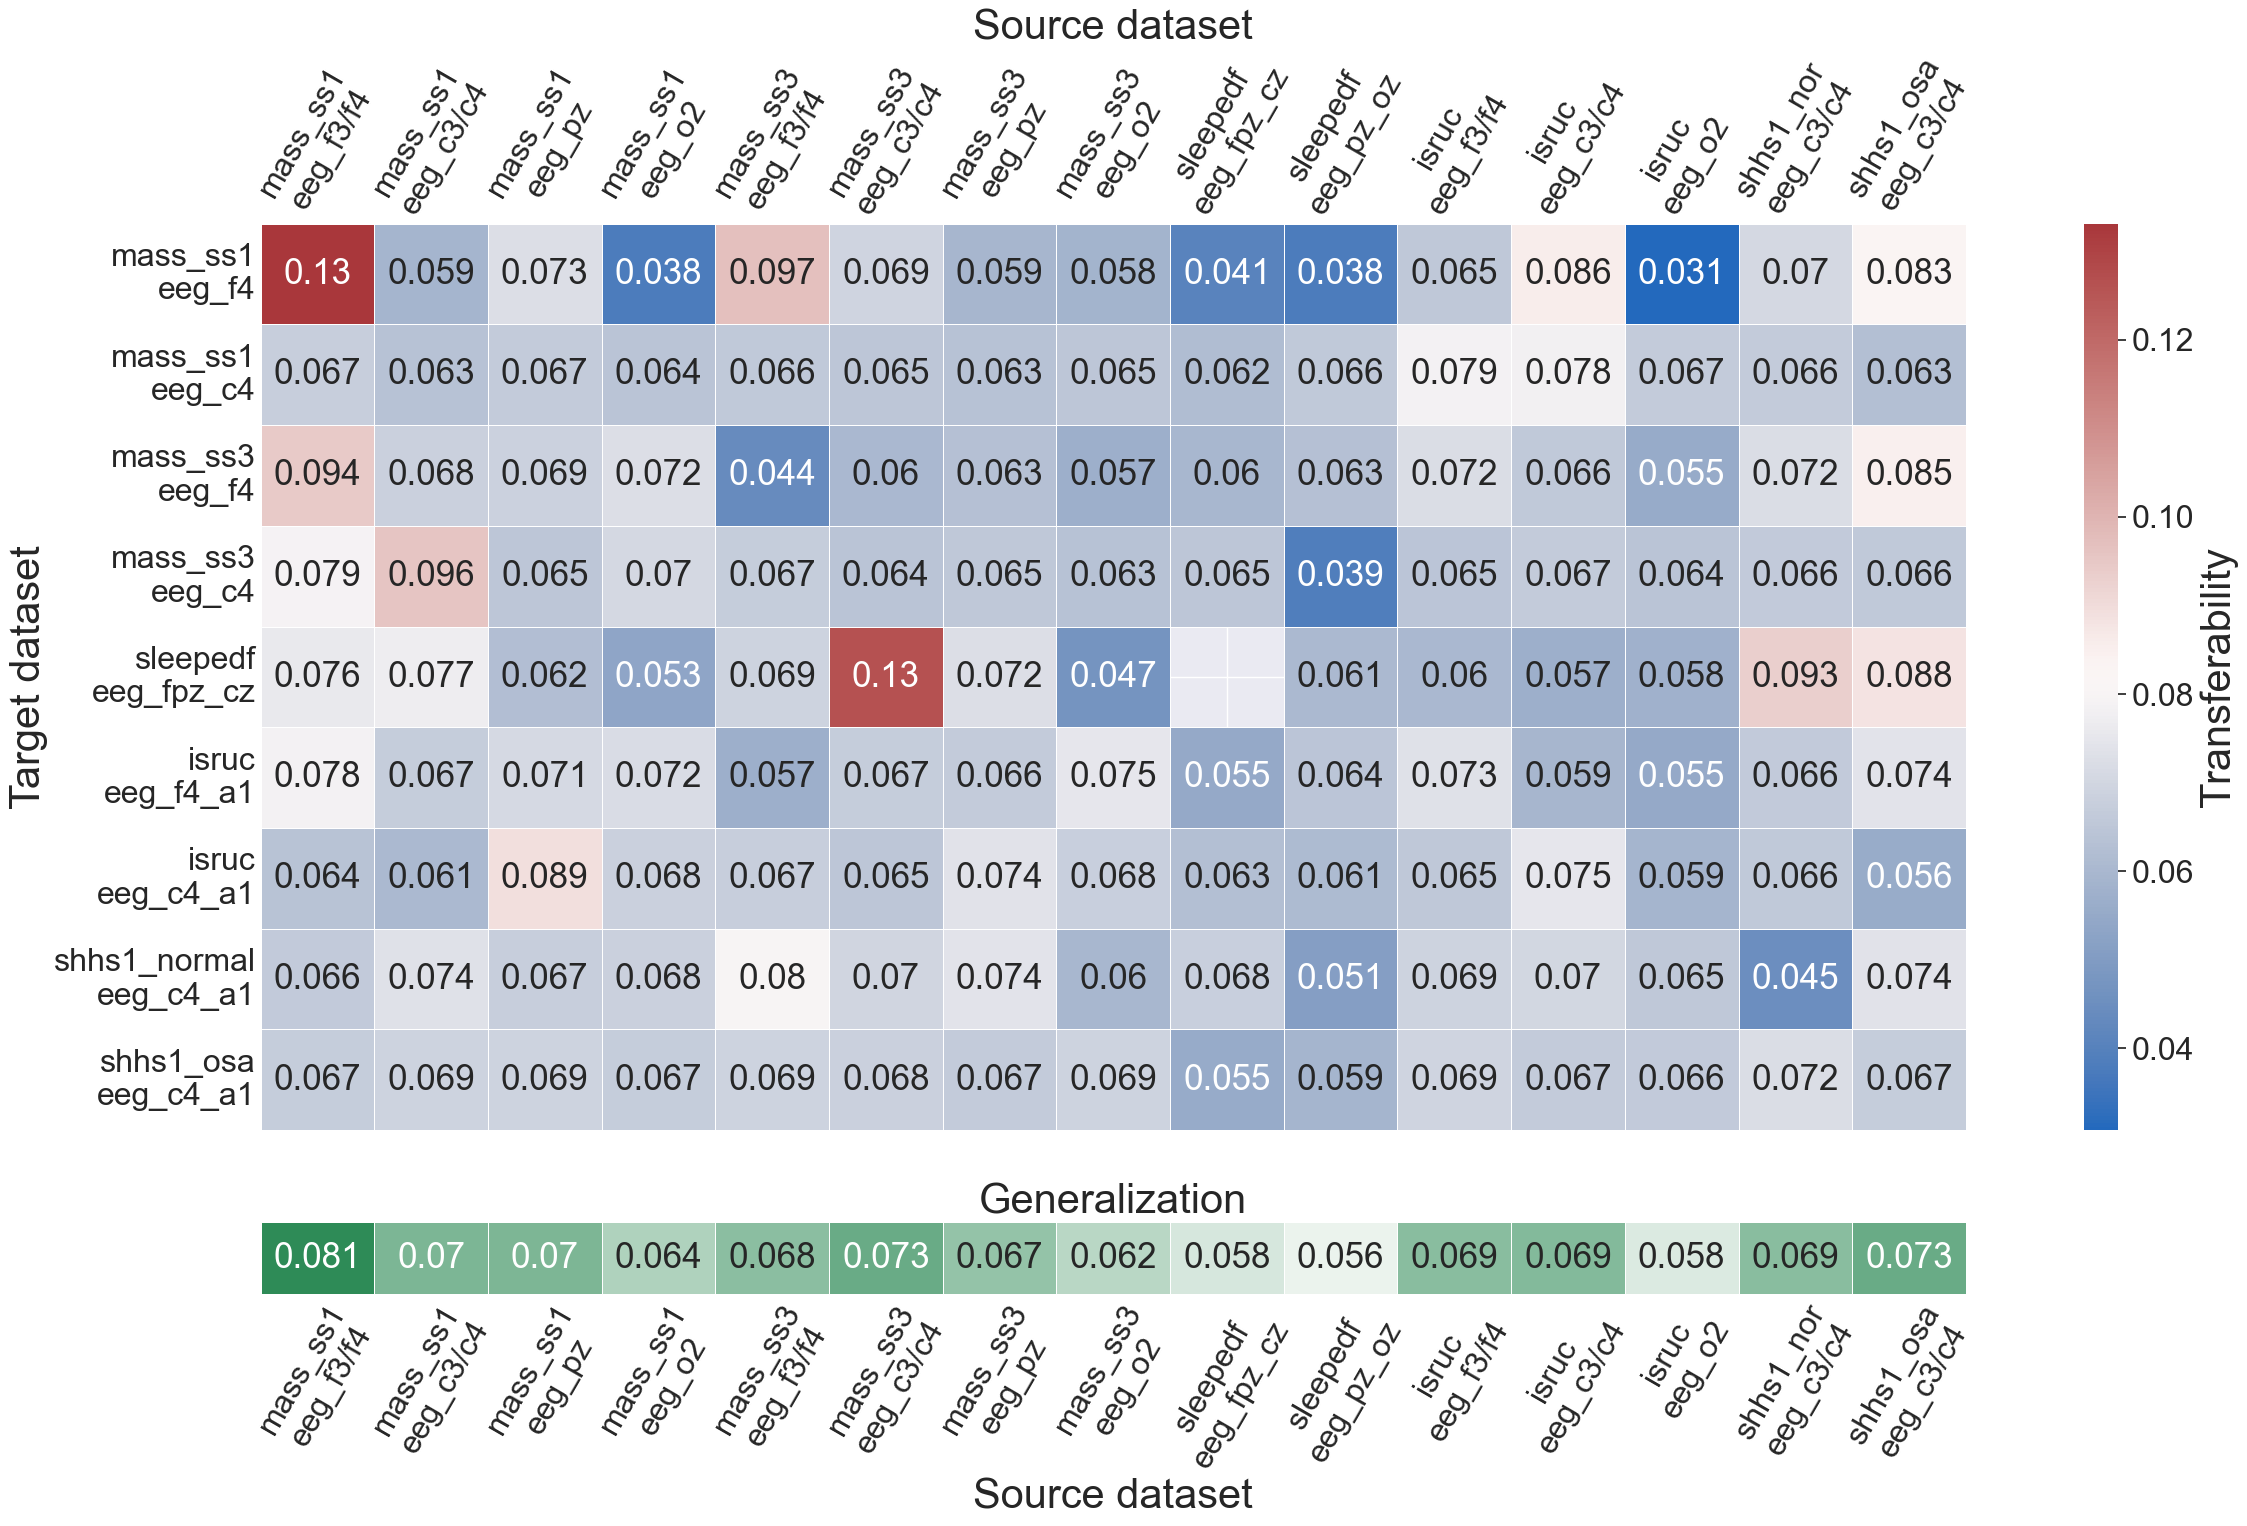

In [24]:
#### Affinity matrix - 30s ####

y_ticklabels = []
x_ticklabels = None
tf_mat = []
for k in tfability:
    print(f'Target: {k}')
    db, ch = k.split('-')
    if db in db_30s:
        if len(tfability[k]['eigenvector']) == 15:
            ev = np.array(tfability[k]['eigenvector'])
            tf_mat.append(ev)
            if x_ticklabels is None:
                x_ticklabels = [_.replace('-','\n') for _ in tfability[k]['src']]
                for _i, _x in enumerate(x_ticklabels):
                    if 'eeg_f3' in _x:
                        _x = _x.replace('eeg_f3','eeg_f3/f4')
                    elif 'eeg_f4' in _x:
                        _x = _x.replace('eeg_f4','eeg_f3/f4')
                    elif 'eeg_c3' in _x:
                        _x = _x.replace('eeg_c4','eeg_c3/c4')
                    elif 'eeg_c4' in _x:
                        _x = _x.replace('eeg_c4','eeg_c3/c4')
                    x_ticklabels[_i] = _x.replace('_a1', '').replace('_a2', '').replace('_normal','_nor')
            y_ticklabels.append(k.replace('-','\n'))
        elif len(tfability[k]['eigenvector']) == 14:
            ev = np.array(tfability[k]['eigenvector'])
            ev = np.insert(ev, -6, float('nan'))  # insert sleepedf-fpz
            tf_mat.append(ev)
            y_ticklabels.append(k.replace('-','\n'))
tf_mat = np.array(tf_mat)

print(x_ticklabels)
print(y_ticklabels)

print('Usefulness')
useful_df = pd.DataFrame({
    'name': [t.replace('\n','-') for t in x_ticklabels],
    'value': np.nanmean(tf_mat, axis=0),
})
# # for v, t in zip(np.nanmean(tf_mat, axis=0), x_ticklabels):
# #     tt = t.replace('\n','-')
# #     print(f"{tt}: {v}")
# display(useful_df.sort_values(by='value',ascending=False))


# for publication
label_size = 30
sns.set(font_scale=2.1)
gs_kw = dict(width_ratios=[1,0.02], height_ratios=[1,0.08])
f, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,12), gridspec_kw=gs_kw)
axs[1,1].remove()
f.tight_layout()
axs[0,0].get_shared_y_axes().join(axs[1,0])
ax = sns.heatmap(
    tf_mat,
    cmap='vlag',
    xticklabels=x_ticklabels,
    yticklabels=y_ticklabels,
    linewidths=.5,
    annot=True,
    cbar_ax=axs[0,1],
    # cbar_kws={'label':r'$h^{t}_{(i,j)}$'},
    ax=axs[0,0])
axs[0,0].set_yticklabels(axs[0,0].get_yticklabels(), rotation=0)
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=60)
axs[0,0].xaxis.tick_top()
axs[0,0].xaxis.set_label_position('top')
axs[0,0].tick_params(length=0)
axs[0,0].set_xlabel(f'Source dataset', fontsize=label_size)
axs[0,0].set_ylabel(f'Target dataset', fontsize=label_size)
axs[0,1].set_ylabel('Transferability', fontsize=label_size)

ax = sns.heatmap(
    [useful_df['value'].values],
    cmap=sns.light_palette("seagreen", as_cmap=True),
    xticklabels=x_ticklabels,
    yticklabels=[""],
    linewidths=.5,
    cbar=False,
    annot=True,
    ax=axs[1,0])
axs[1,0].set_yticklabels(axs[1,0].get_yticklabels(), rotation=0)
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=60)
axs[1,0].tick_params(length=0)
axs[1,0].set_xlabel(f'Source dataset', fontsize=label_size)
axs[1,0].set_title(f'Generalization', fontsize=label_size)

plt.savefig(f'tf_mat_tinysleepnet.eps', format='eps', dpi=500, bbox_inches='tight')
plt.show()
plt.close('all')

TF_src80-to-tgt80_pred_tgt20 / FS_tgt80_pred_tgt20


source_dataset source_channel target_dataset target_channel  acc_type3  \
3            isruc      eeg_c4_a1       mass_ss1         eeg_f4  65.868581   
12           isruc      eeg_f4_a1       mass_ss1         eeg_f4  67.752192   
21           isruc      eeg_o2_a1       mass_ss1         eeg_f4  65.820407   
30        mass_ss1         eeg_c4       mass_ss1         eeg_f4  73.200694   
36        mass_ss1         eeg_f3       mass_ss1         eeg_f4  78.915759   
48        mass_ss1         eeg_o2       mass_ss1         eeg_f4  61.528086   
57        mass_ss1         eeg_pz       mass_ss1         eeg_f4  71.230369   
87        mass_ss3         eeg_c4       mass_ss1         eeg_f4  73.237627   
96        mass_ss3         eeg_f4       mass_ss1         eeg_f4  73.663166   
104       mass_ss3         eeg_o2       mass_ss1         eeg_f4  63.577898   
113       mass_ss3         eeg_pz       mass_ss1         eeg_f4  72.034878   
153   shhs1_normal      eeg_c4_a1       mass_ss1         eeg_f4  64.762180   
162      shhs1_osa      eeg_c4_a1       mass_ss1         eeg_f4  69.377268   
170       sleepedf     eeg_fpz_cz       mass_ss1         eeg_f4  62.845650   
178       sleepedf      eeg_pz_oz       mass_ss1         eeg_f4  60.660950   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
3    63.913184  77.835052  73.637435  78.350515  74.340688  
12   65.040891  78.251758  74.180950  78.290298  74.093828  
21   61.996013  78.203584  74.271932  76.671645  72.572577  
30   69.169301  77.885634  73.919366  77.490606  73.616299  
36   75.096227  77.351704  73.192452  78.559270  74.754538  
48   57.836605  78.167454  73.918942  76.600186  72.662136  
57   66.396911  77.232874  73.057914  77.595786  73.289578  
87   68.132638  77.753155  73.587684  77.293895  73.685326  
96   68.209045  77.726660  73.278117  78.136140  74.219868  
104  58.431625  77.820599  73.841134  77.806147  73.517791  
113  66.197341  78.290298  73.960146  77.574911  73.669630  
153  57.454275  78.144972  73.922177  77.855927  74.060392  
162  62.142116  77.974757  73.947410  78.437229  74.587981  
170  56.302091  84.683014  82.180323  83.071587  80.924238  
178  53.276912  84.685422  82.292027  83.428076  80.910696

Target: mass_ss1-eeg_f4
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

/var/folders/nb/9lsbxq3s3x976rmt497ftw_00000gp/T/ipykernel_45979/3008615138.py:125: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[1,0])


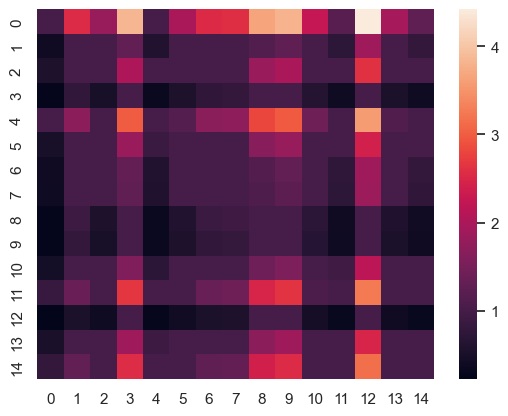

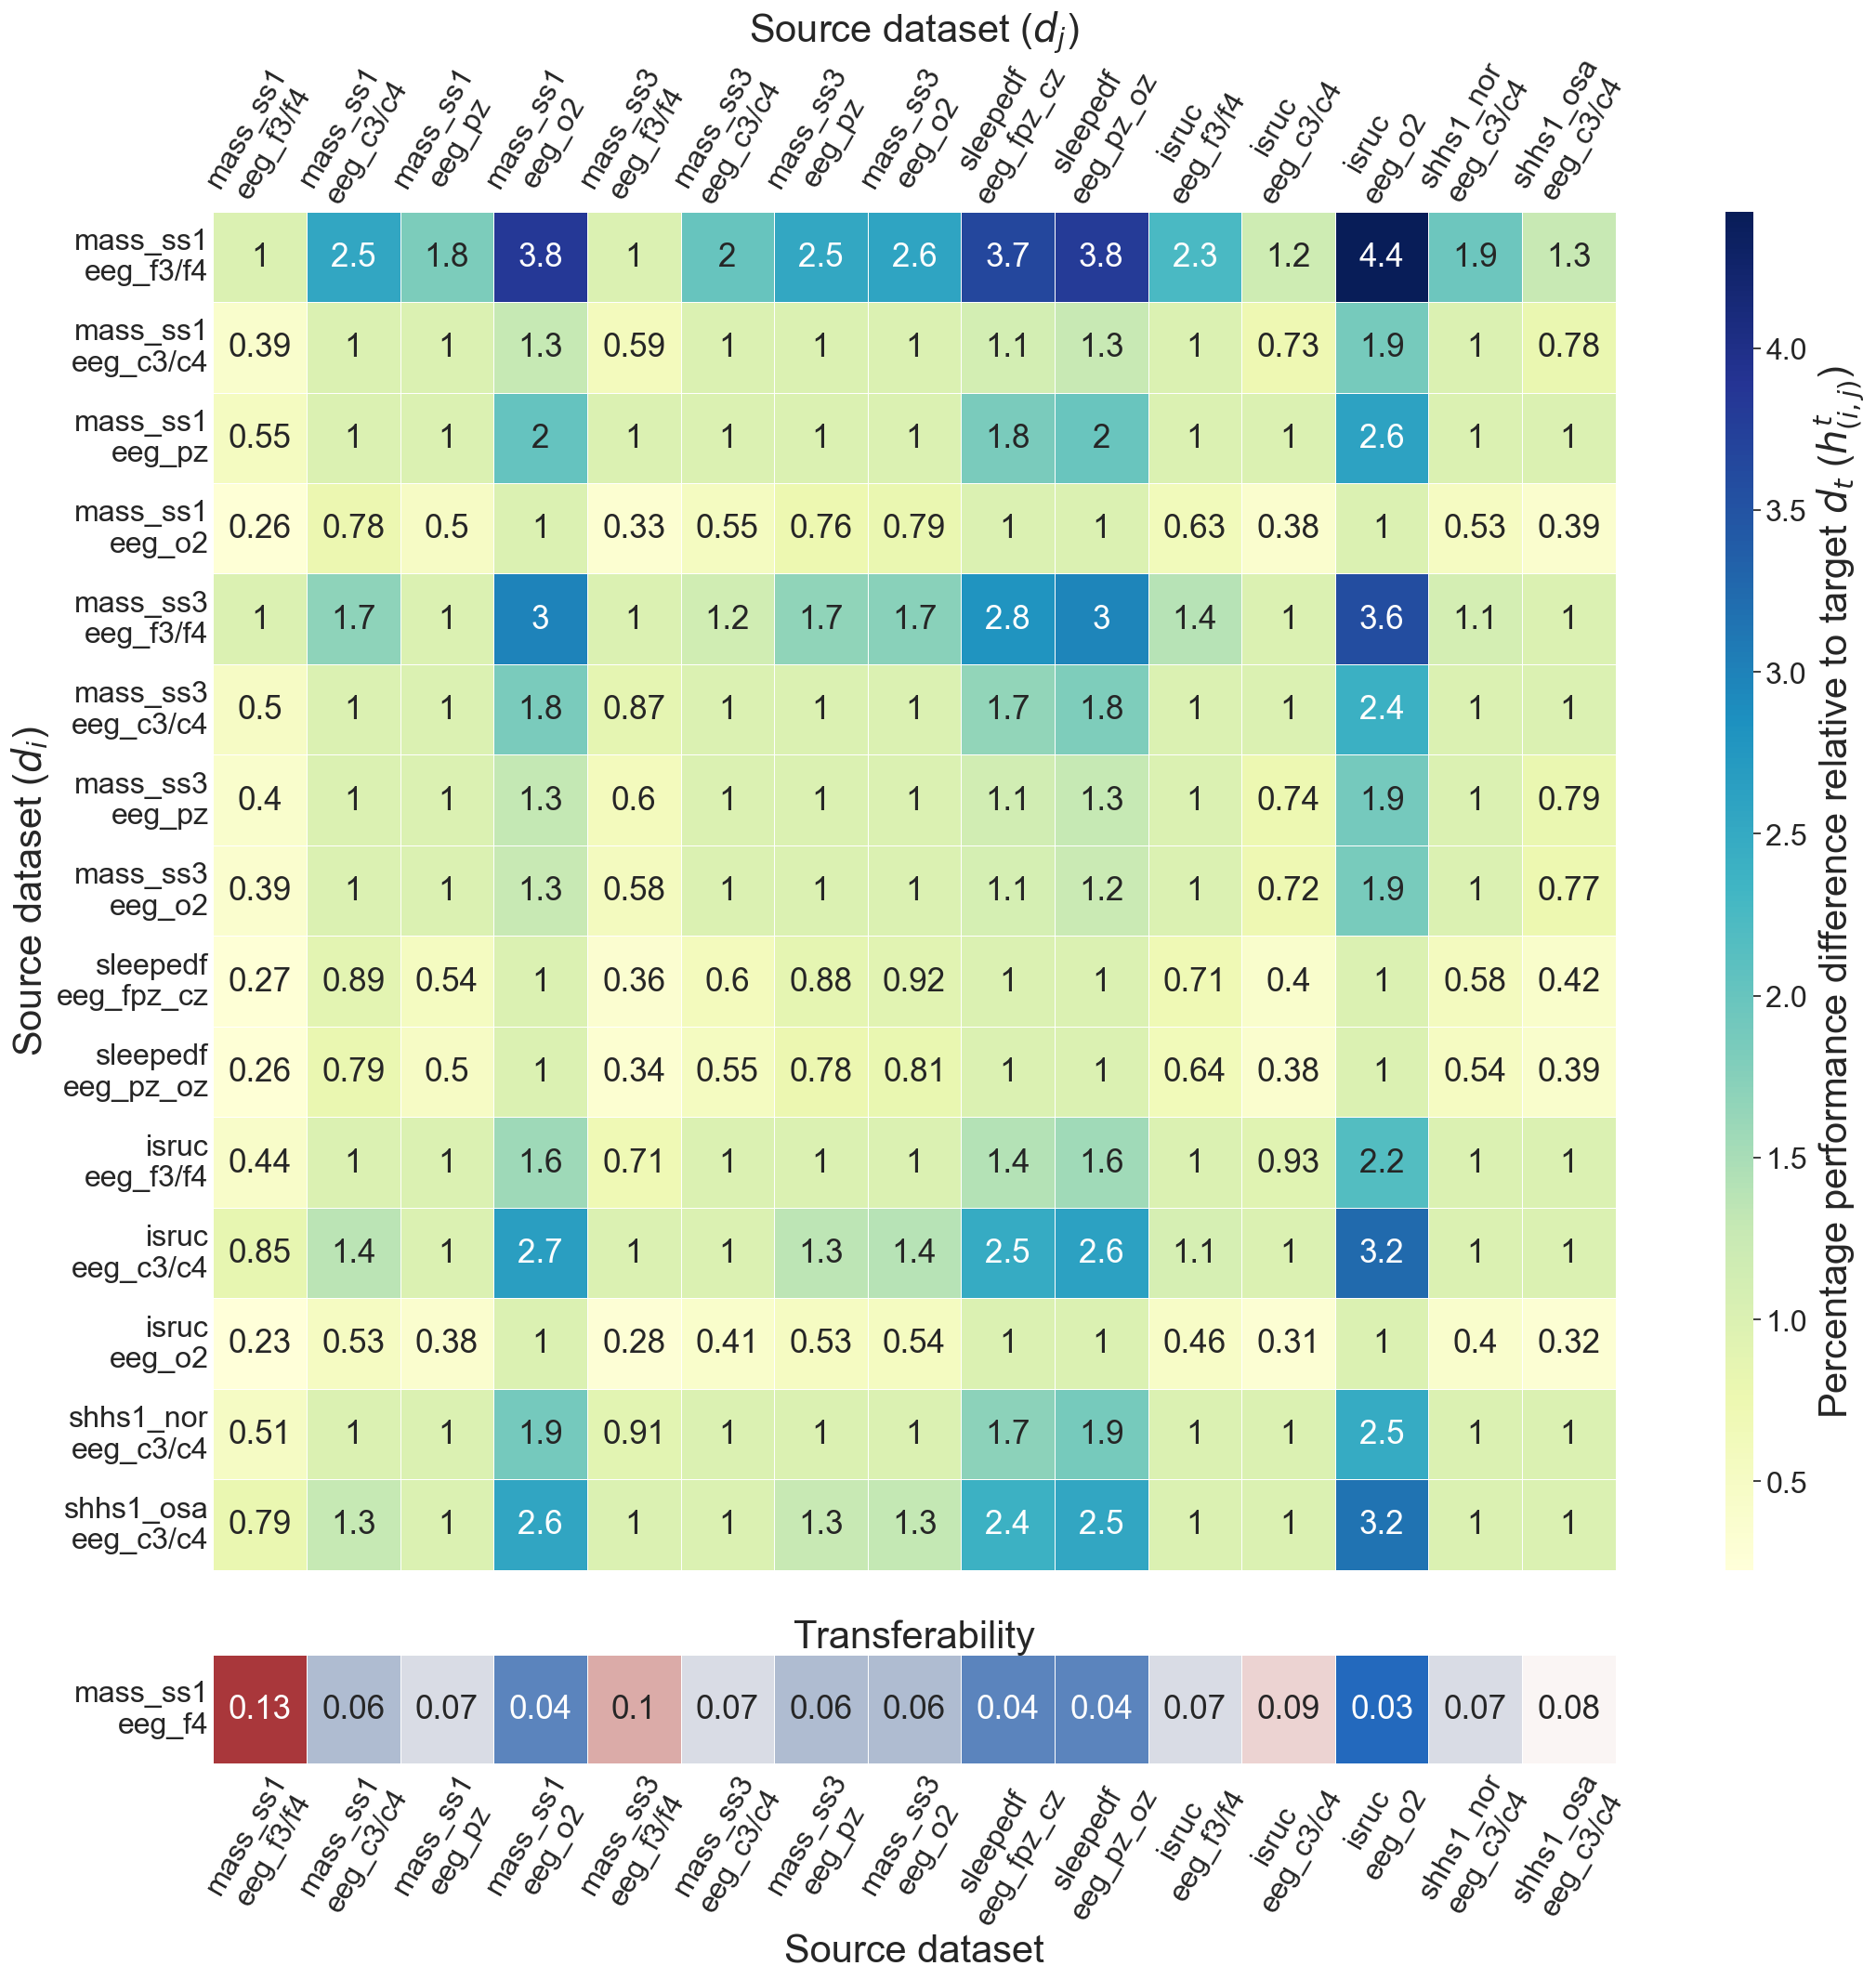

source_dataset source_channel target_dataset target_channel  acc_type3  \
2            isruc      eeg_c4_a1       mass_ss1         eeg_c4  69.261650   
11           isruc      eeg_f4_a1       mass_ss1         eeg_c4  68.163278   
20           isruc      eeg_o2_a1       mass_ss1         eeg_c4  67.864598   
27        mass_ss1         eeg_c3       mass_ss1         eeg_c4  78.820214   
39        mass_ss1         eeg_f4       mass_ss1         eeg_c4  77.467322   
47        mass_ss1         eeg_o2       mass_ss1         eeg_c4  68.339917   
56        mass_ss1         eeg_pz       mass_ss1         eeg_c4  77.447249   
86        mass_ss3         eeg_c4       mass_ss1         eeg_c4  73.321129   
95        mass_ss3         eeg_f4       mass_ss1         eeg_c4  69.720108   
103       mass_ss3         eeg_o2       mass_ss1         eeg_c4  70.738992   
112       mass_ss3         eeg_pz       mass_ss1         eeg_c4  71.743424   
152   shhs1_normal      eeg_c4_a1       mass_ss1         eeg_c4  69.207053   
161      shhs1_osa      eeg_c4_a1       mass_ss1         eeg_c4  70.922054   
169       sleepedf     eeg_fpz_cz       mass_ss1         eeg_c4  64.047596   
177       sleepedf      eeg_pz_oz       mass_ss1         eeg_c4  65.931207   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
2    66.762515  77.939429  73.342413  78.392266  73.882248  
11   65.245647  77.888043  73.126602  78.337669  73.672511  
20   64.516420  77.762790  73.124408  78.183512  73.251483  
27   73.915870  77.902495  73.344723  77.191926  72.846175  
39   71.464128  77.409513  73.048061  77.977968  73.255590  
47   64.333945  77.497832  72.790738  76.977551  72.366508  
56   72.188496  77.806147  73.166617  78.027748  73.277572  
86   66.101748  77.784469  73.174248  77.493015  72.854891  
95   61.166807  77.572502  72.847278  77.632720  72.612726  
103  65.388255  77.774834  73.073254  77.461702  72.739944  
112  63.145473  77.348492  72.615671  76.939011  72.130044  
152  61.627715  77.467322  72.982098  77.428782  72.940317  
161  62.811647  78.225263  73.893345  77.894466  73.306074  
169  58.245244  84.078428  81.140457  83.565372  80.441490  
177  57.787811  83.741208  80.806634  83.755660  80.517890

Target: mass_ss1-eeg_c4
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

/var/folders/nb/9lsbxq3s3x976rmt497ftw_00000gp/T/ipykernel_45979/3008615138.py:125: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[1,0])


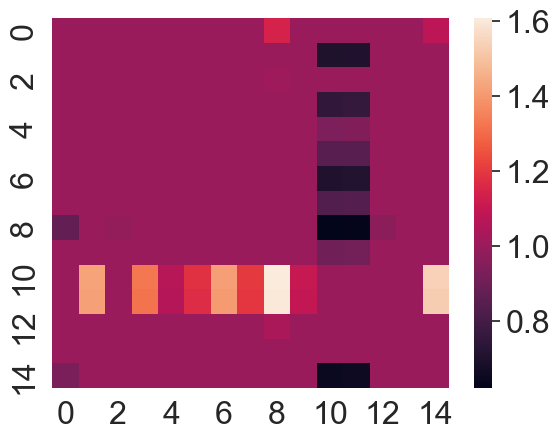

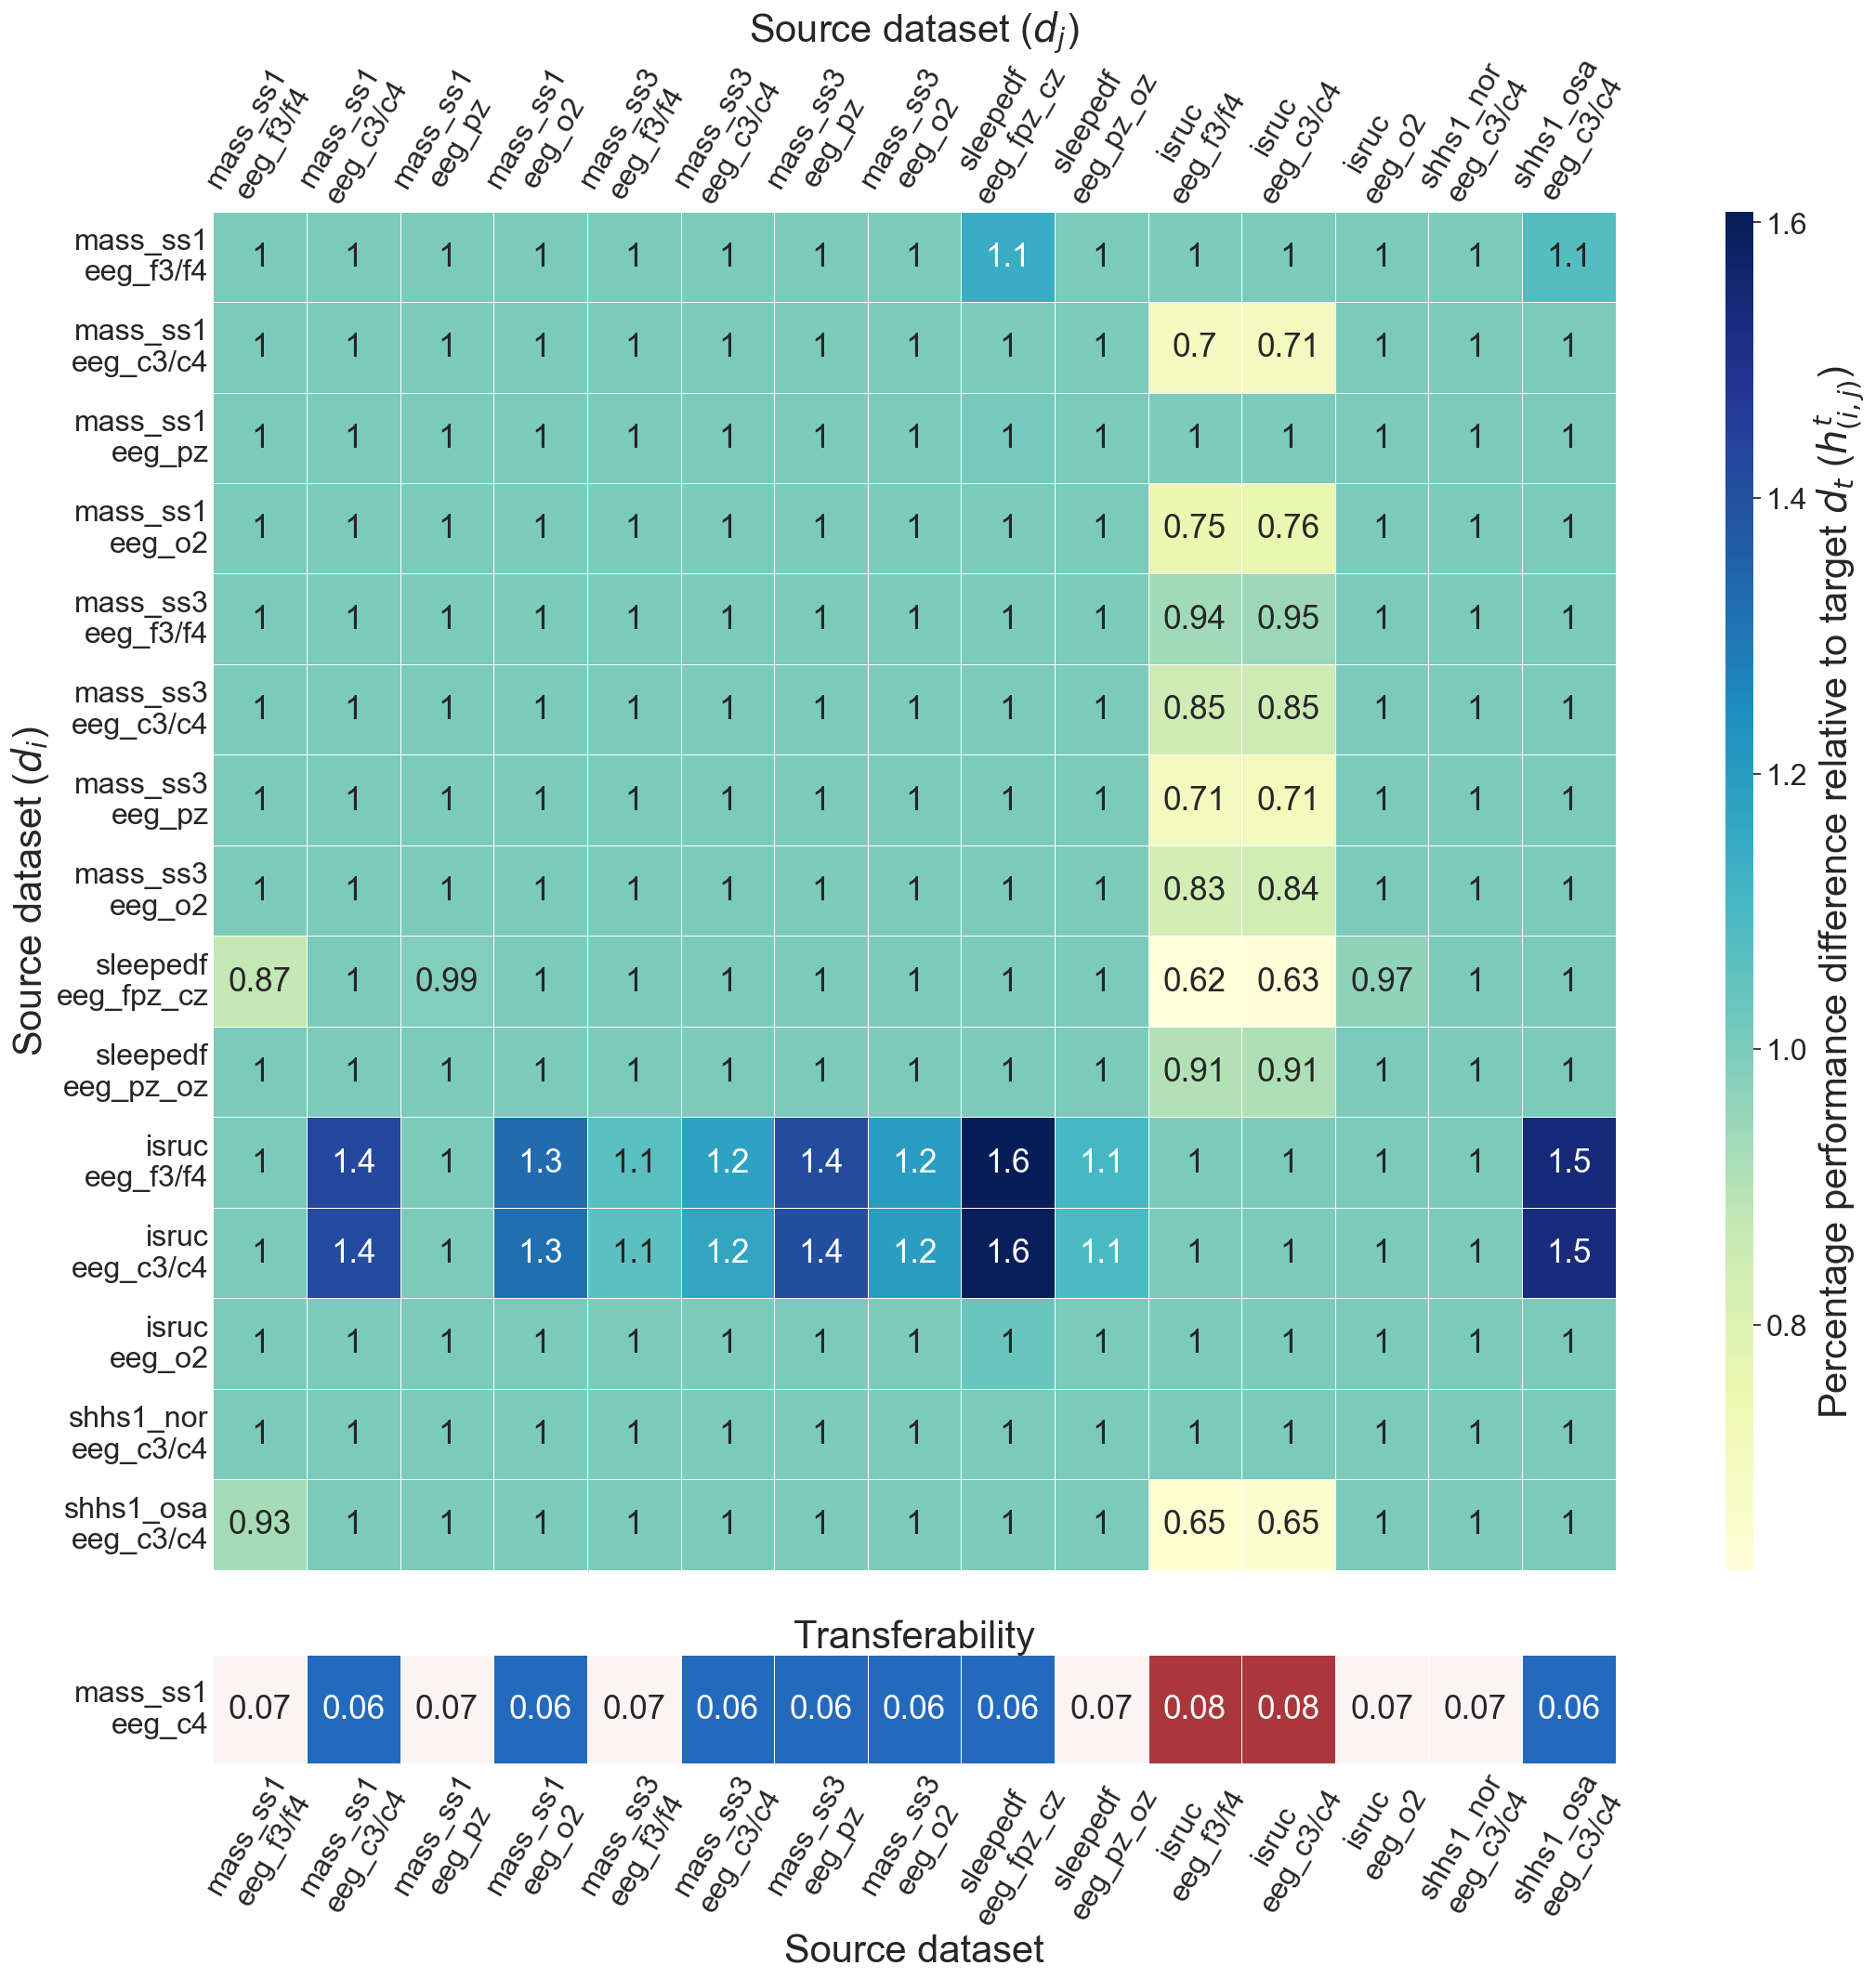

source_dataset source_channel target_dataset target_channel  acc_type3  \
5            isruc      eeg_c4_a1       mass_ss3         eeg_f4  73.361128   
14           isruc      eeg_f4_a1       mass_ss3         eeg_f4  75.319347   
23           isruc      eeg_o2_a1       mass_ss3         eeg_f4  71.737781   
32        mass_ss1         eeg_c4       mass_ss3         eeg_f4  83.737692   
41        mass_ss1         eeg_f4       mass_ss3         eeg_f4  87.965345   
50        mass_ss1         eeg_o2       mass_ss3         eeg_f4  67.178213   
59        mass_ss1         eeg_pz       mass_ss3         eeg_f4  83.033206   
88        mass_ss3         eeg_c4       mass_ss3         eeg_f4  86.864632   
92        mass_ss3         eeg_f3       mass_ss3         eeg_f4  87.113753   
106       mass_ss3         eeg_o2       mass_ss3         eeg_f4  82.710902   
115       mass_ss3         eeg_pz       mass_ss3         eeg_f4  87.119666   
155   shhs1_normal      eeg_c4_a1       mass_ss3         eeg_f4  77.409149   
164      shhs1_osa      eeg_c4_a1       mass_ss3         eeg_f4  79.257222   
172       sleepedf     eeg_fpz_cz       mass_ss3         eeg_f4  75.694136   
180       sleepedf      eeg_pz_oz       mass_ss3         eeg_f4  69.788433   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
5    72.015909  87.689612  83.712069  88.015613  83.745463  
14   72.732780  88.164198  83.844152  88.465803  84.164349  
23   67.631524  87.658565  83.578465  87.290428  83.017232  
32   79.739366  87.585381  83.196495  88.124279  83.931707  
41   83.537840  87.539549  83.336104  88.793282  84.853146  
50   65.367721  88.027440  83.754361  88.408883  84.188907  
59   78.732082  87.663739  83.560238  88.062923  83.959337  
88   82.432428  87.986783  83.645442  87.383571  83.273808  
92   82.689642  87.415358  83.202042  86.770750  82.436502  
106  78.239165  87.729531  83.611284  87.611993  83.088441  
115  82.401803  88.199681  83.921830  87.596469  83.463727  
155  69.919622  87.731748  83.498993  88.219640  84.172633  
164  72.606332  87.932819  83.621491  88.799196  84.620076  
172  69.380618  87.558769  83.399311  87.248292  83.256204  
180  64.118706  88.303912  84.111364  87.811585  83.490021

Target: mass_ss3-eeg_f4
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

/var/folders/nb/9lsbxq3s3x976rmt497ftw_00000gp/T/ipykernel_45979/3008615138.py:125: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[1,0])


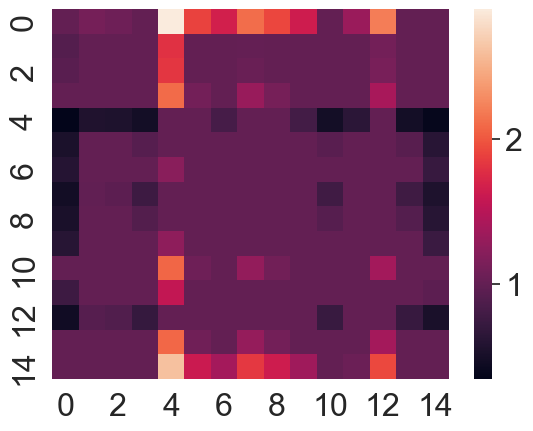

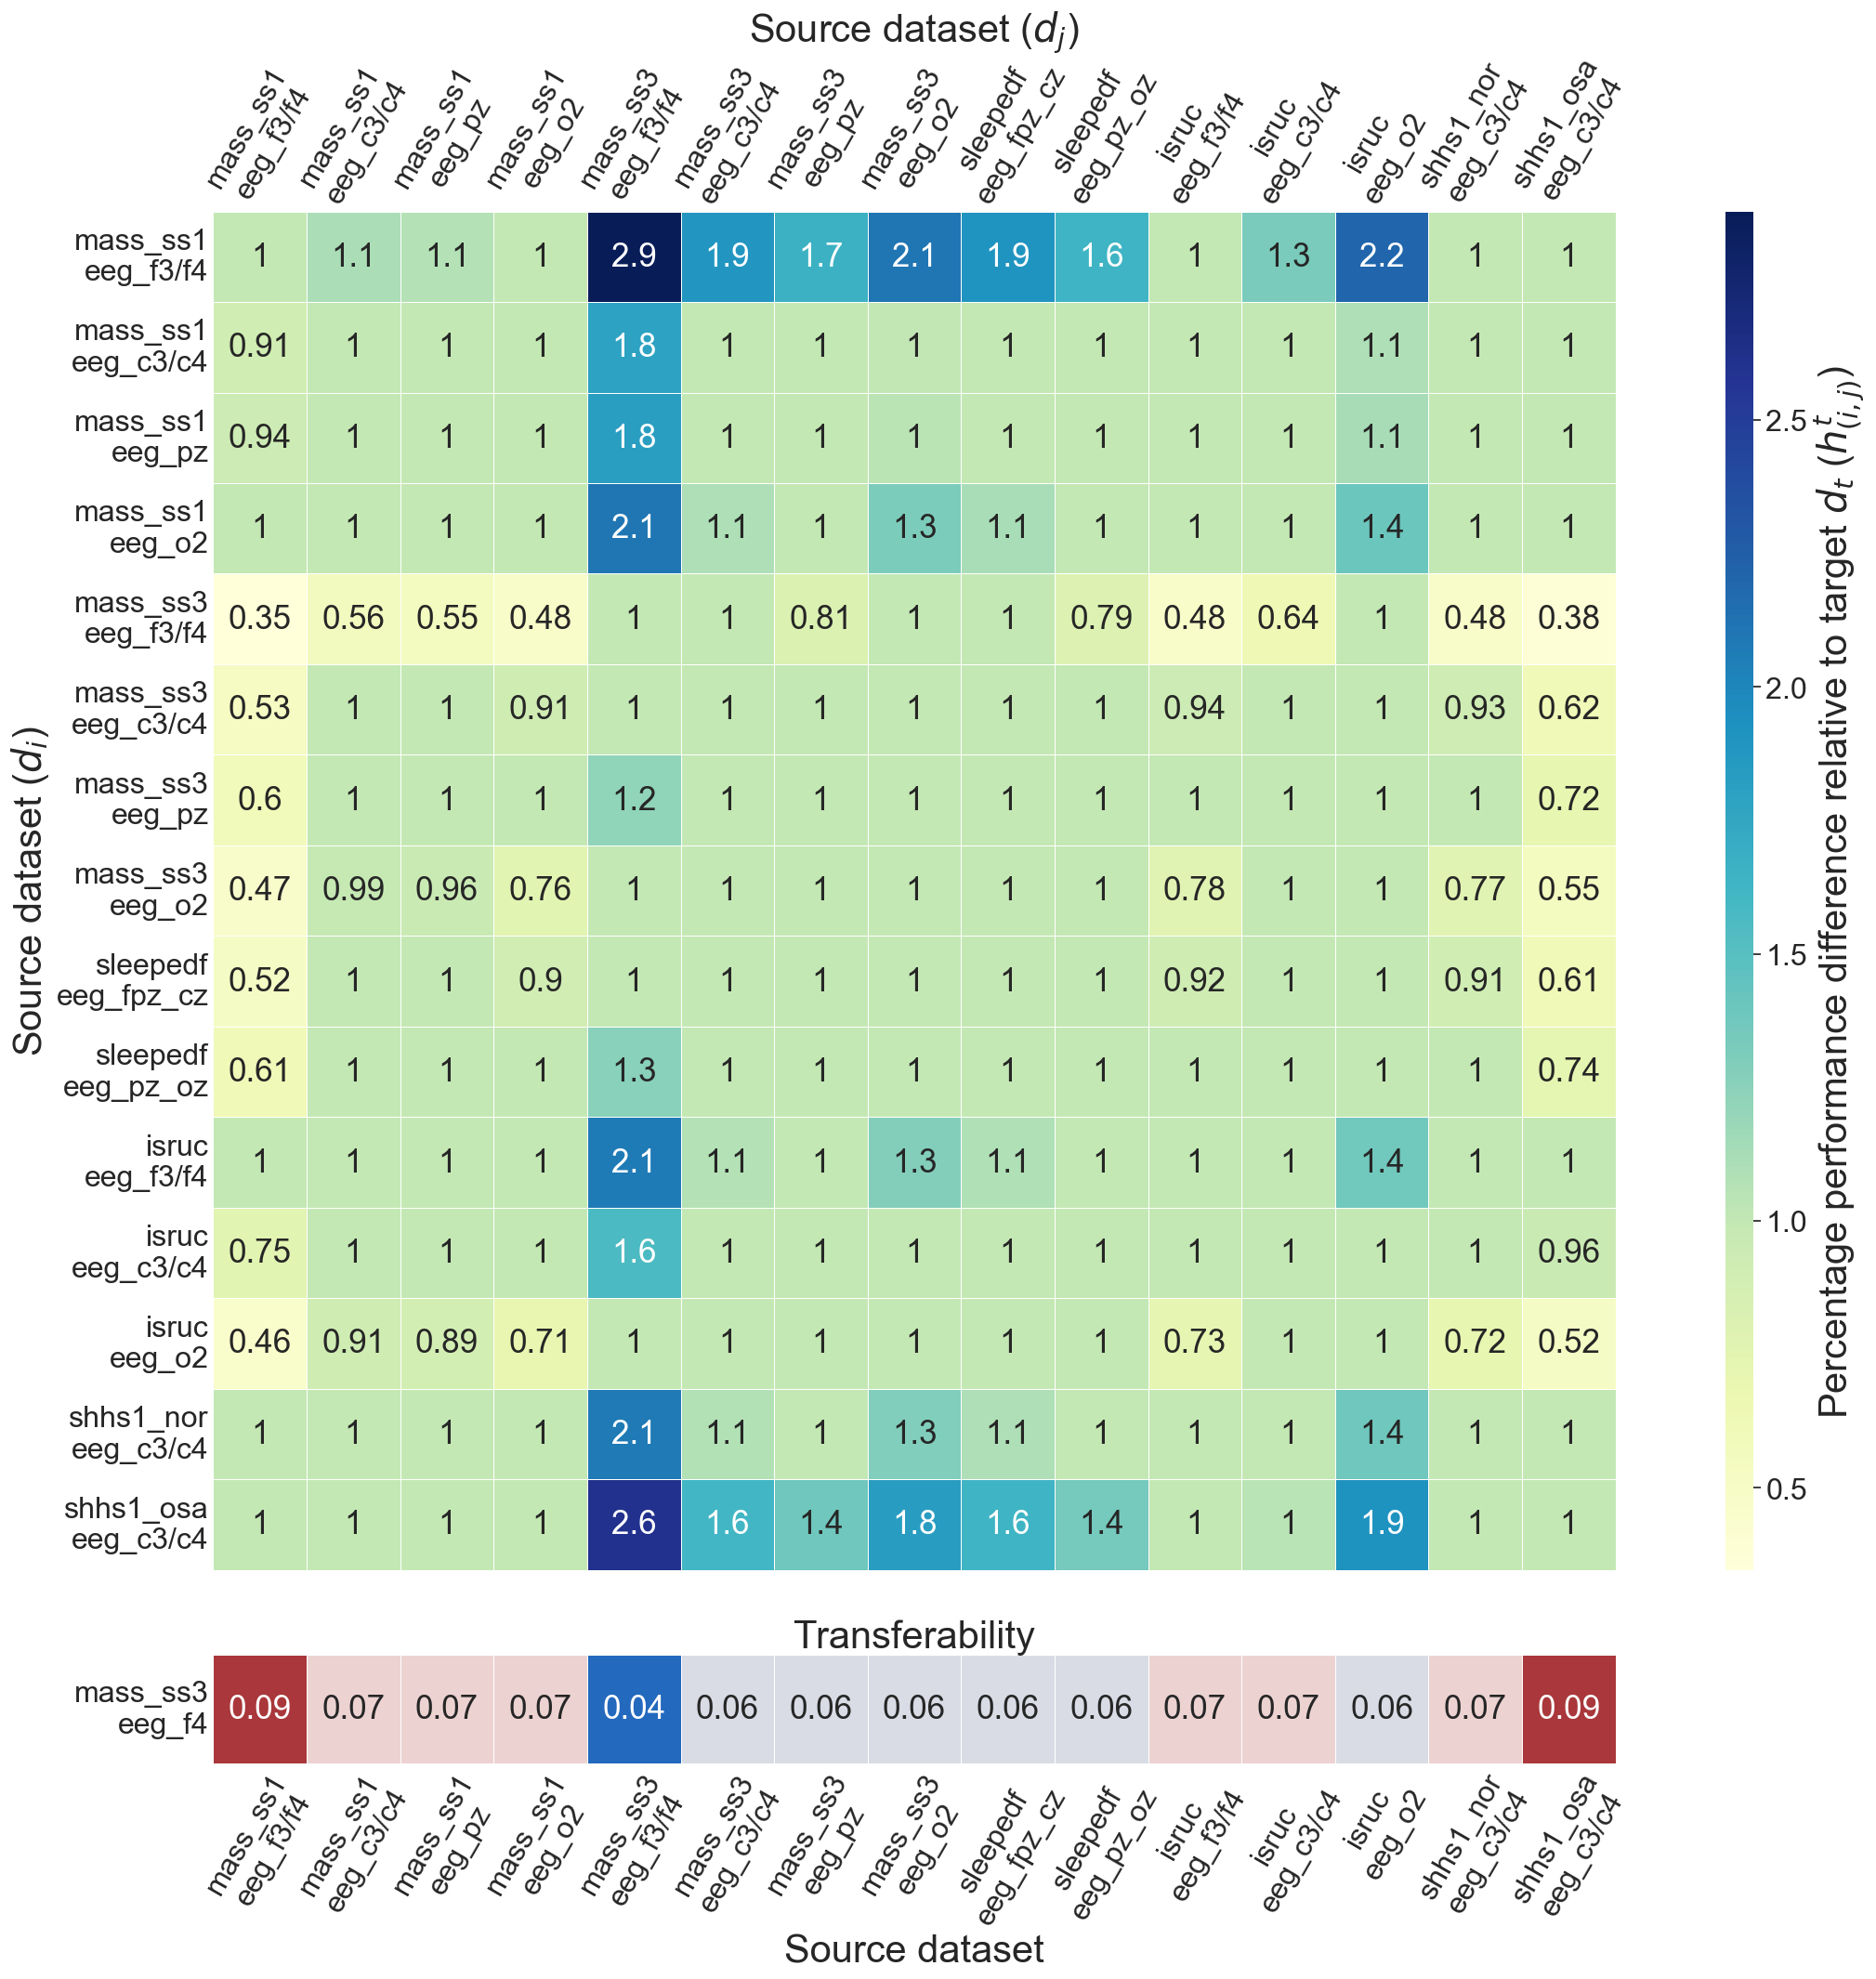

source_dataset source_channel target_dataset target_channel  acc_type3  \
4            isruc      eeg_c4_a1       mass_ss3         eeg_c4  75.454626   
13           isruc      eeg_f4_a1       mass_ss3         eeg_c4  74.413791   
22           isruc      eeg_o2_a1       mass_ss3         eeg_c4  75.368875   
31        mass_ss1         eeg_c4       mass_ss3         eeg_c4  86.344954   
40        mass_ss1         eeg_f4       mass_ss3         eeg_c4  85.845235   
49        mass_ss1         eeg_o2       mass_ss3         eeg_c4  71.720039   
58        mass_ss1         eeg_pz       mass_ss3         eeg_c4  85.378781   
83        mass_ss3         eeg_c3       mass_ss3         eeg_c4  86.436618   
97        mass_ss3         eeg_f4       mass_ss3         eeg_c4  82.229664   
105       mass_ss3         eeg_o2       mass_ss3         eeg_c4  85.653775   
114       mass_ss3         eeg_pz       mass_ss3         eeg_c4  84.926373   
154   shhs1_normal      eeg_c4_a1       mass_ss3         eeg_c4  82.155002   
163      shhs1_osa      eeg_c4_a1       mass_ss3         eeg_c4  82.870576   
171       sleepedf     eeg_fpz_cz       mass_ss3         eeg_c4  76.714273   
179       sleepedf      eeg_pz_oz       mass_ss3         eeg_c4  76.746799   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
4    73.420109  87.640084  83.140996  88.130932  83.746123  
13   72.096399  88.036311  83.585644  87.962388  83.587056  
22   72.573943  88.459150  84.097995  87.932819  83.514229  
31   82.214748  88.388184  83.970943  89.009137  84.877531  
40   81.580996  87.601644  82.822186  88.808066  84.600563  
49   68.762015  88.173068  83.785980  88.550075  84.351891  
58   81.207967  87.929123  83.432576  87.833762  83.594927  
83   81.865263  87.433100  83.035487  87.906207  83.538160  
97   77.849717  87.782755  83.063791  88.142021  83.768270  
105  81.641589  88.383749  84.040360  87.893640  83.469033  
114  80.457836  87.640823  83.080065  88.082143  83.637272  
154  75.979551  88.346787  83.836379  88.163458  83.709658  
163  76.370648  88.618824  84.159892  87.950560  83.672434  
171  70.254522  88.031136  83.474896  87.937993  83.603110  
179  71.122028  88.423667  83.996184  86.472101  82.299215

Target: mass_ss3-eeg_c4
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

/var/folders/nb/9lsbxq3s3x976rmt497ftw_00000gp/T/ipykernel_45979/3008615138.py:125: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[1,0])


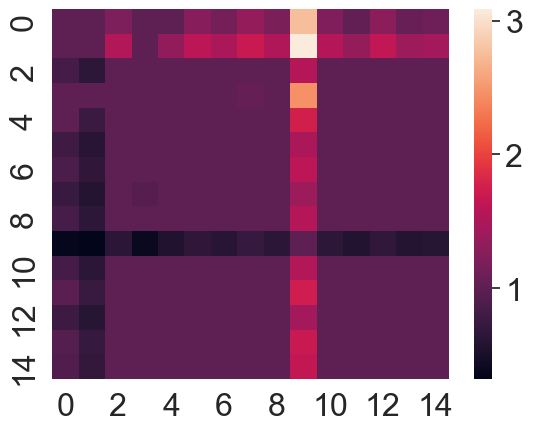

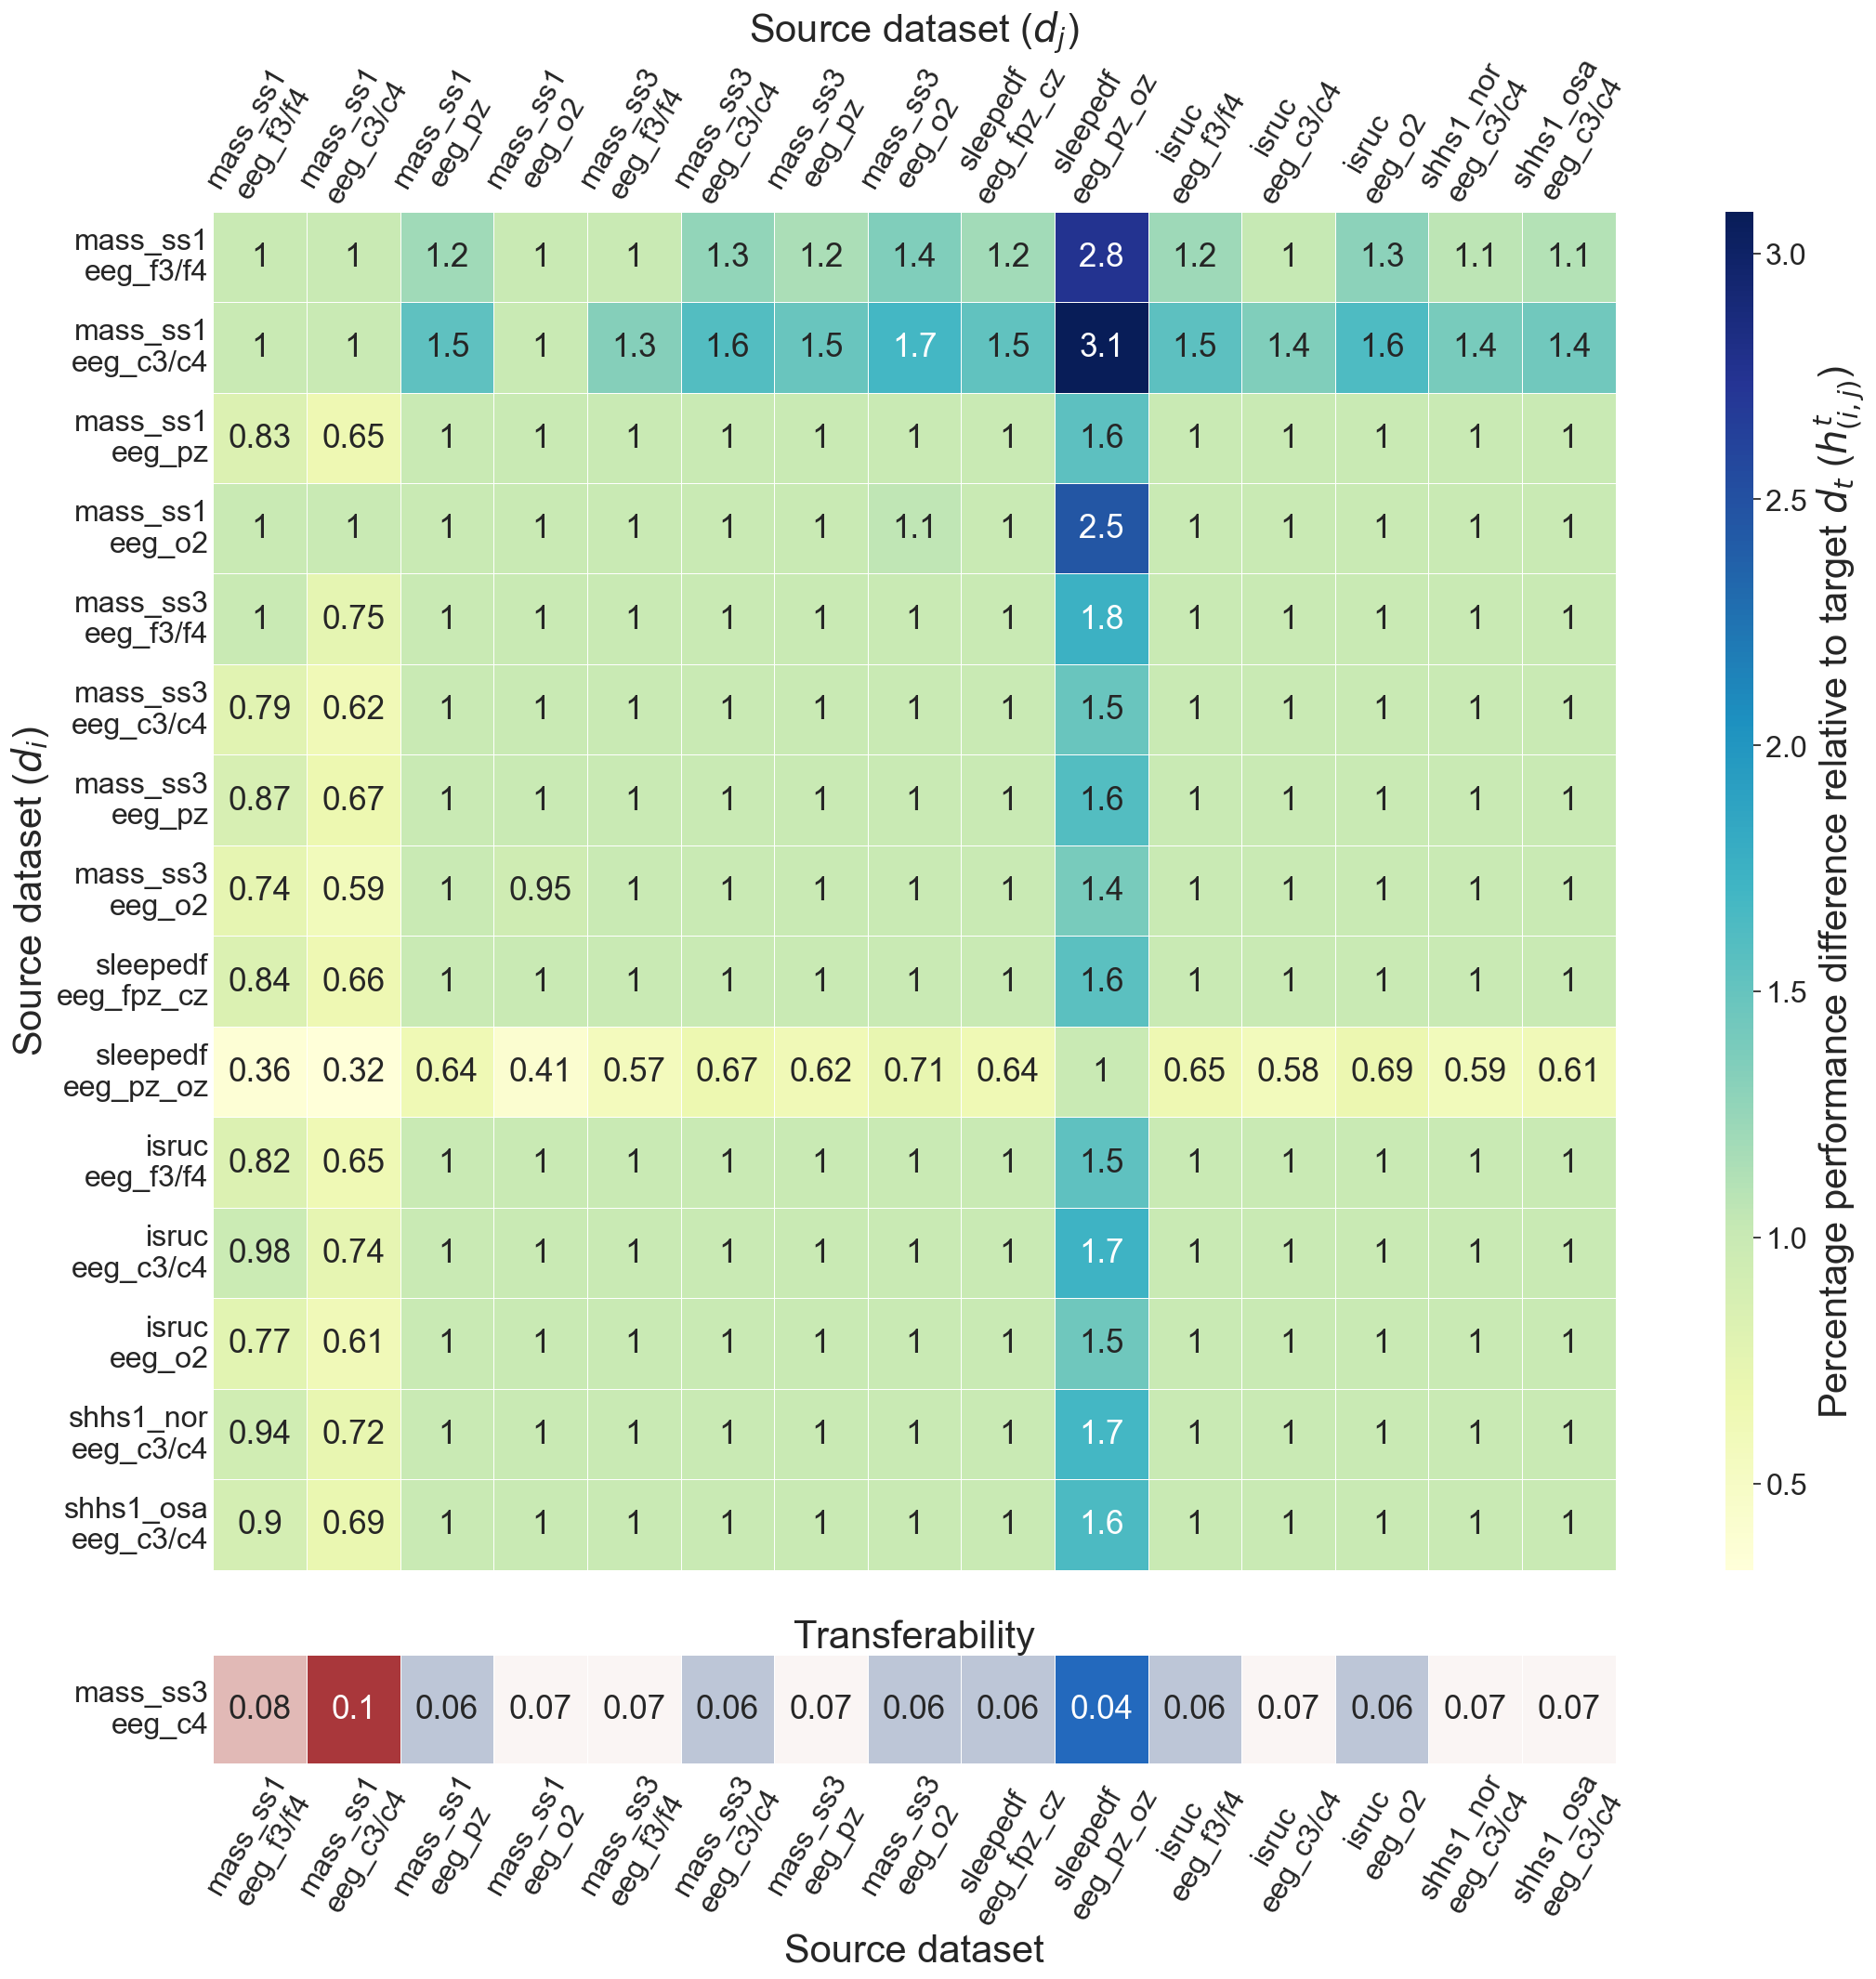

source_dataset source_channel target_dataset target_channel  acc_type3  \
8            isruc      eeg_c4_a1       sleepedf     eeg_fpz_cz  78.034134   
17           isruc      eeg_f4_a1       sleepedf     eeg_fpz_cz  80.458281   
26           isruc      eeg_o2_a1       sleepedf     eeg_fpz_cz  76.814159   
35        mass_ss1         eeg_c4       sleepedf     eeg_fpz_cz  77.550569   
44        mass_ss1         eeg_f4       sleepedf     eeg_fpz_cz  69.873578   
53        mass_ss1         eeg_o2       sleepedf     eeg_fpz_cz  70.581542   
62        mass_ss1         eeg_pz       sleepedf     eeg_fpz_cz  76.936367   
91        mass_ss3         eeg_c4       sleepedf     eeg_fpz_cz  79.759798   
100       mass_ss3         eeg_f4       sleepedf     eeg_fpz_cz  76.725664   
109       mass_ss3         eeg_o2       sleepedf     eeg_fpz_cz  79.304678   
118       mass_ss3         eeg_pz       sleepedf     eeg_fpz_cz  80.960809   
157   shhs1_normal      eeg_c4_a1       sleepedf     eeg_fpz_cz  81.129372   
166      shhs1_osa      eeg_c4_a1       sleepedf     eeg_fpz_cz  84.715550   
183       sleepedf      eeg_pz_oz       sleepedf     eeg_fpz_cz  77.645386   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
8    73.644386  86.052465  81.082653  87.101770  81.944060  
17   76.069508  85.331858  80.769823  87.152339  82.082955  
26   71.284205  86.618205  82.045768  87.199747  81.980108  
35   71.405684  87.275601  82.611578  87.585335  83.001893  
44   65.616928  87.083860  82.841527  87.867678  82.965807  
53   63.010094  86.970080  82.921687  86.906869  81.742408  
62   70.900783  86.354825  81.832943  87.404130  82.200533  
91   74.309059  87.560051  83.361141  88.301728  84.092643  
100  71.863443  84.317320  79.209509  87.566372  82.636822  
109  73.484041  86.567636  81.805893  86.422250  81.335487  
118  74.561265  86.725664  82.125038  87.708597  82.856080  
157  72.697500  87.366203  83.276739  88.112094  83.426881  
166  77.735710  84.909397  79.717432  87.812895  83.271564  
183  69.309273  86.738306  82.168206  86.975348  82.115964

Target: sleepedf-eeg_fpz_cz
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: 

/var/folders/nb/9lsbxq3s3x976rmt497ftw_00000gp/T/ipykernel_45979/3008615138.py:125: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[1,0])


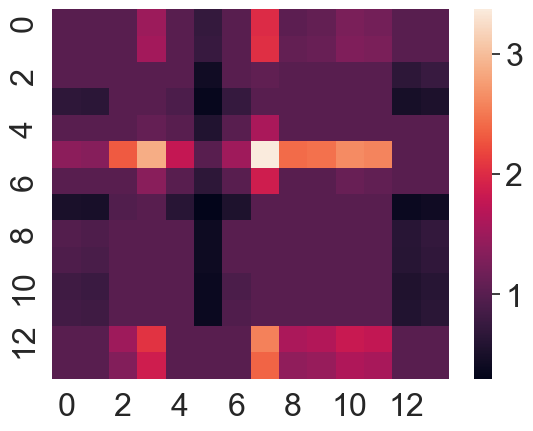

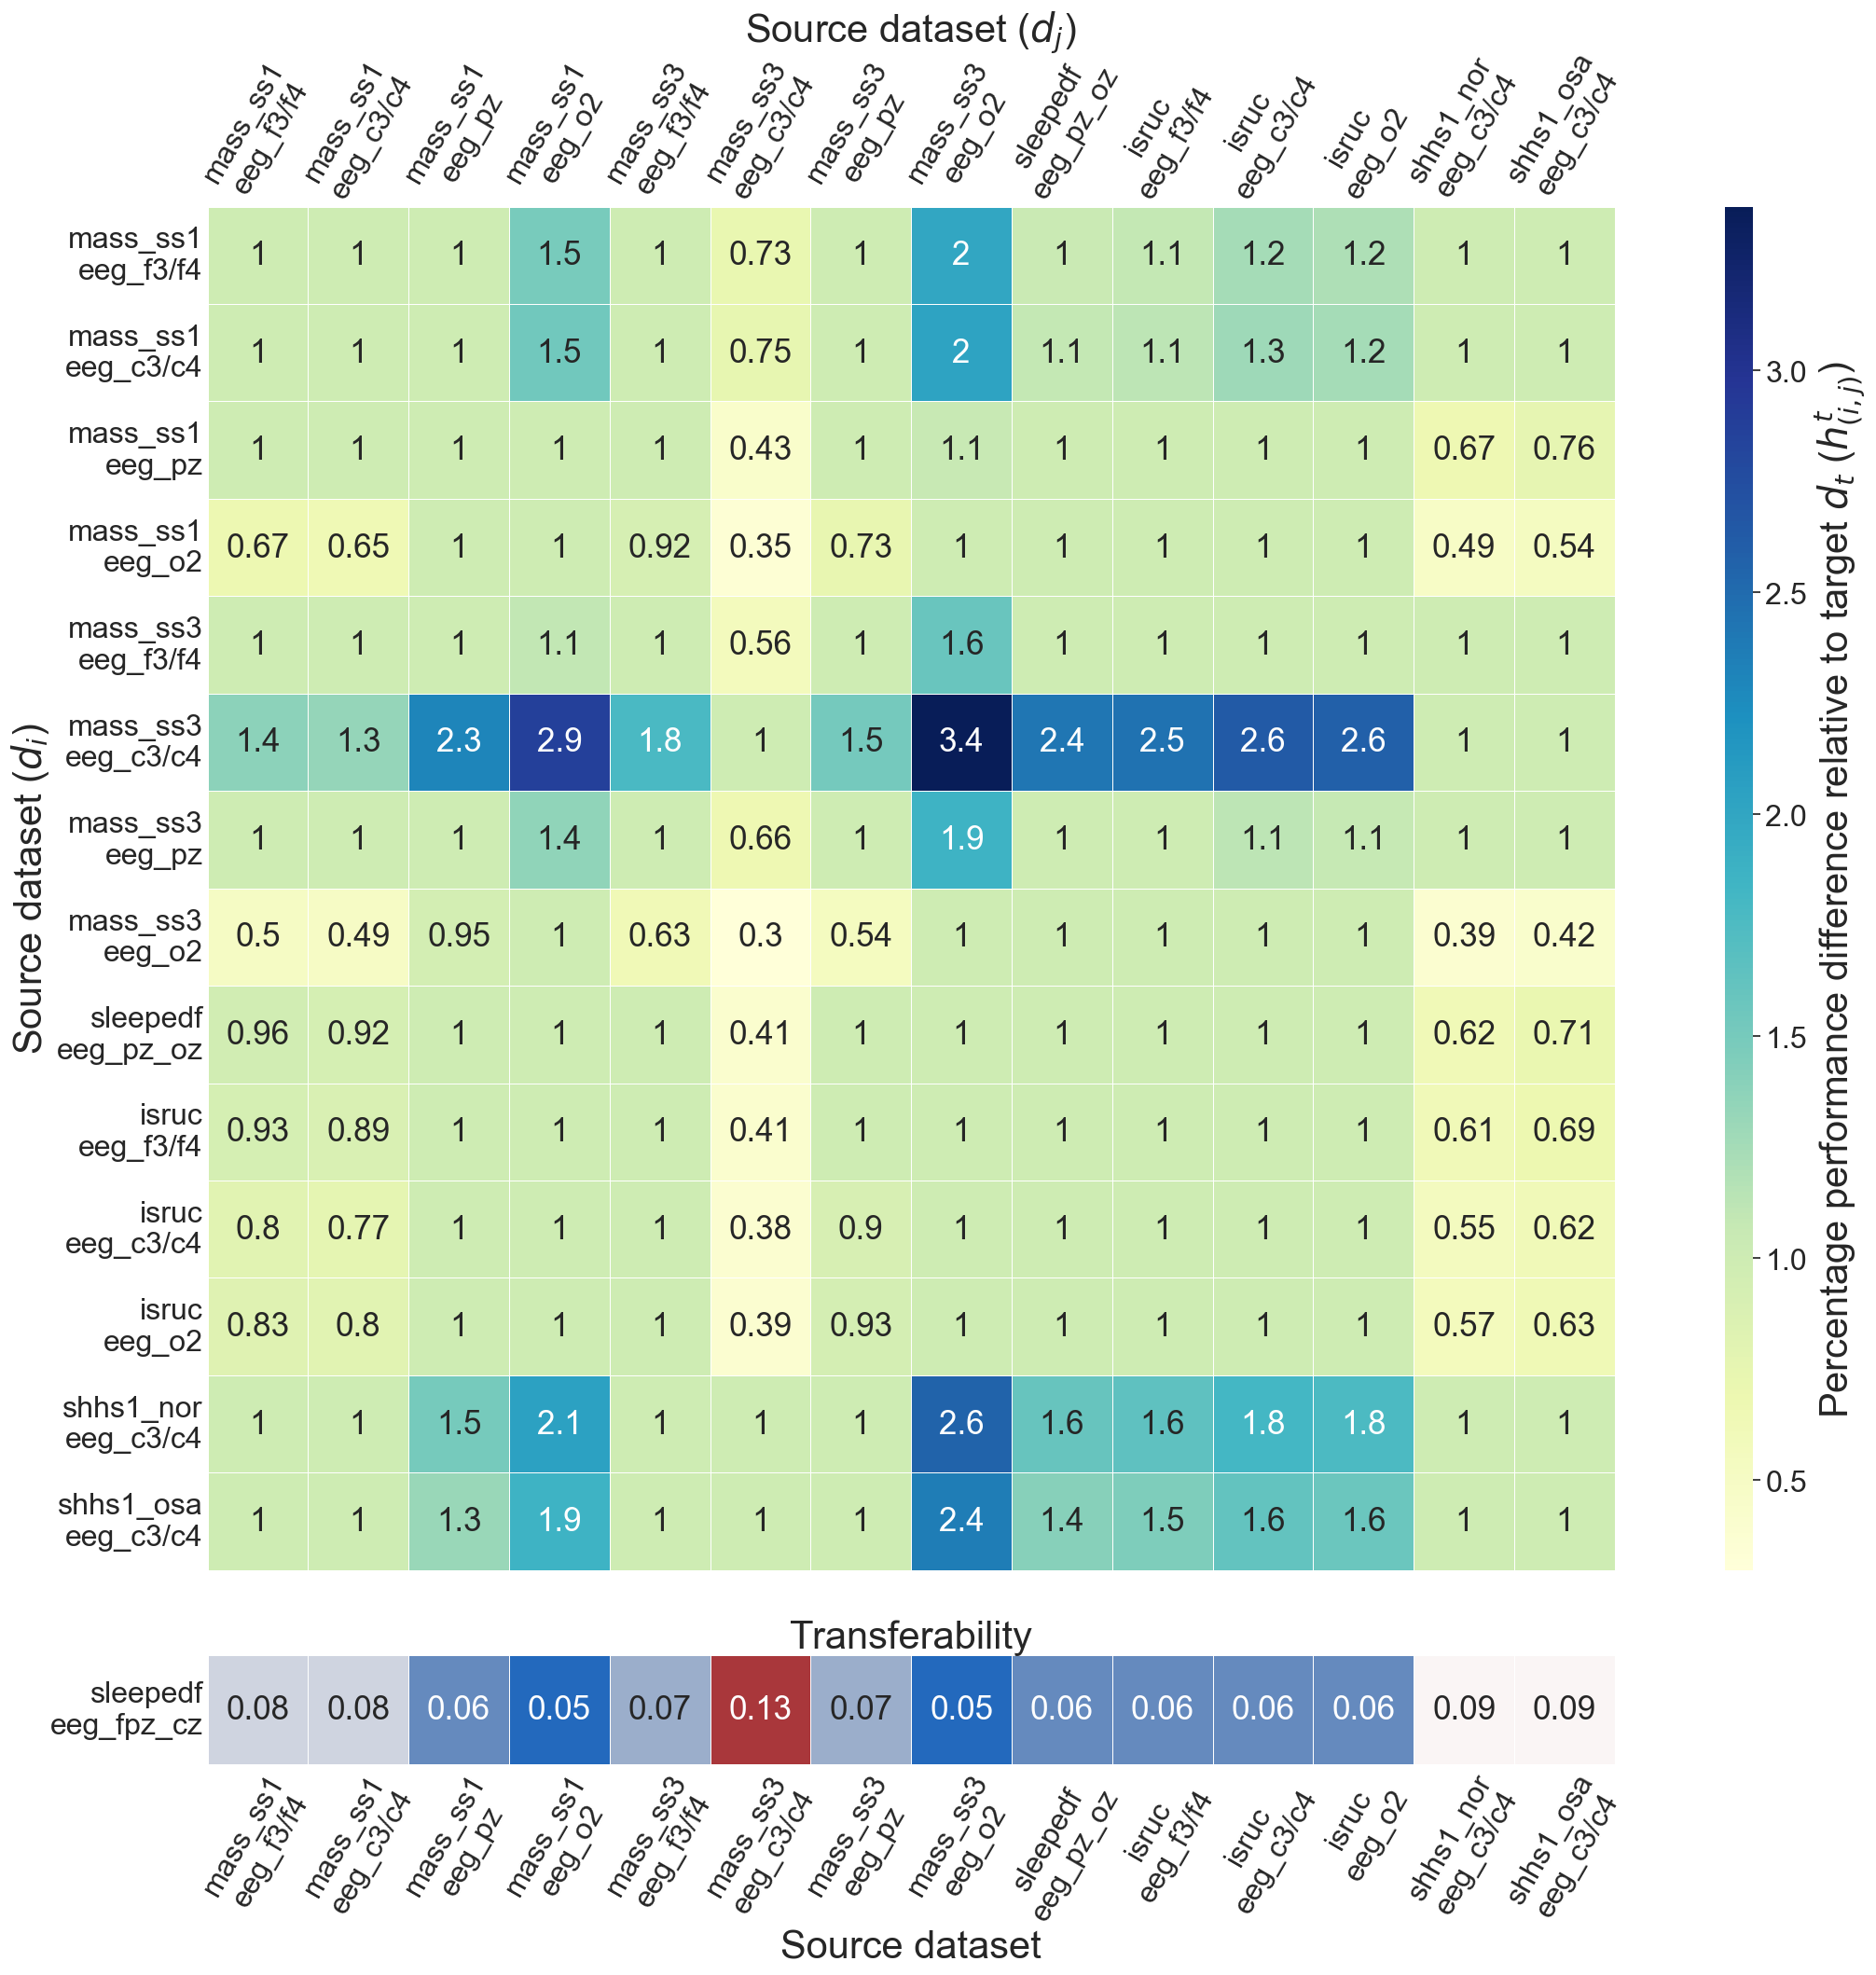

source_dataset source_channel target_dataset target_channel  acc_type3  \
1            isruc      eeg_c4_a1          isruc      eeg_f4_a1  78.662087   
9            isruc      eeg_f3_a2          isruc      eeg_f4_a1  78.142466   
19           isruc      eeg_o2_a1          isruc      eeg_f4_a1  71.749825   
29        mass_ss1         eeg_c4          isruc      eeg_f4_a1  62.115743   
38        mass_ss1         eeg_f4          isruc      eeg_f4_a1  64.867645   
46        mass_ss1         eeg_o2          isruc      eeg_f4_a1  59.833489   
55        mass_ss1         eeg_pz          isruc      eeg_f4_a1  61.601459   
85        mass_ss3         eeg_c4          isruc      eeg_f4_a1  62.529110   
94        mass_ss3         eeg_f4          isruc      eeg_f4_a1  61.730030   
102       mass_ss3         eeg_o2          isruc      eeg_f4_a1  58.638507   
111       mass_ss3         eeg_pz          isruc      eeg_f4_a1  60.990626   
151   shhs1_normal      eeg_c4_a1          isruc      eeg_f4_a1  62.005123   
160      shhs1_osa      eeg_c4_a1          isruc      eeg_f4_a1  64.266030   
168       sleepedf     eeg_fpz_cz          isruc      eeg_f4_a1  53.436481   
176       sleepedf      eeg_pz_oz          isruc      eeg_f4_a1  55.990918   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
1    76.676414  79.091465  77.706417  78.697019  77.117066  
9    76.939201  78.762517  77.417750  79.563053  78.129922  
19   68.570562  78.833838  77.541206  78.280741  76.923780  
29   58.756669  78.215242  76.676991  79.075454  77.774163  
38   62.645886  79.316100  77.841284  79.781866  78.330135  
46   53.897255  79.242354  77.467740  79.591678  78.051370  
55   57.801977  79.108446  78.015706  79.387906  78.013088  
85   59.669834  78.409797  77.183826  79.277286  77.749252  
94   58.325353  78.681008  77.311374  78.740685  76.990291  
102  56.719469  79.712972  78.511368  79.590708  78.190696  
111  59.251660  79.522299  78.108191  79.343270  77.719116  
151  55.665478  79.593619  77.968881  79.032759  77.514277  
160  58.546418  78.735833  77.356635  79.710061  78.157642  
168  48.484042  80.072485  78.441005  78.363705  76.926824  
176  50.461817  79.076910  77.787297  78.654809  77.338381

Target: isruc-eeg_f4_a1
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

/var/folders/nb/9lsbxq3s3x976rmt497ftw_00000gp/T/ipykernel_45979/3008615138.py:125: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[1,0])


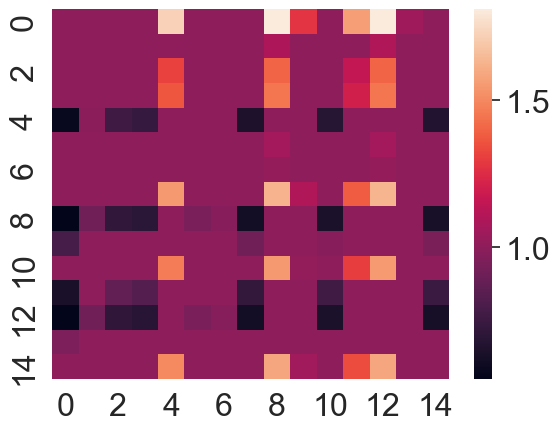

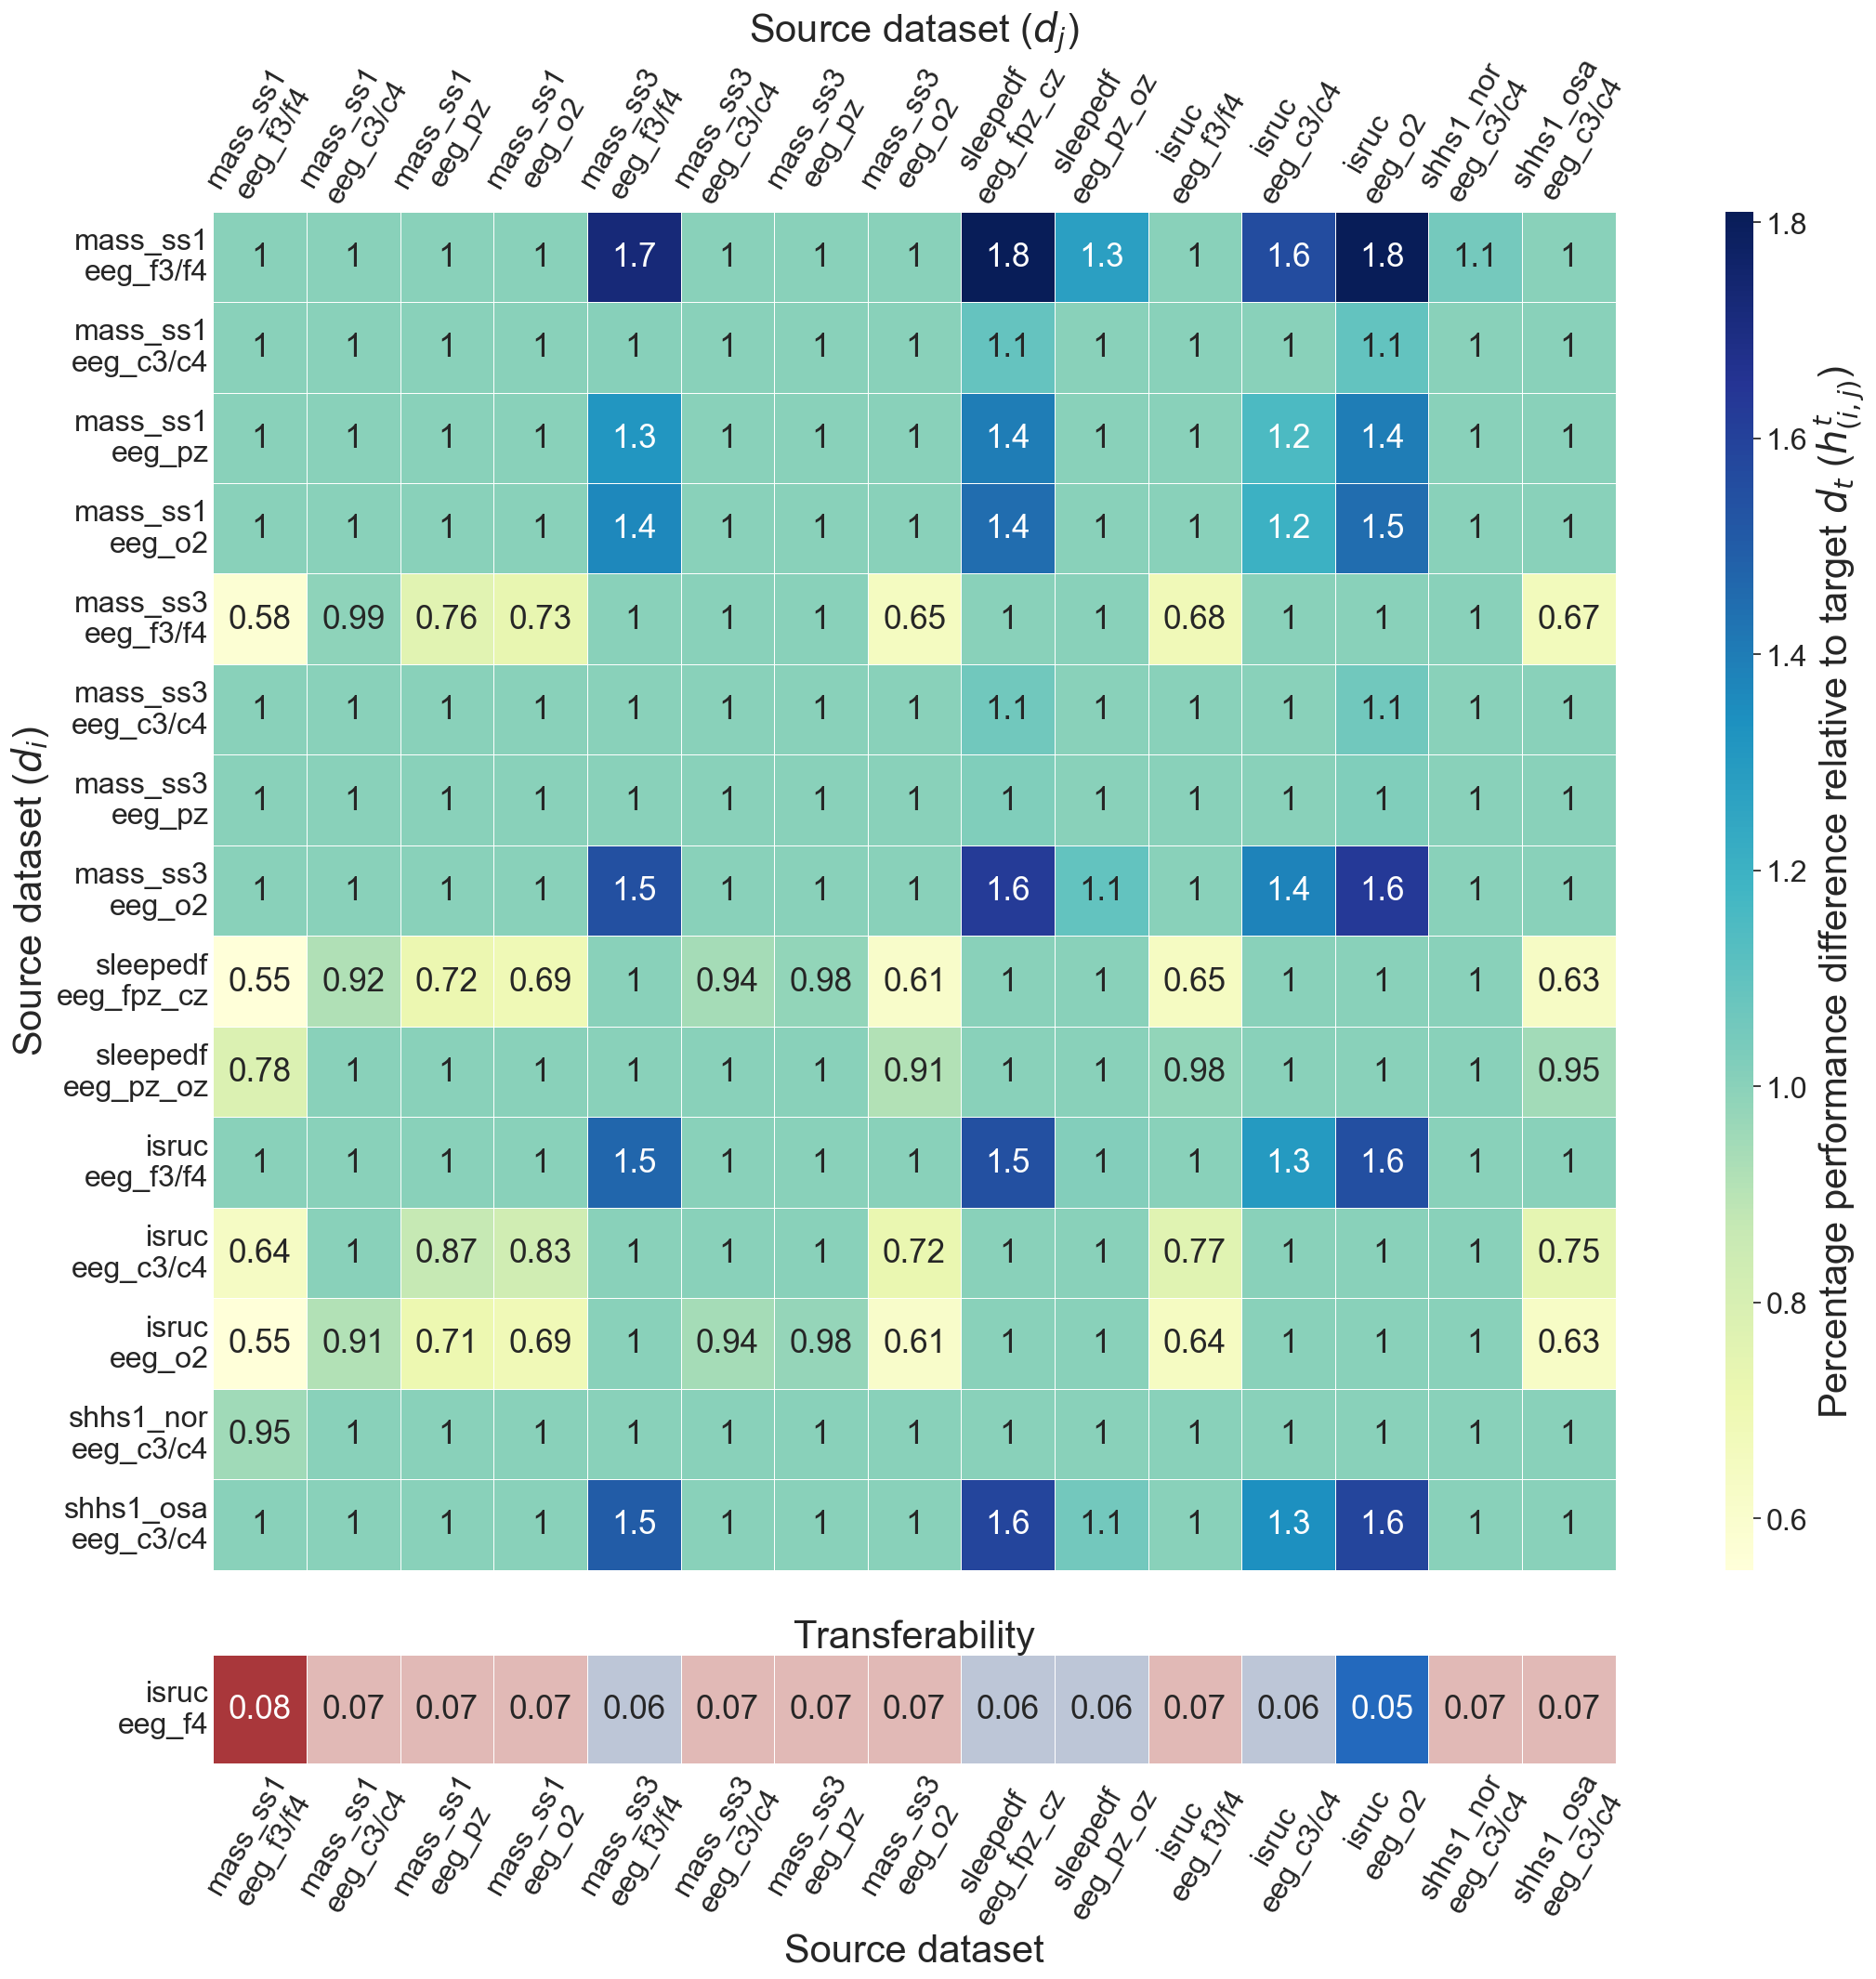

source_dataset source_channel target_dataset target_channel  acc_type3  \
0            isruc      eeg_c3_a2          isruc      eeg_c4_a1  78.320525   
10           isruc      eeg_f4_a1          isruc      eeg_c4_a1  75.512343   
18           isruc      eeg_o2_a1          isruc      eeg_c4_a1  75.368732   
28        mass_ss1         eeg_c4          isruc      eeg_c4_a1  66.400792   
37        mass_ss1         eeg_f4          isruc      eeg_c4_a1  62.286524   
45        mass_ss1         eeg_o2          isruc      eeg_c4_a1  61.989598   
54        mass_ss1         eeg_pz          isruc      eeg_c4_a1  63.073475   
84        mass_ss3         eeg_c4          isruc      eeg_c4_a1  62.993421   
93        mass_ss3         eeg_f4          isruc      eeg_c4_a1  60.409874   
101       mass_ss3         eeg_o2          isruc      eeg_c4_a1  64.376164   
110       mass_ss3         eeg_pz          isruc      eeg_c4_a1  62.916279   
150   shhs1_normal      eeg_c4_a1          isruc      eeg_c4_a1  65.715727   
159      shhs1_osa      eeg_c4_a1          isruc      eeg_c4_a1  66.344512   
167       sleepedf     eeg_fpz_cz          isruc      eeg_c4_a1  51.066896   
175       sleepedf      eeg_pz_oz          isruc      eeg_c4_a1  58.517699   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
0    77.073438  78.881385  77.360915  79.657662  78.352706  
10   75.109786  79.137556  77.665485  79.275345  77.804691  
18   73.094913  78.924080  77.227588  78.832868  77.172724  
28   64.260782  78.827045  77.242212  78.828986  77.258652  
37   60.197421  79.226828  77.494498  79.044403  77.534328  
45   57.875025  79.203540  77.514107  79.684832  78.055345  
54   60.558073  78.977934  77.255319  80.235503  78.737918  
84   59.874383  79.085643  77.106150  79.331626  77.782429  
93   56.480803  79.631463  77.989459  79.496099  77.974977  
101  61.720924  79.718794  78.033081  79.595075  78.032482  
110  60.556105  78.534001  76.931245  79.646018  78.319123  
150  60.730014  79.019174  77.525999  79.217125  77.850422  
159  61.253038  77.761605  76.140278  78.801816  77.031802  
167  47.729302  78.861493  77.393581  79.305426  77.437104  
175  54.684995  78.746507  77.103382  78.779984  77.303551

Target: isruc-eeg_c4_a1
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: mass

/var/folders/nb/9lsbxq3s3x976rmt497ftw_00000gp/T/ipykernel_45979/3008615138.py:125: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[1,0])


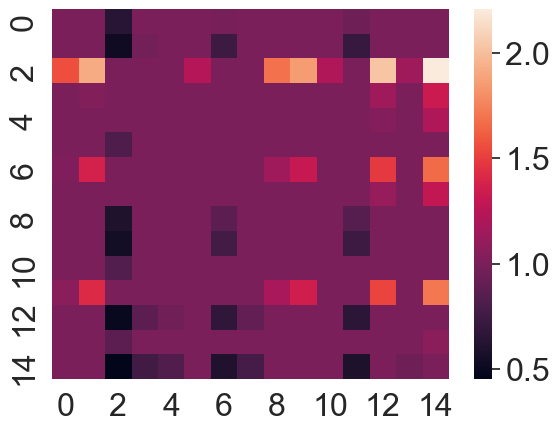

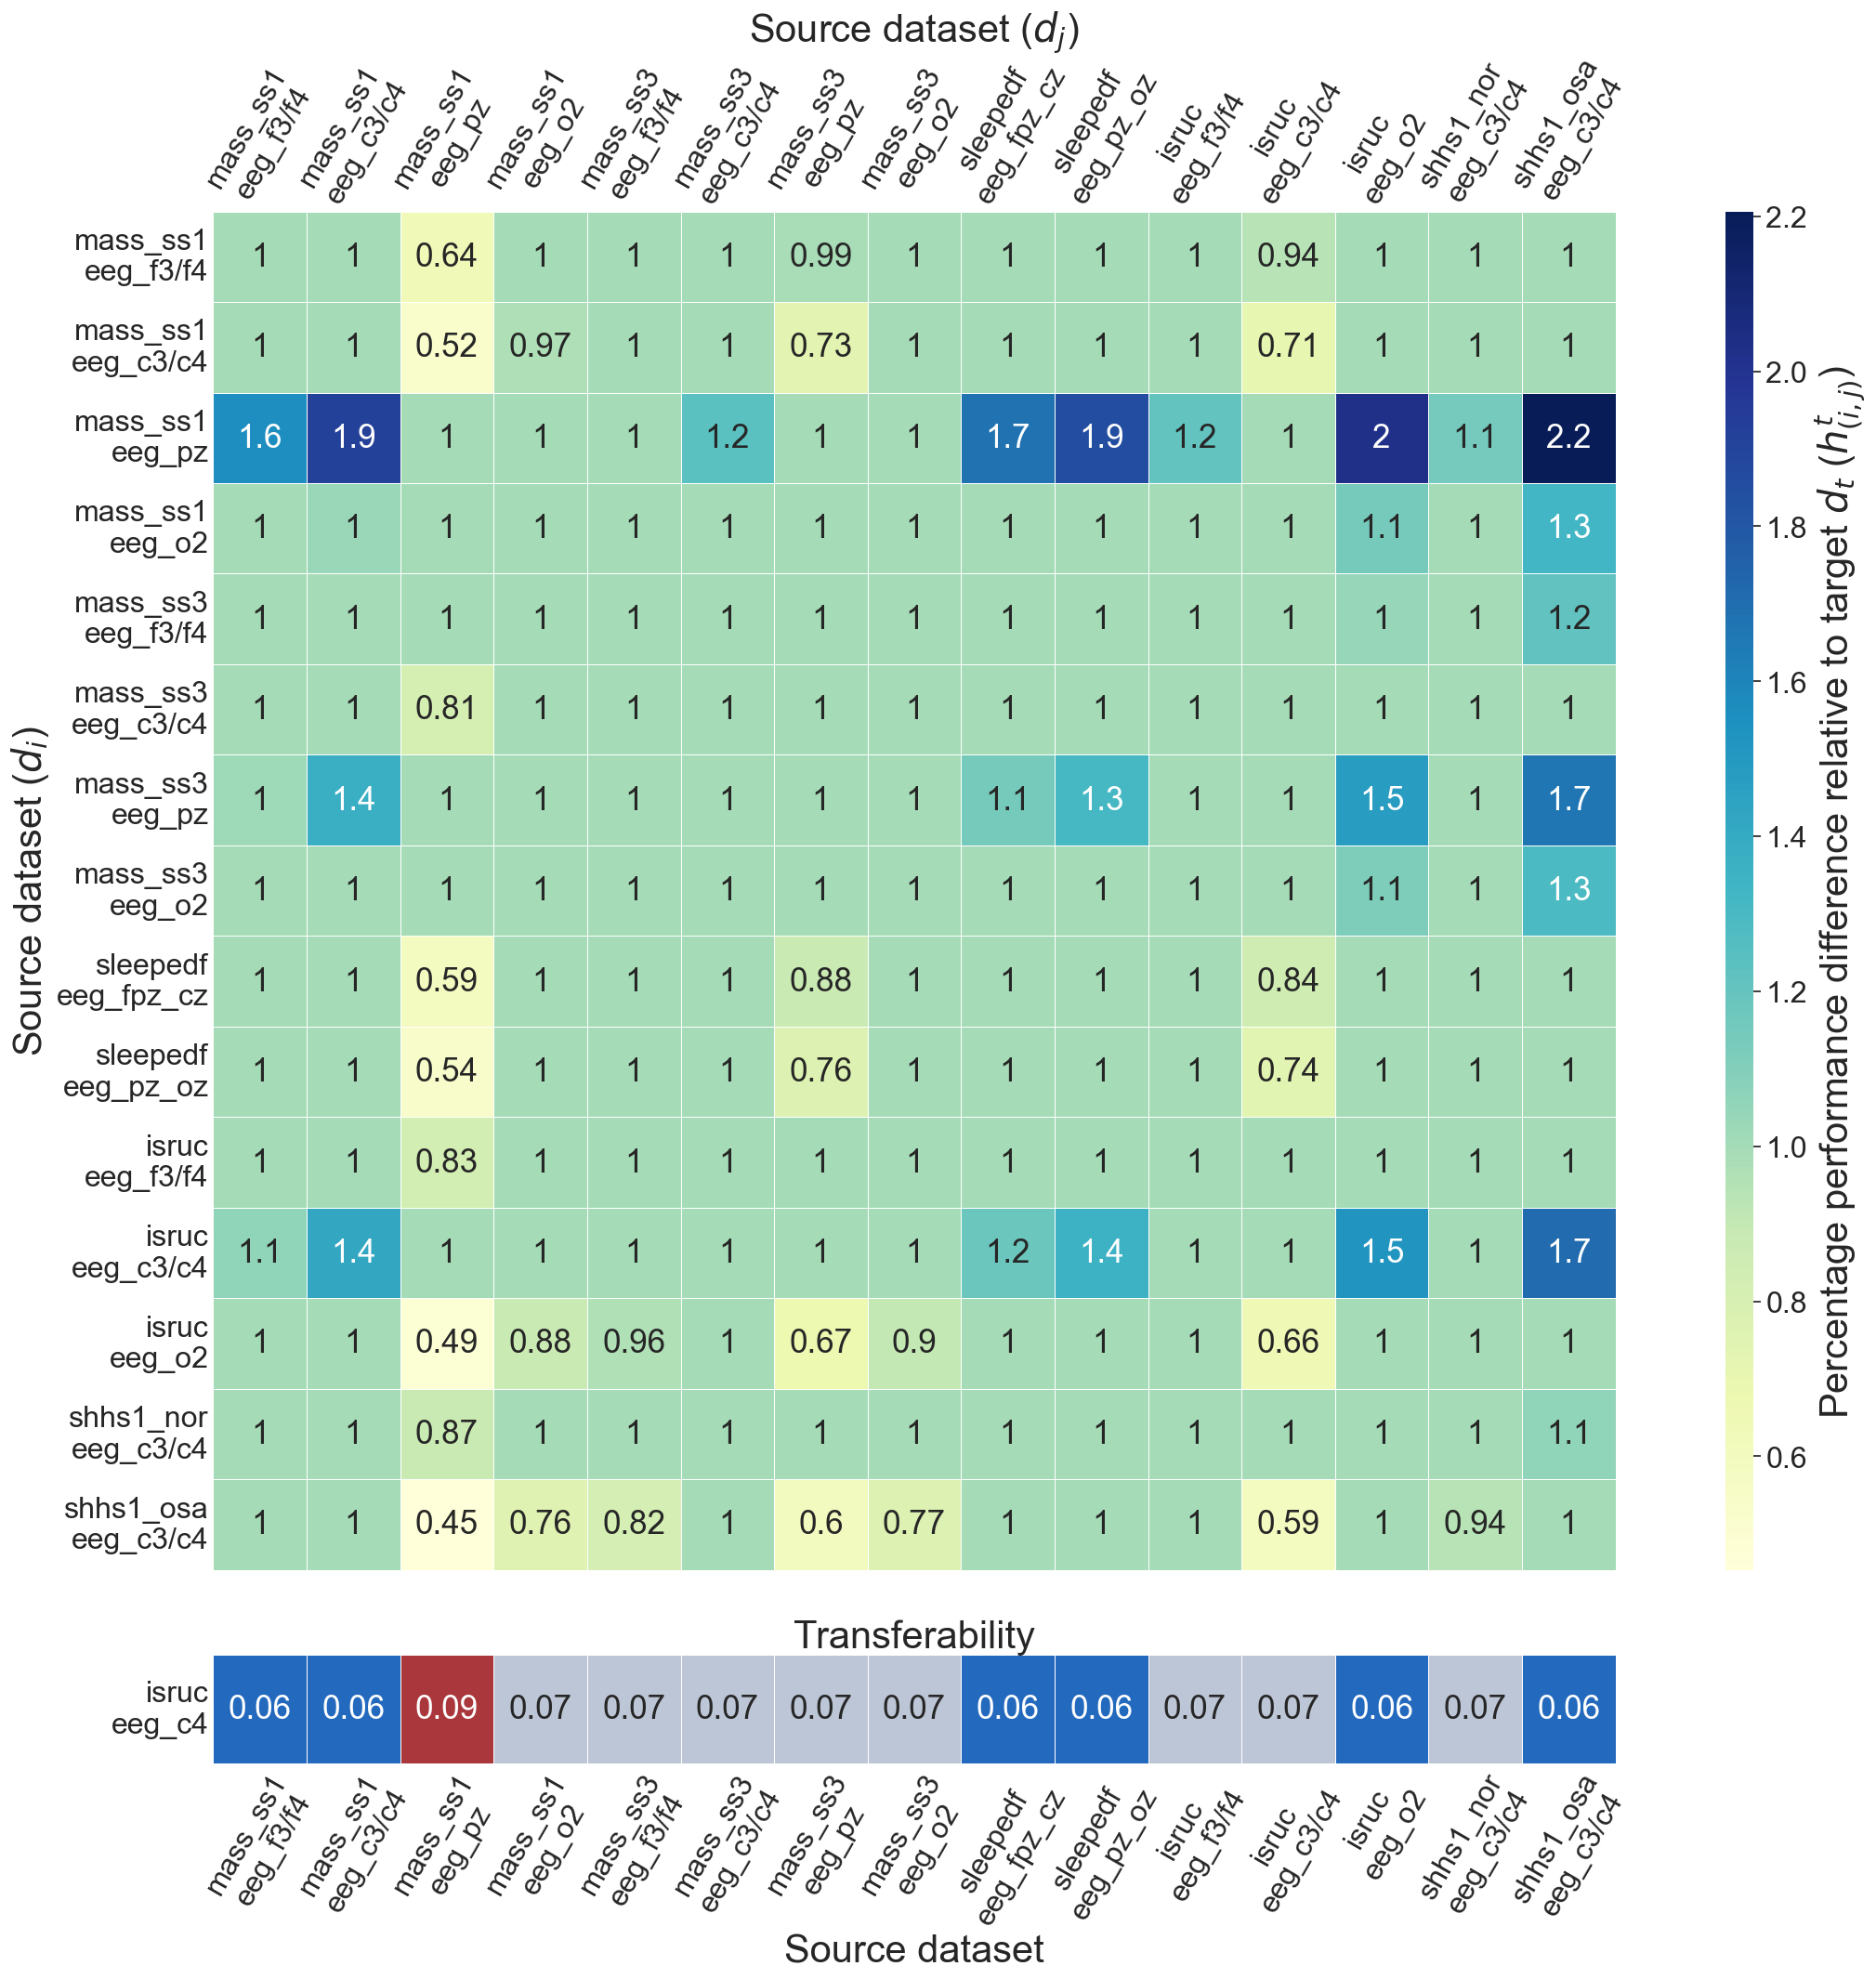

source_dataset source_channel target_dataset target_channel  acc_type3  \
6            isruc      eeg_c4_a1   shhs1_normal      eeg_c4_a1  76.155930   
15           isruc      eeg_f4_a1   shhs1_normal      eeg_c4_a1  72.667989   
24           isruc      eeg_o2_a1   shhs1_normal      eeg_c4_a1  73.744438   
33        mass_ss1         eeg_c4   shhs1_normal      eeg_c4_a1  71.621203   
42        mass_ss1         eeg_f4   shhs1_normal      eeg_c4_a1  68.748791   
51        mass_ss1         eeg_o2   shhs1_normal      eeg_c4_a1  71.256529   
60        mass_ss1         eeg_pz   shhs1_normal      eeg_c4_a1  69.073644   
89        mass_ss3         eeg_c4   shhs1_normal      eeg_c4_a1  66.981041   
98        mass_ss3         eeg_f4   shhs1_normal      eeg_c4_a1  63.432643   
107       mass_ss3         eeg_o2   shhs1_normal      eeg_c4_a1  71.158187   
116       mass_ss3         eeg_pz   shhs1_normal      eeg_c4_a1  67.409879   
149   shhs1_normal      eeg_c3_a2   shhs1_normal      eeg_c4_a1  85.998259   
165      shhs1_osa      eeg_c4_a1   shhs1_normal      eeg_c4_a1  86.711915   
173       sleepedf     eeg_fpz_cz   shhs1_normal      eeg_c4_a1  63.614819   
181       sleepedf      eeg_pz_oz   shhs1_normal      eeg_c4_a1  70.529438   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
6    69.958225  85.258270  78.481254  86.860773  79.595325  
15   66.784334  86.737441  79.528490  86.666505  79.457532  
24   66.465658  86.224608  78.594562  86.557361  79.116029  
33   65.469217  85.653898  77.580039  86.879474  79.861472  
42   60.819188  86.734620  79.889541  86.789031  79.194772  
51   63.892635  86.190108  78.934804  86.791449  79.363087  
60   62.241776  85.880570  78.808928  86.614110  79.311335  
89   58.545893  86.062746  79.135500  86.836590  79.559807  
98   53.746862  85.595215  78.140767  87.051009  80.144559  
107  64.317701  86.104662  79.358961  86.198169  78.767688  
116  57.437385  86.117560  78.371491  86.789837  79.906152  
149  79.413478  86.614110  79.205560  86.185271  78.230652  
165  79.303349  86.494271  79.196527  87.093463  79.880044  
173  53.081383  86.427097  79.410426  86.548011  79.338518  
181  61.332524  86.572193  78.841473  86.240085  78.431792

Target: shhs1_normal-eeg_c4_a1
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With sourc

/var/folders/nb/9lsbxq3s3x976rmt497ftw_00000gp/T/ipykernel_45979/3008615138.py:125: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[1,0])


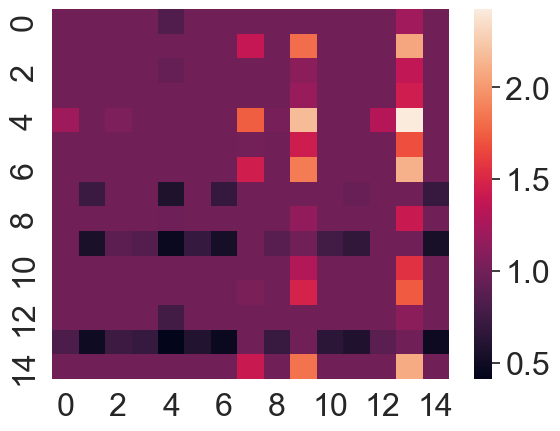

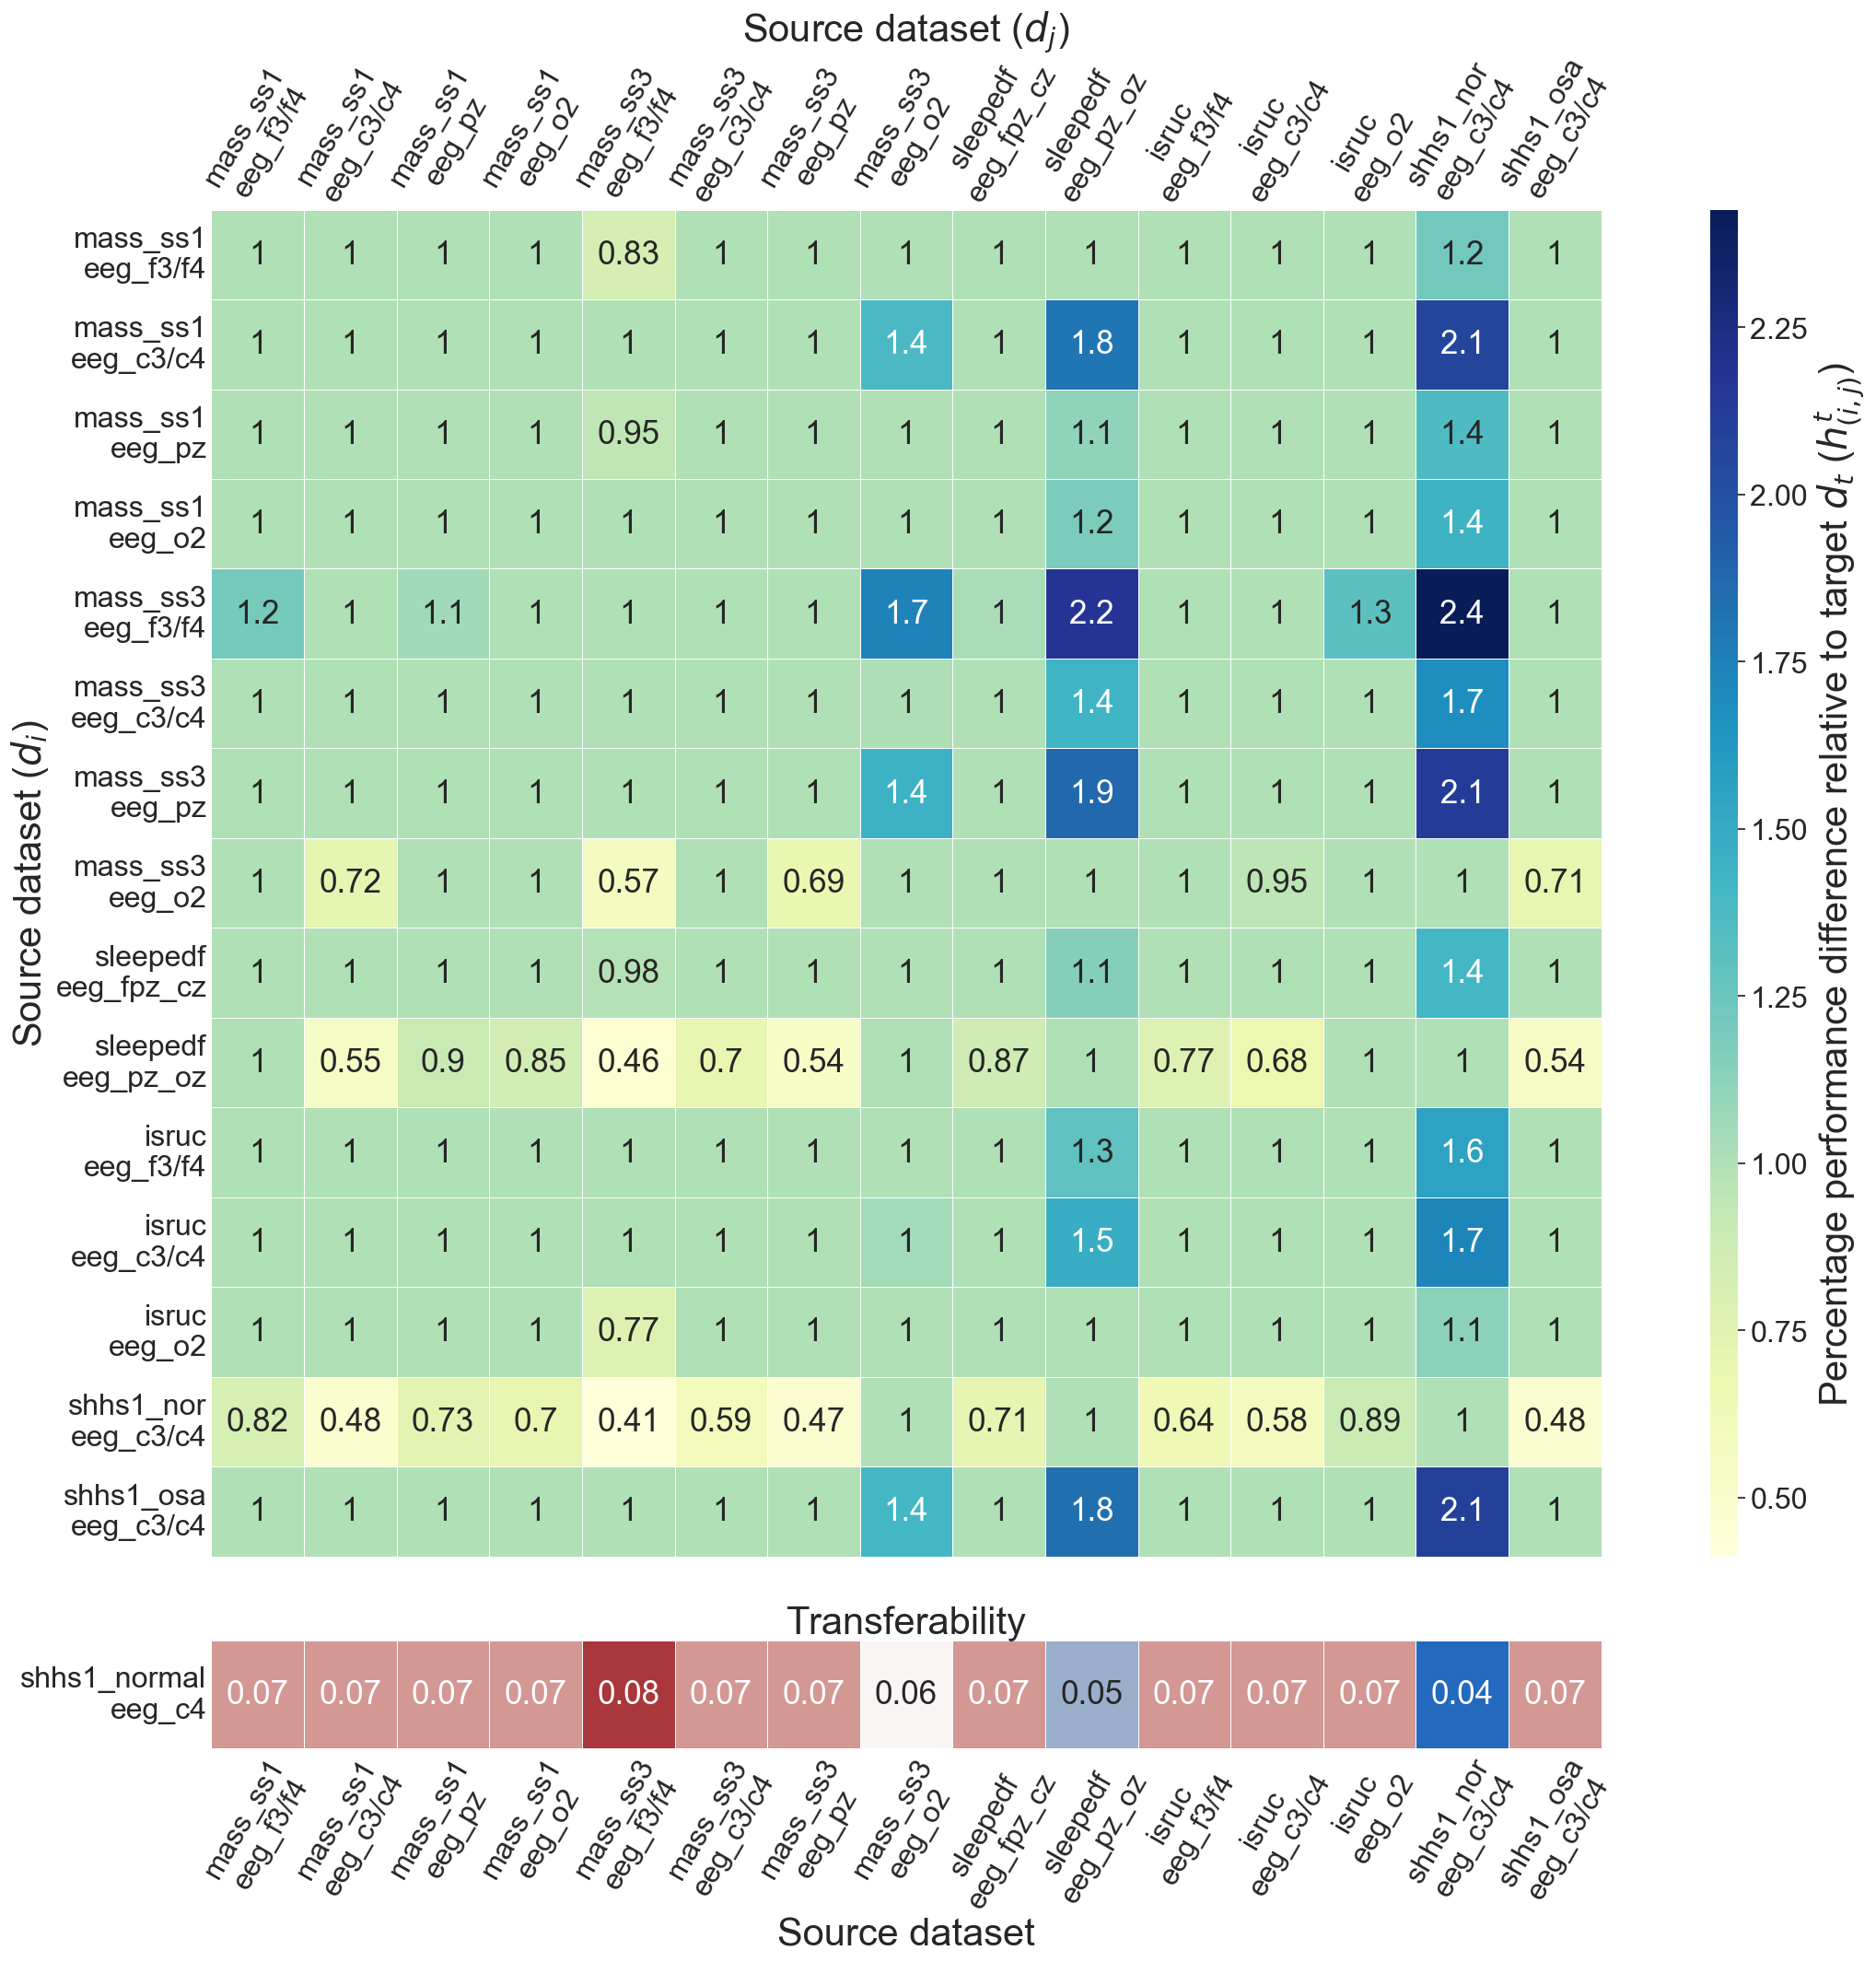

source_dataset source_channel target_dataset target_channel  acc_type3  \
7            isruc      eeg_c4_a1      shhs1_osa      eeg_c4_a1  75.808385   
16           isruc      eeg_f4_a1      shhs1_osa      eeg_c4_a1  71.873056   
25           isruc      eeg_o2_a1      shhs1_osa      eeg_c4_a1  74.603421   
34        mass_ss1         eeg_c4      shhs1_osa      eeg_c4_a1  66.792622   
43        mass_ss1         eeg_f4      shhs1_osa      eeg_c4_a1  62.043157   
52        mass_ss1         eeg_o2      shhs1_osa      eeg_c4_a1  67.402151   
61        mass_ss1         eeg_pz      shhs1_osa      eeg_c4_a1  65.001296   
90        mass_ss3         eeg_c4      shhs1_osa      eeg_c4_a1  65.887442   
99        mass_ss3         eeg_f4      shhs1_osa      eeg_c4_a1  61.330353   
108       mass_ss3         eeg_o2      shhs1_osa      eeg_c4_a1  67.617613   
117       mass_ss3         eeg_pz      shhs1_osa      eeg_c4_a1  64.889515   
156   shhs1_normal      eeg_c4_a1      shhs1_osa      eeg_c4_a1  86.840116   
158      shhs1_osa      eeg_c3_a2      shhs1_osa      eeg_c4_a1  86.483713   
174       sleepedf     eeg_fpz_cz      shhs1_osa      eeg_c4_a1  64.058450   
182       sleepedf      eeg_pz_oz      shhs1_osa      eeg_c4_a1  70.627592   

     mf1_type3  acc_type6  mf1_type6  acc_type9  mf1_type9  
7    69.513147  87.524300  80.473380  87.388219  80.463921  
16   65.130677  87.500000  80.522238  87.728421  80.785382  
25   67.924698  86.695179  79.378936  87.502916  80.232160  
34   60.375449  86.972687  79.733616  87.888802  80.759387  
43   54.214466  86.202372  79.320216  87.983573  80.540028  
52   60.414382  87.213258  79.996570  87.734902  80.552018  
61   58.535547  87.854782  80.901626  87.883942  80.764509  
90   57.652570  87.913103  80.883803  87.796462  80.659248  
99   52.127811  88.060524  80.917776  87.963323  80.773254  
108  61.436588  88.094544  81.112716  87.851542  80.771278  
117  56.689017  87.843442  80.270006  87.777022  80.487917  
156  79.004867  87.318559  80.466217  88.260325  81.083633  
158  79.093426  87.380659  80.307080  87.511340  80.511155  
174  54.961326  87.226218  80.154758  87.342859  79.646265  
182  60.708231  88.118844  81.129868  87.096617  79.738839

Target: shhs1_osa-eeg_c4_a1
Comparing source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_c
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_p
With source: mass_ss1-eeg_o
With source: mass_ss3-eeg_f
With source: mass_ss3-eeg_c
With source: mass_ss3-eeg_p
With source: mass_ss3-eeg_o
With source: sleepedf-eeg_f
With source: sleepedf-eeg_p
With source: isruc-eeg_f
With source: isruc-eeg_c
With source: isruc-eeg_o
With source: shhs1_normal-eeg_c
With source: shhs1_osa-eeg_c
Comparing source: mass_ss1-eeg_p
With source: mass_ss1-eeg_f
With source: mass_ss1-eeg_c
With source: mass_ss1-eeg_o
With source: 

/var/folders/nb/9lsbxq3s3x976rmt497ftw_00000gp/T/ipykernel_45979/3008615138.py:125: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0,0].get_shared_y_axes().join(axs[1,0])


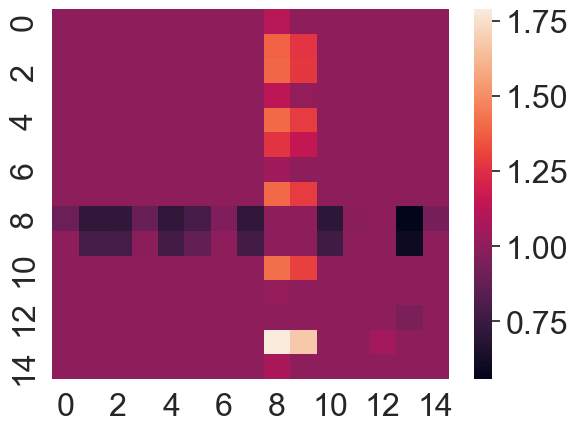

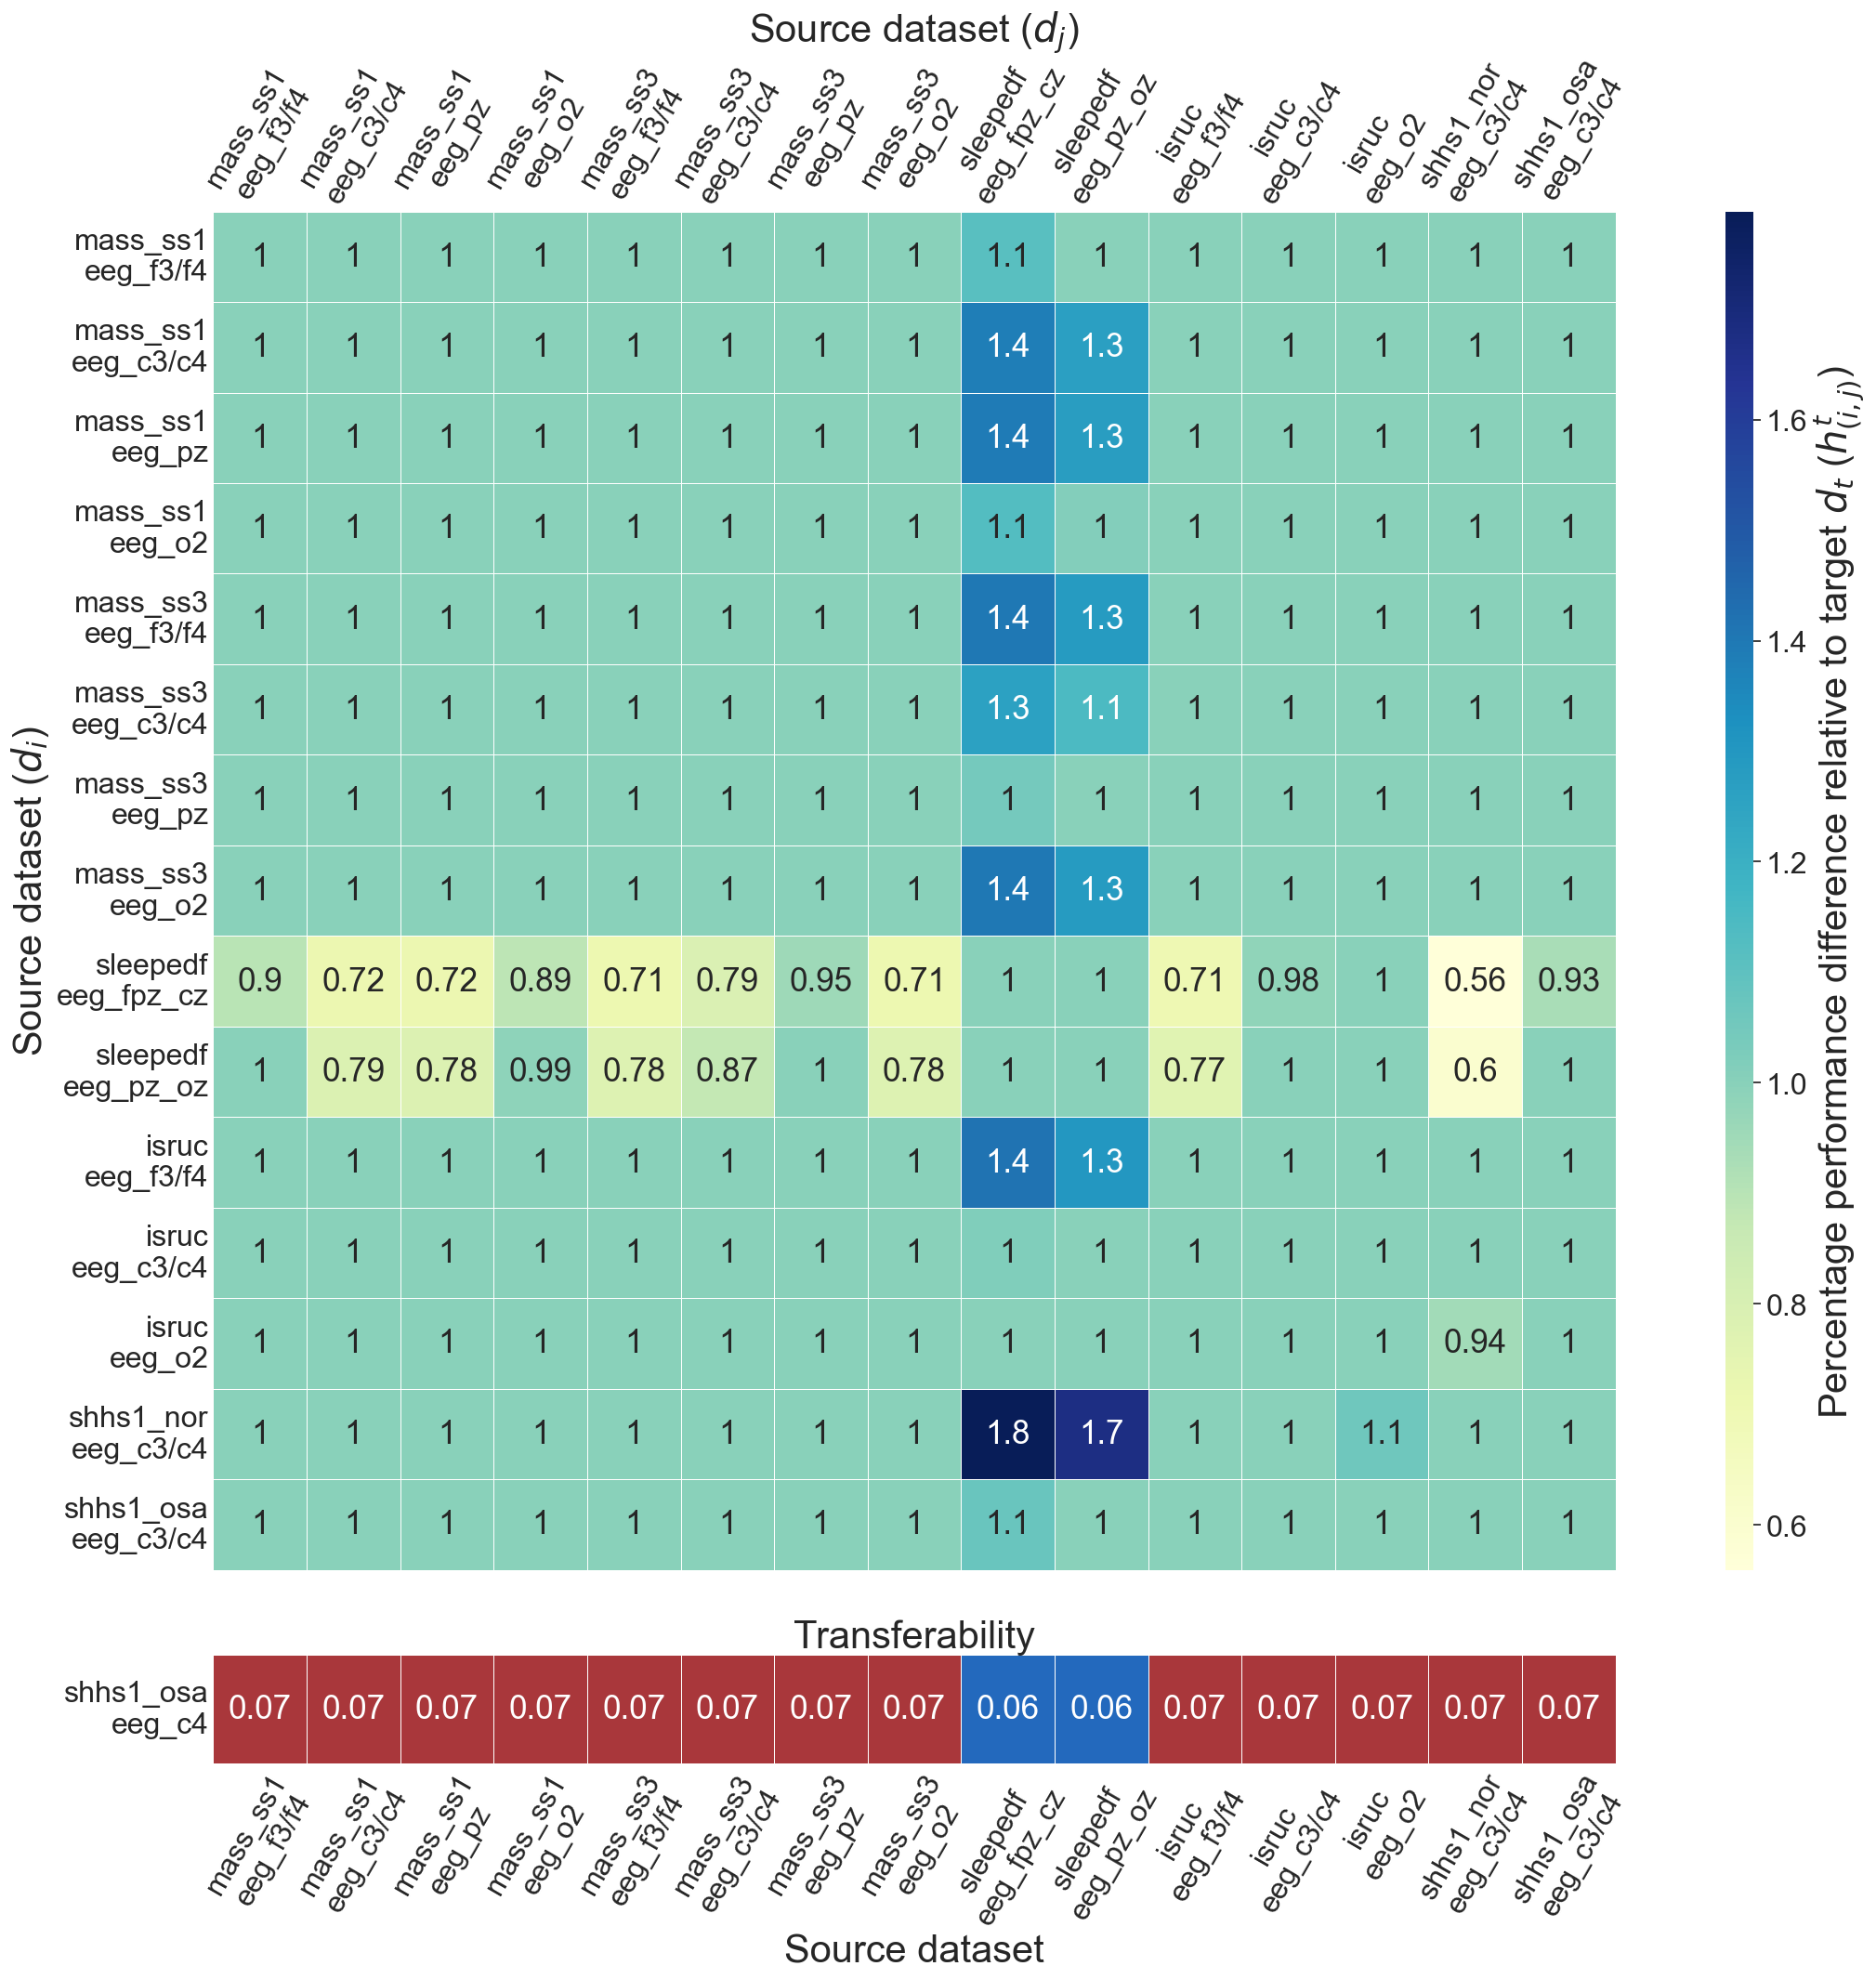

In [25]:
# 30s epoch

import seaborn as sns; sns.set_theme()
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

# type9 / type6
t1 = 9
t2 = 6
db_30s = ['mass_ss1','mass_ss3','sleepedf','isruc','shhs1_normal','shhs1_osa']
db_20s = ['mass_ss2','mass_ss4','mass_ss5']
chs = ['eeg_f','eeg_c','eeg_p','eeg_o']
print(f"{type_map[f'type{t1}']} / {type_map[f'type{t2}']}")

#### Affinity matrix ####

# target_ds = df['target_dataset'].unique()
target_ds = db_30s
tfability = OrderedDict()
for tgt_ds in target_ds:
    tgt_df = df[df['target_dataset'] == tgt_ds]
    # for tgt_ch in tgt_df['target_channel'].unique():
    for tgt_ch in sorted(tgt_df['target_channel'].unique(), key=cmp_to_key(compare)):
        tgt_ch_df = tgt_df[tgt_df['target_channel'] == tgt_ch].sort_values(by=['source_dataset','source_channel'])
        perf_mf1_type_t2 = tgt_ch_df[['target_dataset','target_channel',f'mf1_type{t1}',f'mf1_type{t2}']] \
                    .groupby(by=['target_dataset','target_channel']).mean() \
                    .reset_index().iloc[0].to_dict()[f'mf1_type{t2}']
        display(tgt_ch_df)
        print(f"Target: {tgt_ds}-{tgt_ch}")
        if tgt_ds in db_30s:
            list_ds = db_30s
        else:
            list_ds = db_20s
        i = 0
        aff_mat = np.zeros((len(list_ds)*len(chs),len(list_ds)*len(chs)))
        src_list = []
        nan_src_list = []
        for src_ds in list_ds:
            for src_ch in chs:
                perf = tgt_ch_df[(tgt_ch_df['source_dataset']==src_ds) & (tgt_ch_df['source_channel'].str.contains(src_ch))]
                if len(perf) == 1:
                    print(f'Comparing source: {src_ds}-{src_ch}')
                    # display(perf)
                    perf = perf.iloc[0].to_dict()
                    if tgt_ds == 'mass_ss1':
                        mf1 = perf[f'mf1_type{t1}'] / perf[f'mf1_type{t2}']
                    else:
                        mf1 = perf[f'mf1_type{t1}'] / perf_mf1_type_t2
                    j = 0
                    for _src_ds in list_ds:
                        for _src_ch in chs:
                            if i == j:
                                aff_mat[i,j] = 1
                            else:
                                _perf = tgt_ch_df[(tgt_ch_df['source_dataset']==_src_ds) & (tgt_ch_df['source_channel'].str.contains(_src_ch))]
                                if len(_perf) == 1:
                                    print(f'With source: {_src_ds}-{_src_ch}')
                                    # display(_perf)
                                    _perf = _perf.iloc[0].to_dict()
                                    if tgt_ds == 'mass_ss1':
                                        _mf1 = _perf[f'mf1_type{t1}'] / _perf[f'mf1_type{t2}']
                                    else:
                                        _mf1 = _perf[f'mf1_type{t1}'] / perf_mf1_type_t2
                                    diff = (mf1 - _mf1) * 100
                                    if diff >= 1:
                                        # greater
                                        aff_mat[i,j] = diff
                                    elif diff <= -1:
                                        # less
                                        aff_mat[i,j] = 1. / abs(diff)
                                    else:
                                        # equal or less than 1 percent better
                                        aff_mat[i,j] = 1
                                    # if aff_mat[i,j] >= 5:
                                    #     print(perf[f'mf1_type{t1}'], perf[f'mf1_type{t2}'], _perf[f'mf1_type{t1}'], _perf[f'mf1_type{t2}'])
                                    #     print(src_ds, src_ch, _src_ds, _src_ch, aff_mat[i,j], mf1, _mf1)
                                else:
                                    aff_mat[i,j] = float('nan')
                            j += 1
                    src_list.append(f"{perf['source_dataset']}-{perf['source_channel']}")
                else:
                    aff_mat[i,:] = float('nan')
                    nan_src_list.append(f"{src_ds}-{src_ch}")
                i += 1
        # Heatmap
        nan_src = np.where(np.isnan(aff_mat).all(axis=0))[0]
        print(f"Not available source: {nan_src_list} {nan_src}")
        aff_mat = aff_mat[~np.isnan(aff_mat).all(axis=0)]
        aff_mat = aff_mat[:,~np.all(np.isnan(aff_mat), axis=0)]
        ax = sns.heatmap(aff_mat)

        # Estimate eigenvector (not exact calculation)
        sum_cols = np.sum(aff_mat, axis=0)
        norm_aff_mat = aff_mat / sum_cols
        est_eigenvectors = np.sum(norm_aff_mat, axis=1) / norm_aff_mat.shape[1]
        print(est_eigenvectors)

        tfability[f'{tgt_ds}-{tgt_ch}'] = {}
        tfability[f'{tgt_ds}-{tgt_ch}']['src'] = src_list
        tfability[f'{tgt_ds}-{tgt_ch}']['eigenvector'] = est_eigenvectors

        # for publication
        ticklabels = [_.replace('-','\n') for _ in src_list]
        for _i, _x in enumerate(ticklabels):
            if 'eeg_f3' in _x:
                _x = _x.replace('eeg_f3','eeg_f3/f4')
            elif 'eeg_f4' in _x:
                _x = _x.replace('eeg_f4','eeg_f3/f4')
            elif 'eeg_c3' in _x:
                _x = _x.replace('eeg_c3','eeg_c3/c4')
            elif 'eeg_c4' in _x:
                _x = _x.replace('eeg_c4','eeg_c3/c4')
            ticklabels[_i] = _x.replace('_a1', '').replace('_a2', '').replace('_normal','_nor')

        label_size = 30
        sns.set(font_scale=2.1)
        gs_kw = dict(width_ratios=[1,0.02], height_ratios=[1,0.08])
        f, axs = plt.subplots(ncols=2, nrows=2, figsize=(18,18), gridspec_kw=gs_kw)
        axs[1,1].remove()
        f.tight_layout()
        axs[0,0].get_shared_y_axes().join(axs[1,0])
        ax = sns.heatmap(
            aff_mat,
            cmap="YlGnBu",
            xticklabels=ticklabels,
            yticklabels=ticklabels,
            linewidths=.5,
            annot=True,
            cbar_ax=axs[0,1],
            # cbar_kws={'label':r'$h^{t}_{(i,j)}$'},
            ax=axs[0,0])
        axs[0,0].set_yticklabels(axs[0,0].get_yticklabels(), rotation=0)
        axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=60)
        axs[0,0].xaxis.tick_top()
        axs[0,0].xaxis.set_label_position('top')
        axs[0,0].tick_params(length=0)
        axs[0,0].set_xlabel(f'Source dataset ({r"$d_j$"})', fontsize=label_size)
        axs[0,0].set_ylabel(f'Source dataset ({r"$d_i$"})', fontsize=label_size)
        axs[0,1].set_ylabel(r'Percentage performance difference relative to target $d_t$ ($h^{t}_{(i,j)}$)', fontsize=label_size)

        ax = sns.heatmap(
            [np.round(est_eigenvectors, 2)],
            cmap='vlag',
            xticklabels=ticklabels,
            yticklabels=[f"{tgt_ds}\n{tgt_ch.replace('_a1', '').replace('_a2', '').replace('_normal','_nor')}"],
            linewidths=.5,
            cbar=False,
            annot=True,
            ax=axs[1,0])
        axs[1,0].set_yticklabels(axs[1,0].get_yticklabels(), rotation=0)
        axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=60)
        axs[1,0].tick_params(length=0)
        axs[1,0].set_xlabel(f'Source dataset', fontsize=label_size)
        axs[1,0].set_title(f'Transferability', fontsize=label_size)
        plt.savefig(f'{tgt_ds}-{tgt_ch}.eps', format='eps', dpi=500, bbox_inches='tight')
        plt.show()
        plt.close('all')